# Estimating a regional field
Here we will present the 4 methods we provide for estimating the regional component of gravity misfit.

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2
import os

import numpy as np
import pandas as pd
import verde as vd
import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils

import invert4geom

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

/home/sungw937/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Get data

Here we will load a commonly used synthetic gravity and basement topography model. It includes topography of the Moho and the crystalline basement. The gravity effect from the Moho will represent the **regional** which we are aiming to isolate. We will forward model the gravity effects of both layers, and add some noise, to create an observed gravity dataset. We will then use a series of point where we know the basement topography to create a starting model, forward calculate its gravity effect, and remove it from the observed gravity to get a gravity misfit. We will then demonstrate the range of techniques implemented within *Invert4Geom* for isolated the regional component of this gravity misfit.

In [2]:
# get topography data
grid = invert4geom.load_bishop_model(coarsen_factor=20)

# extract grid spacing and region
spacing, buffer_region, _, _, _ = polar_utils.get_grid_info(
    grid.basement_topo, print_info=True
)

# get topography data
basement_topo = grid.basement_topo.to_dataset(name="upward")
moho_topo = grid.moho_topo.to_dataset(name="upward")

# create an inside region to reduce gravity edge effects
region = vd.pad_region(buffer_region, -spacing * 5)
region

grid spacing: 4000.0 m
grid region: (3900.0, 379900.0, 142900.0, 538900.0)
grid zmin: -9349.98535156
grid zmax: -276.429992676
grid registration: g


(23900.0, 359900.0, 162900.0, 518900.0)

In [3]:
basement_model = invert4geom.create_model(
    zref=basement_topo.upward.to_numpy().mean(),
    density_contrast=2800 - 2500,
    starting_topography=basement_topo,
)
moho_model = invert4geom.create_model(
    zref=moho_topo.upward.to_numpy().mean(),
    density_contrast=3300 - 2800,
    starting_topography=moho_topo,
)

## Prism layers

Create prism layers from the Moho and basement surfaces.

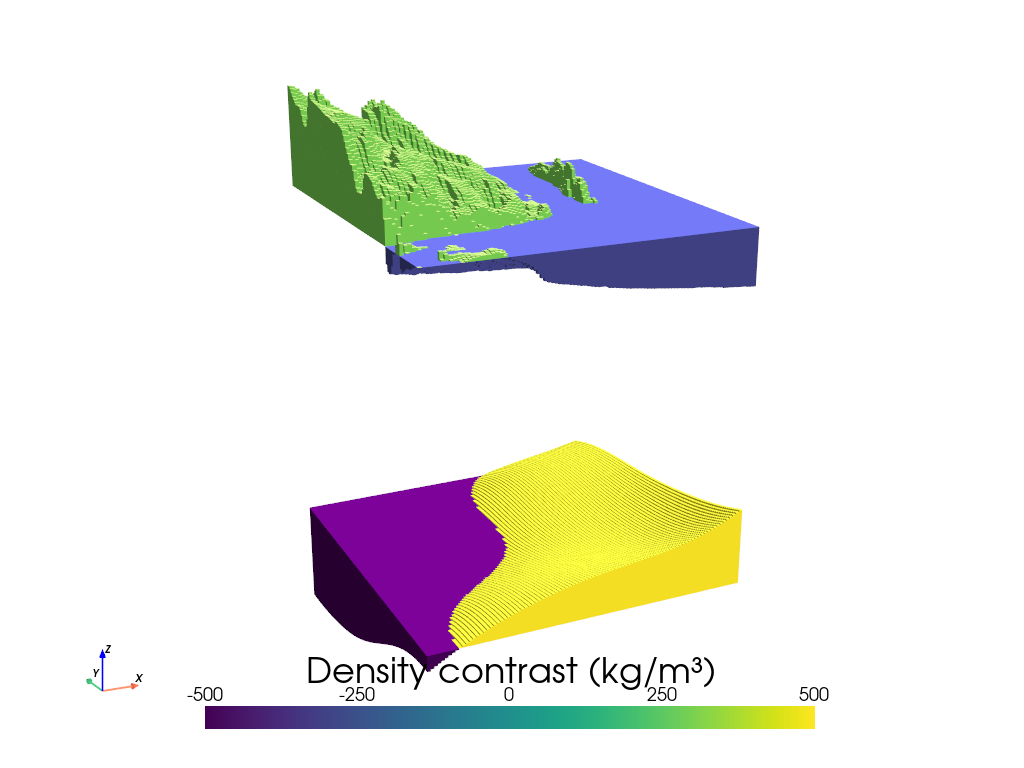

In [4]:
invert4geom.plot_prism_layers(
    [basement_model, moho_model],
    color_by="density",
    zscale=20,
)

## Forward gravity of prism layers

Calculate the gravity effect of each of these prism layers

In [5]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
)

In [6]:
data = invert4geom.create_data(observations)

print(f"Gravity region (W,E,S,N): {data.region}")
print(f"Gravity spacing: {data.spacing} m")
data

Gravity region (W,E,S,N): (23900.0, 359900.0, 162900.0, 518900.0)
Gravity spacing: 4000.0 m


<xarray.Dataset> Size: 63kB
Dimensions:   (northing: 90, easting: 85)
Coordinates:
  * northing  (northing) float64 720B 1.629e+05 1.669e+05 ... 5.189e+05
  * easting   (easting) float64 680B 2.39e+04 2.79e+04 ... 3.559e+05 3.599e+05
Data variables:
    upward    (northing, easting) float64 61kB 1e+03 1e+03 1e+03 ... 1e+03 1e+03
Attributes:
    region:        (23900.0, 359900.0, 162900.0, 518900.0)
    spacing:       4000.0
    buffer_width:  32000.0
    inner_region:  (55900.0, 327900.0, 194900.0, 486900.0)
    dataset_type:  data
    model_type:    prisms

In [7]:
data.inv.forward_gravity(basement_model, name="basement_grav")
data.inv.forward_gravity(moho_model, name="moho_grav")
data

<xarray.Dataset> Size: 185kB
Dimensions:        (northing: 90, easting: 85)
Coordinates:
  * northing       (northing) float64 720B 1.629e+05 1.669e+05 ... 5.189e+05
  * easting        (easting) float64 680B 2.39e+04 2.79e+04 ... 3.599e+05
Data variables:
    upward         (northing, easting) float64 61kB 1e+03 1e+03 ... 1e+03 1e+03
    basement_grav  (northing, easting) float64 61kB -2.757 -2.269 ... -16.32
    moho_grav      (northing, easting) float64 61kB -3.04 -2.545 ... 15.05 14.69
Attributes:
    region:        (23900.0, 359900.0, 162900.0, 518900.0)
    spacing:       4000.0
    buffer_width:  32000.0
    inner_region:  (55900.0, 327900.0, 194900.0, 486900.0)
    dataset_type:  data
    model_type:    prisms

In [8]:
# add offset to the moho gravity
data["moho_grav"] += 100

data["gravity_anomaly_no_noise"] = data.basement_grav + data.moho_grav

In [9]:
# contaminate gravity with 2 mGal of random noise
data["gravity_anomaly"], stddev = invert4geom.contaminate(
    data.gravity_anomaly_no_noise,
    stddev=2,
    percent=False,
    seed=0,
)
data["uncert"] = xr.full_like(data.gravity_anomaly, stddev)
data

<xarray.Dataset> Size: 369kB
Dimensions:                   (northing: 90, easting: 85)
Coordinates:
  * northing                  (northing) float64 720B 1.629e+05 ... 5.189e+05
  * easting                   (easting) float64 680B 2.39e+04 ... 3.599e+05
Data variables:
    upward                    (northing, easting) float64 61kB 1e+03 ... 1e+03
    basement_grav             (northing, easting) float64 61kB -2.757 ... -16.32
    moho_grav                 (northing, easting) float64 61kB 96.96 ... 114.7
    gravity_anomaly_no_noise  (northing, easting) float64 61kB 94.2 ... 98.37
    gravity_anomaly           (northing, easting) float64 61kB 94.46 ... 98.23
    uncert                    (northing, easting) float64 61kB 2.0 2.0 ... 2.0
Attributes:
    region:        (23900.0, 359900.0, 162900.0, 518900.0)
    spacing:       4000.0
    buffer_width:  32000.0
    inner_region:  (55900.0, 327900.0, 194900.0, 486900.0)
    dataset_type:  data
    model_type:    prisms

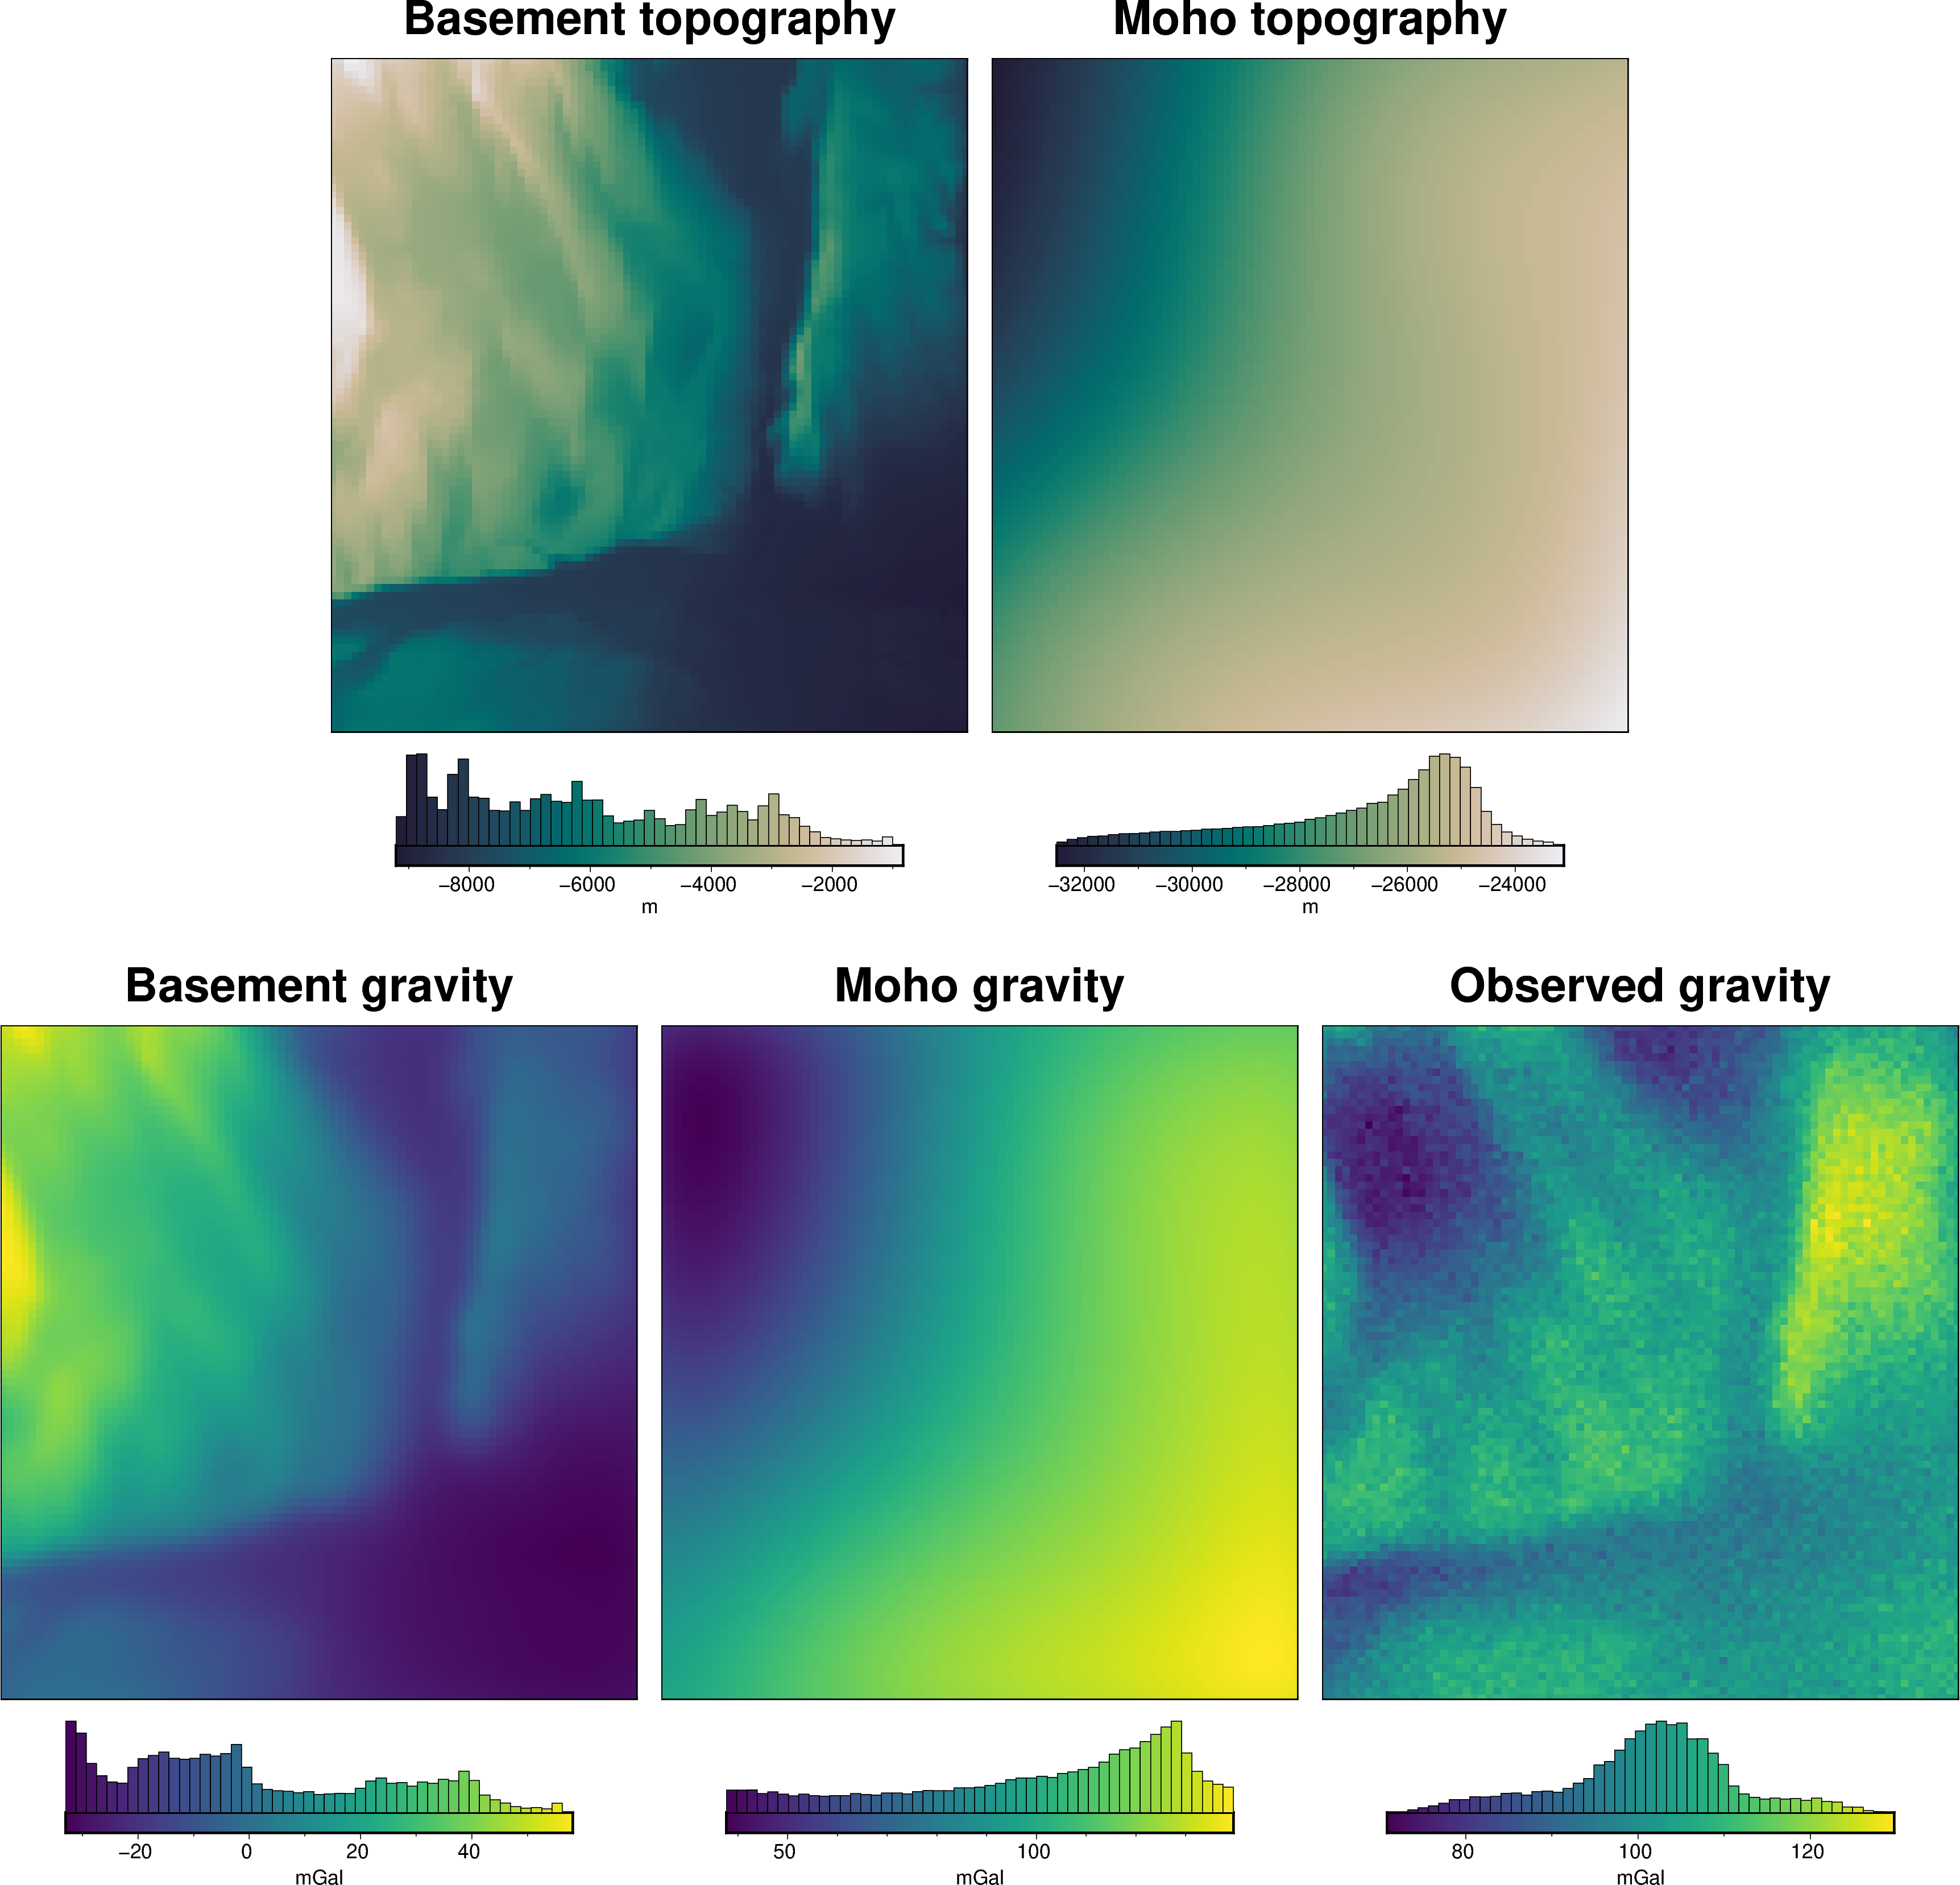

In [ ]:
fig = maps.plot_grd(
    basement_model.topography,
    region=region,
    fig_height=10,
    title="Basement topography",
    reverse_cpt=True,
    cmap="rain",
    cbar_label="m",
    hist=True,
)

fig = maps.plot_grd(
    moho_model.topography,
    region=region,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Moho topography",
    reverse_cpt=True,
    cmap="rain",
    cbar_label="m",
    hist=True,
)

fig = maps.plot_grd(
    data.basement_grav,
    region=region,
    fig=fig,
    origin_shift="both",
    xshift_amount=-1.5,
    fig_height=10,
    title="Basement gravity",
    cmap="viridis",
    cbar_label="mGal",
    hist=True,
)

fig = maps.plot_grd(
    data.moho_grav,
    region=region,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Moho gravity",
    cmap="viridis",
    cbar_label="mGal",
    hist=True,
)

fig = maps.plot_grd(
    data.gravity_anomaly,
    region=region,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Observed gravity",
    cmap="viridis",
    cbar_label="mGal",
    hist=True,
)

fig.show()

## Create "a-priori" basement measurements
These points represent locations where we know the basement elevation, for example from drill holes, seismic surveys, or outcropping basement.

In [11]:
# create 10 random point within the outcropping basement region
num_constraints = 15
coords = vd.scatter_points(
    region=region,
    size=num_constraints,
    random_state=22,
)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    basement_topo.upward,
    "true_upward",
)

constraint_points["upward"] = constraint_points.true_upward

# re-sample depths with uncertainty to emulate measurement errors
# set each points uncertainty equal to 2% of depth
uncert = np.abs(0.02 * constraint_points.upward)
constraint_points.loc[constraint_points.index, "uncert"] = uncert

constraint_points = invert4geom.randomly_sample_data(
    seed=0,
    data_df=constraint_points,
    data_col="upward",
    uncert_col="uncert",
)

# create weights column
constraint_points["weight"] = 1 / (constraint_points.uncert**2)

constraint_points.head()

easting       northing  true_upward       upward      uncert  \
0   93942.740553  165086.148419 -6166.691339 -6151.184549  123.333827   
1  185744.836752  437747.618234 -5230.910817 -5244.731393  104.618216   
2  165200.779866  503888.251841 -4551.466895 -4493.169645   91.029338   
3  312585.151503  412789.886738 -6178.090981 -6165.129332  123.561820   
4   81410.282014  268837.863004 -4562.000830 -4610.875312   91.240017   

     weight  
0  0.000066  
1  0.000091  
2  0.000121  
3  0.000065  
4  0.000120

## Create starting basement model

Here we interpolate the *a-priori* point measurements to create a starting model of basement topography. We then use this to create a starting prism model.

In [12]:
# grid the sampled values using verde
starting_topography = invert4geom.create_topography(
    method="splines",
    region=buffer_region,
    spacing=spacing,
    constraints_df=constraint_points,
    dampings=[*list(np.logspace(-60, 0, 100)), None],
    weights=constraint_points.weight,
).to_dataset(name="upward")

Best damping value (1e-60) is at the limit of provided values (1e-60, 1.0) and thus is likely not a global minimum, expand the range of values test to ensure the best parameter value value is found.


In [13]:
model = invert4geom.create_model(
    zref=basement_topo.upward.to_numpy().mean(),
    density_contrast=2800 - 2500,
    starting_topography=starting_topography,
)

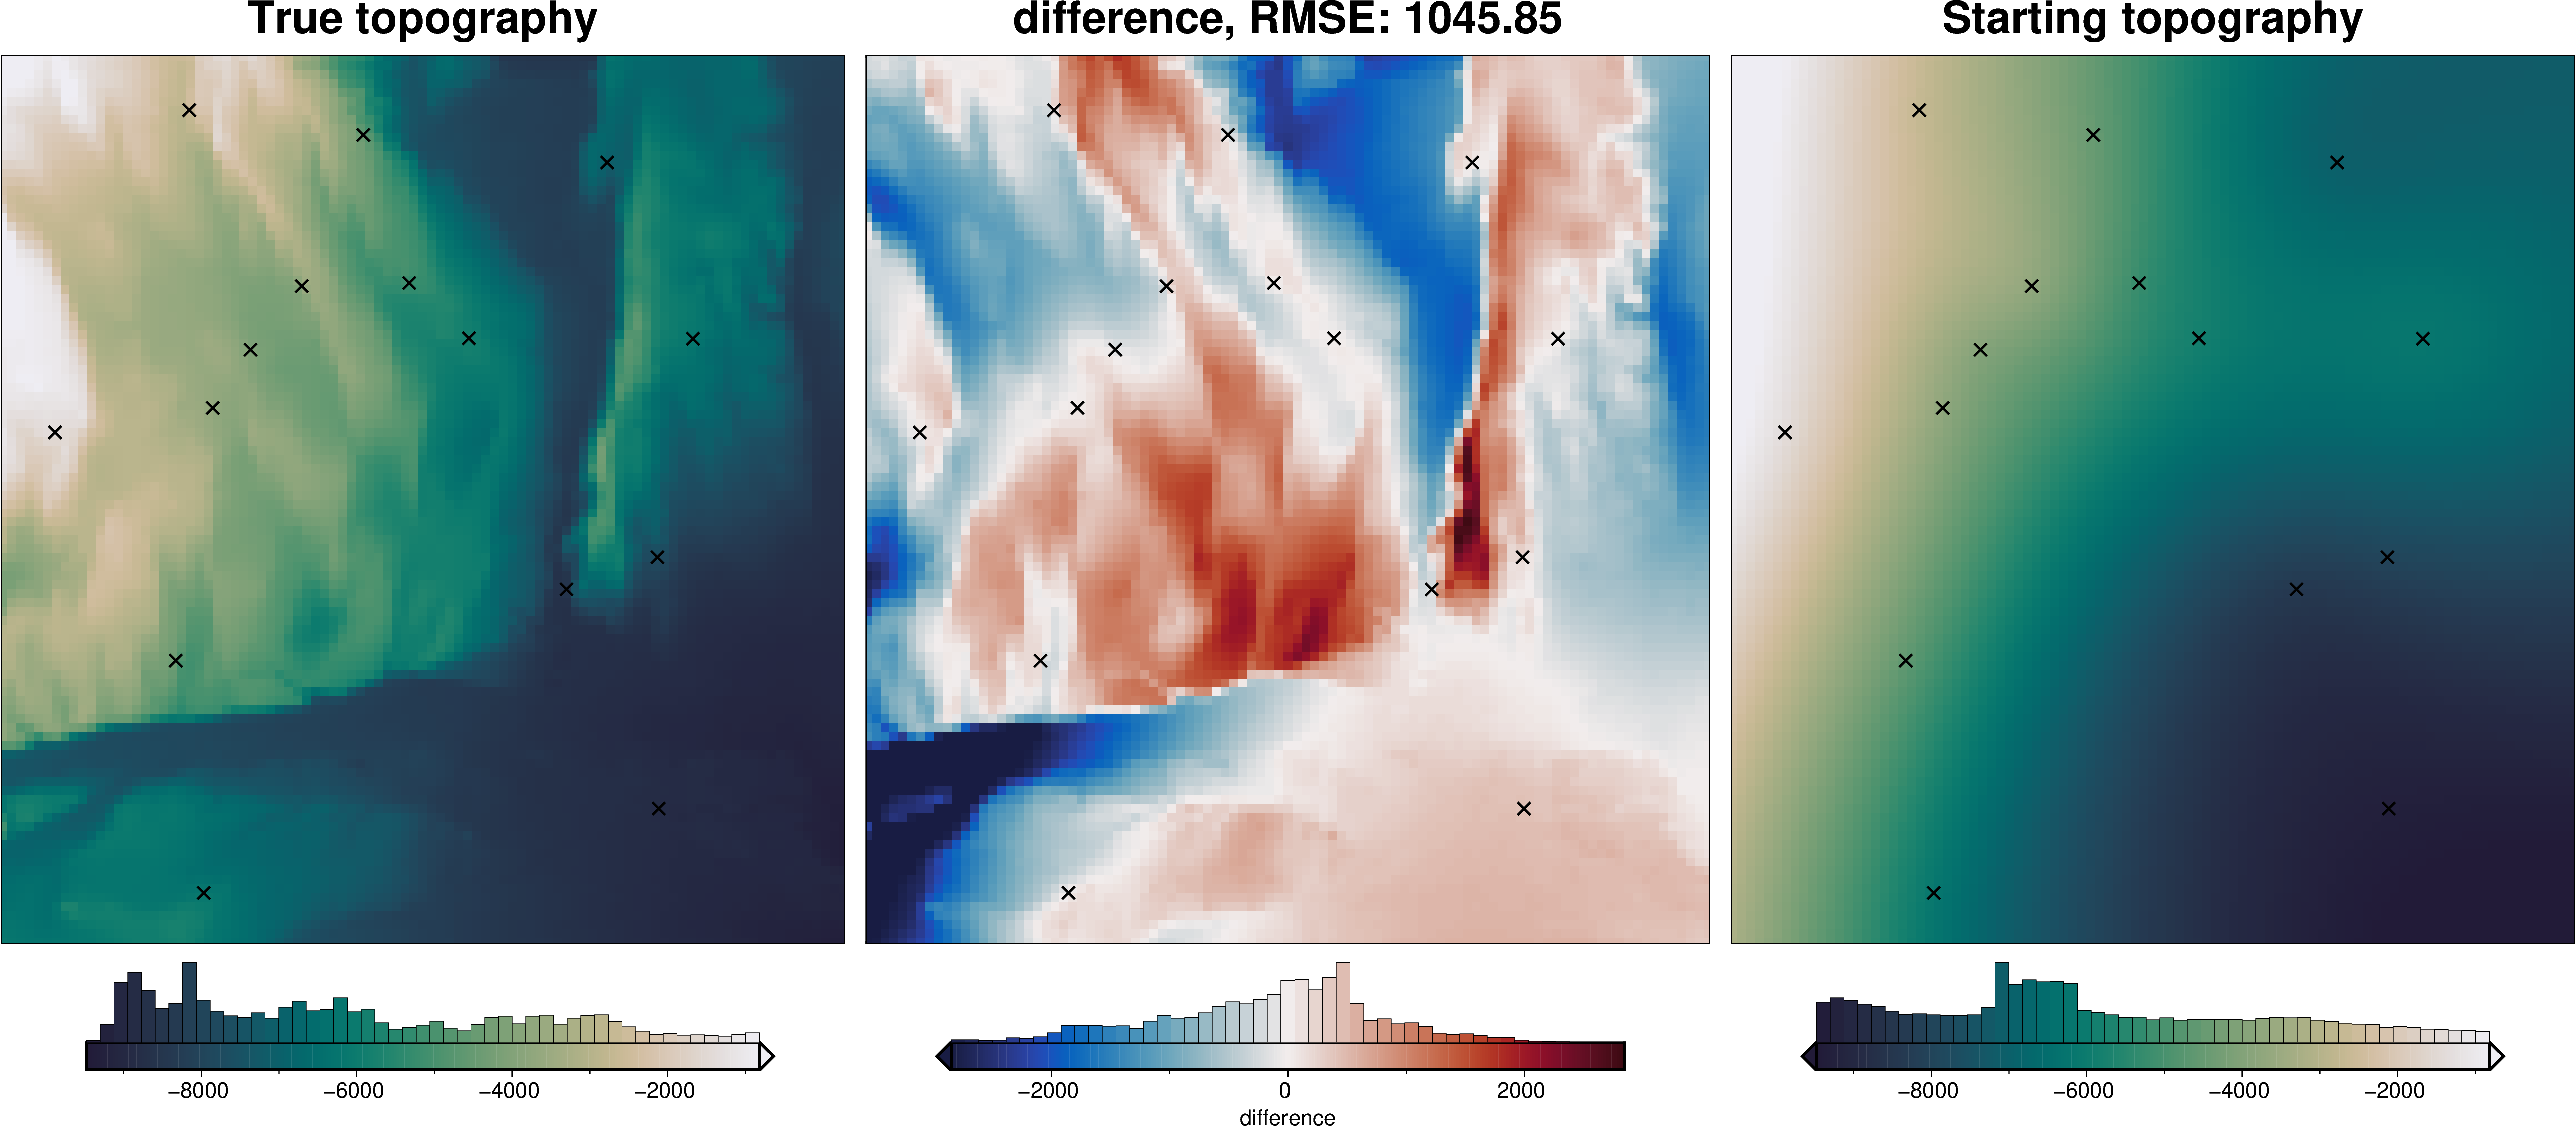

In [14]:
_ = polar_utils.grd_compare(
    basement_topo.upward,
    starting_topography.upward,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

## Gravity misfit

All inversions in Invert4Geom are based on a gravity misfit, not a gravity anomaly. This means before the inversion, we must create a starting prism model, forward model it's gravity effect, remove it from the gravity anomaly, and get a gravity misfit. 

### Forward gravity of starting prism layer

In [15]:
data.inv.forward_gravity(model)

# calculate the true residual misfit
# true misfit is difference between noise-free gravity and forward gravity
# true regional misfit is the moho gravity
# so true residual is misfit - true_regional
data["true_res"] = data.gravity_anomaly_no_noise - data.forward_gravity - data.moho_grav

data

<xarray.Dataset> Size: 491kB
Dimensions:                   (northing: 90, easting: 85)
Coordinates:
  * northing                  (northing) float64 720B 1.629e+05 ... 5.189e+05
  * easting                   (easting) float64 680B 2.39e+04 ... 3.599e+05
Data variables:
    upward                    (northing, easting) float64 61kB 1e+03 ... 1e+03
    basement_grav             (northing, easting) float64 61kB -2.757 ... -16.32
    moho_grav                 (northing, easting) float64 61kB 96.96 ... 114.7
    gravity_anomaly_no_noise  (northing, easting) float64 61kB 94.2 ... 98.37
    gravity_anomaly           (northing, easting) float64 61kB 94.46 ... 98.23
    uncert                    (northing, easting) float64 61kB 2.0 2.0 ... 2.0
    forward_gravity           (northing, easting) float64 61kB 23.65 ... -10.12
    true_res                  (northing, easting) float64 61kB -26.4 ... -6.2
Attributes:
    region:        (23900.0, 359900.0, 162900.0, 518900.0)
    spacing:       4000.0
    buffer_width:  32000.0
    inner_region:  (55900.0, 327900.0, 194900.0, 486900.0)
    dataset_type:  data
    model_type:    prisms

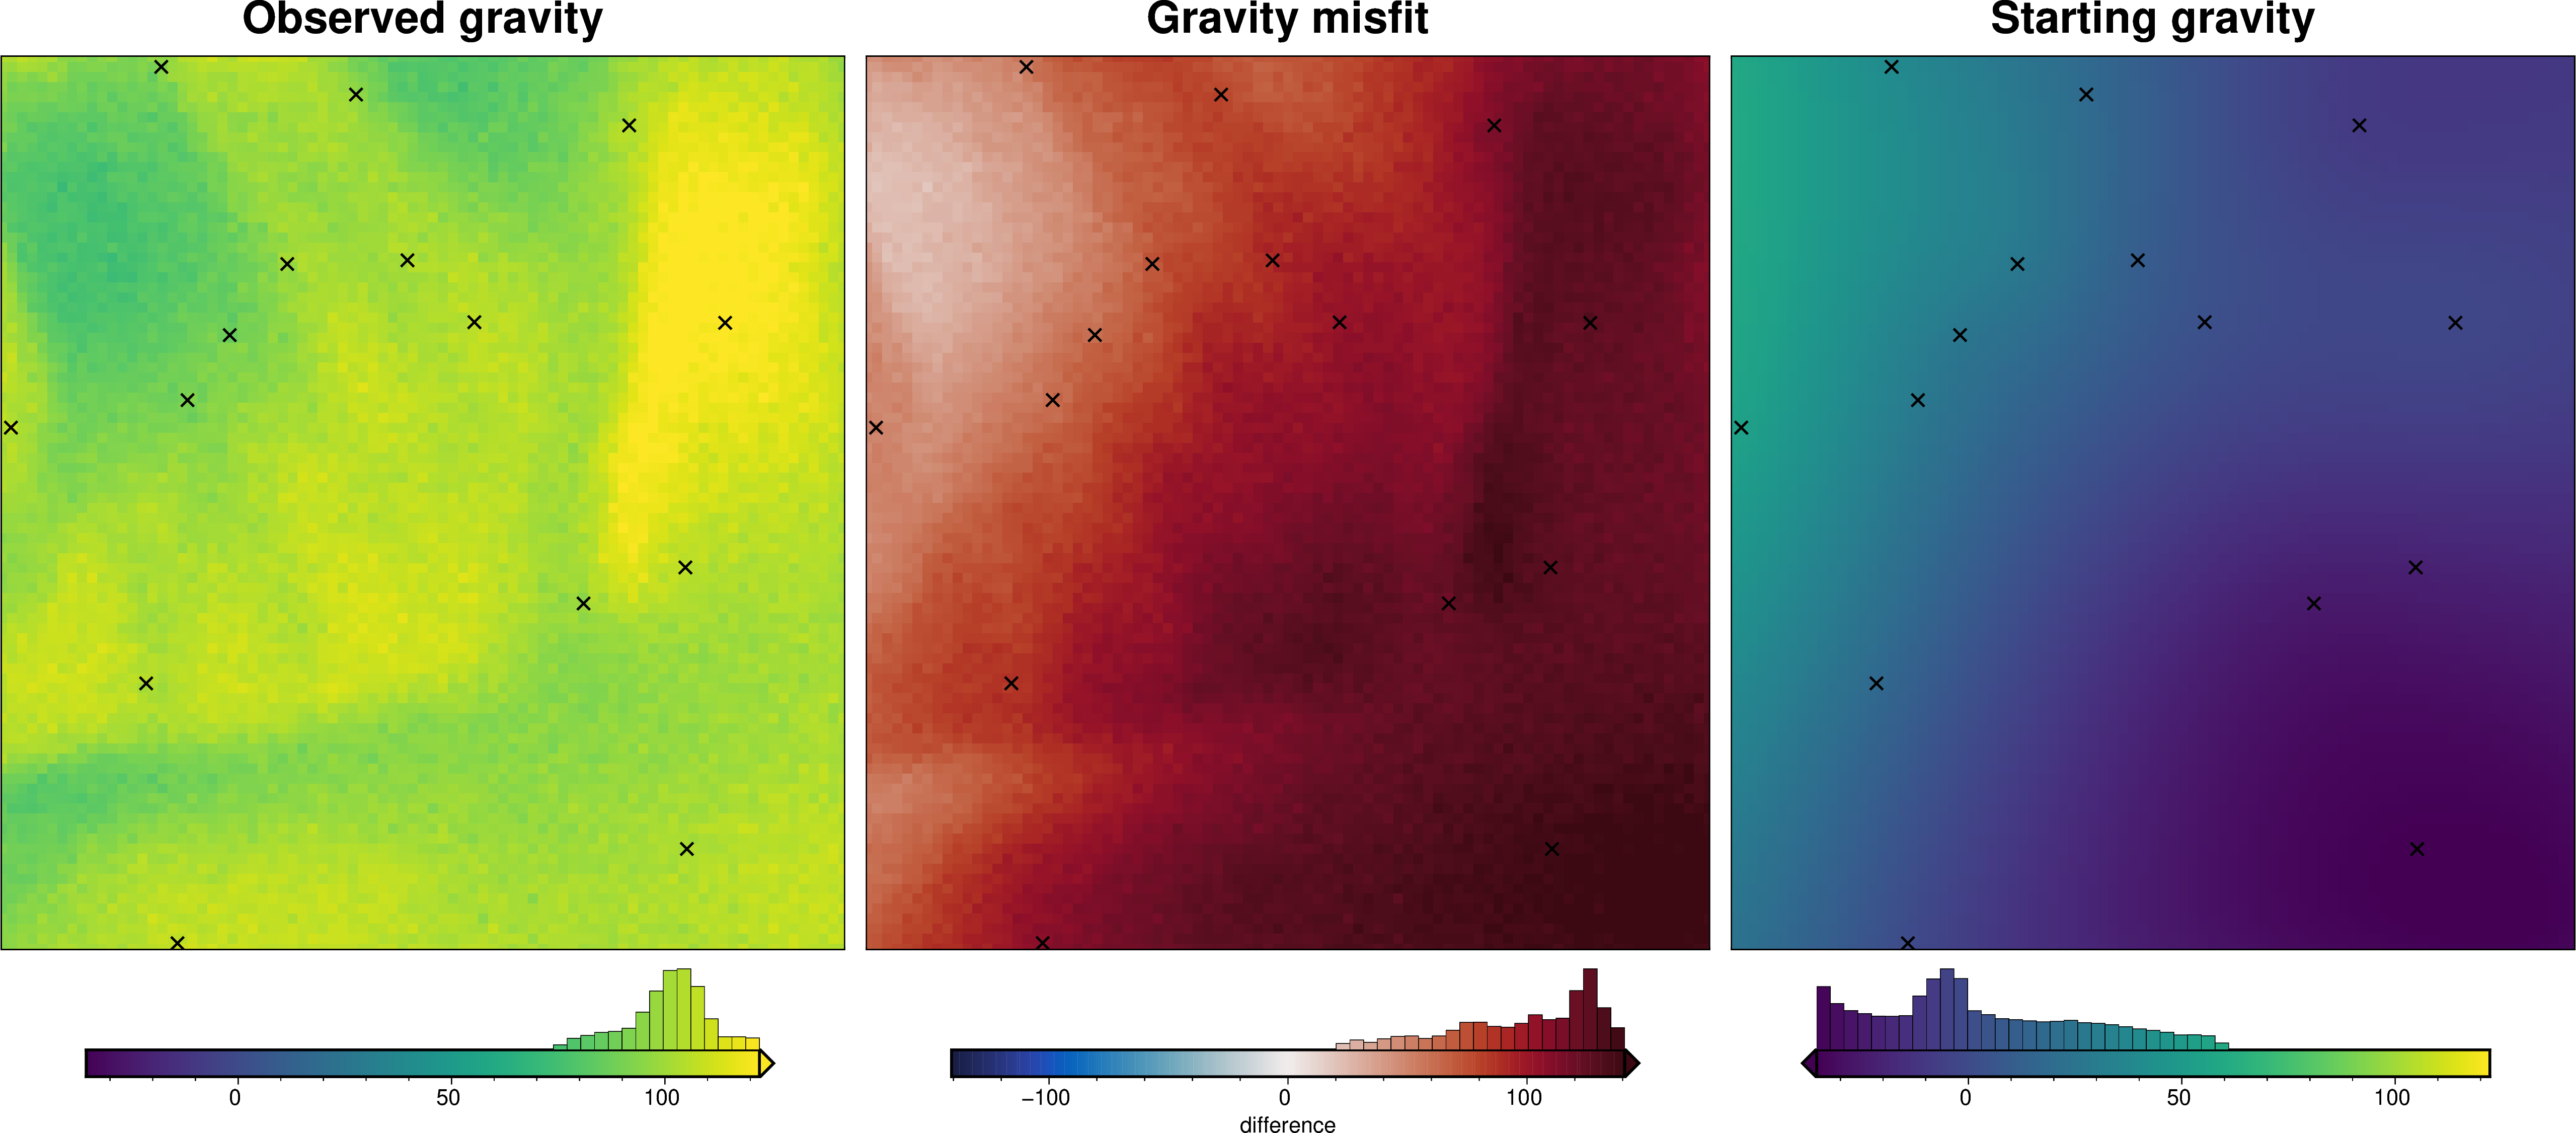

In [16]:
_ = polar_utils.grd_compare(
    data.gravity_anomaly,
    data.forward_gravity,
    grid1_name="Observed gravity",
    grid2_name="Starting gravity",
    robust=True,
    hist=True,
    inset=False,
    title="Gravity misfit",
    rmse_in_title=False,
    grounding_line=False,
    points=constraint_points,
    points_style="x.3c",
)

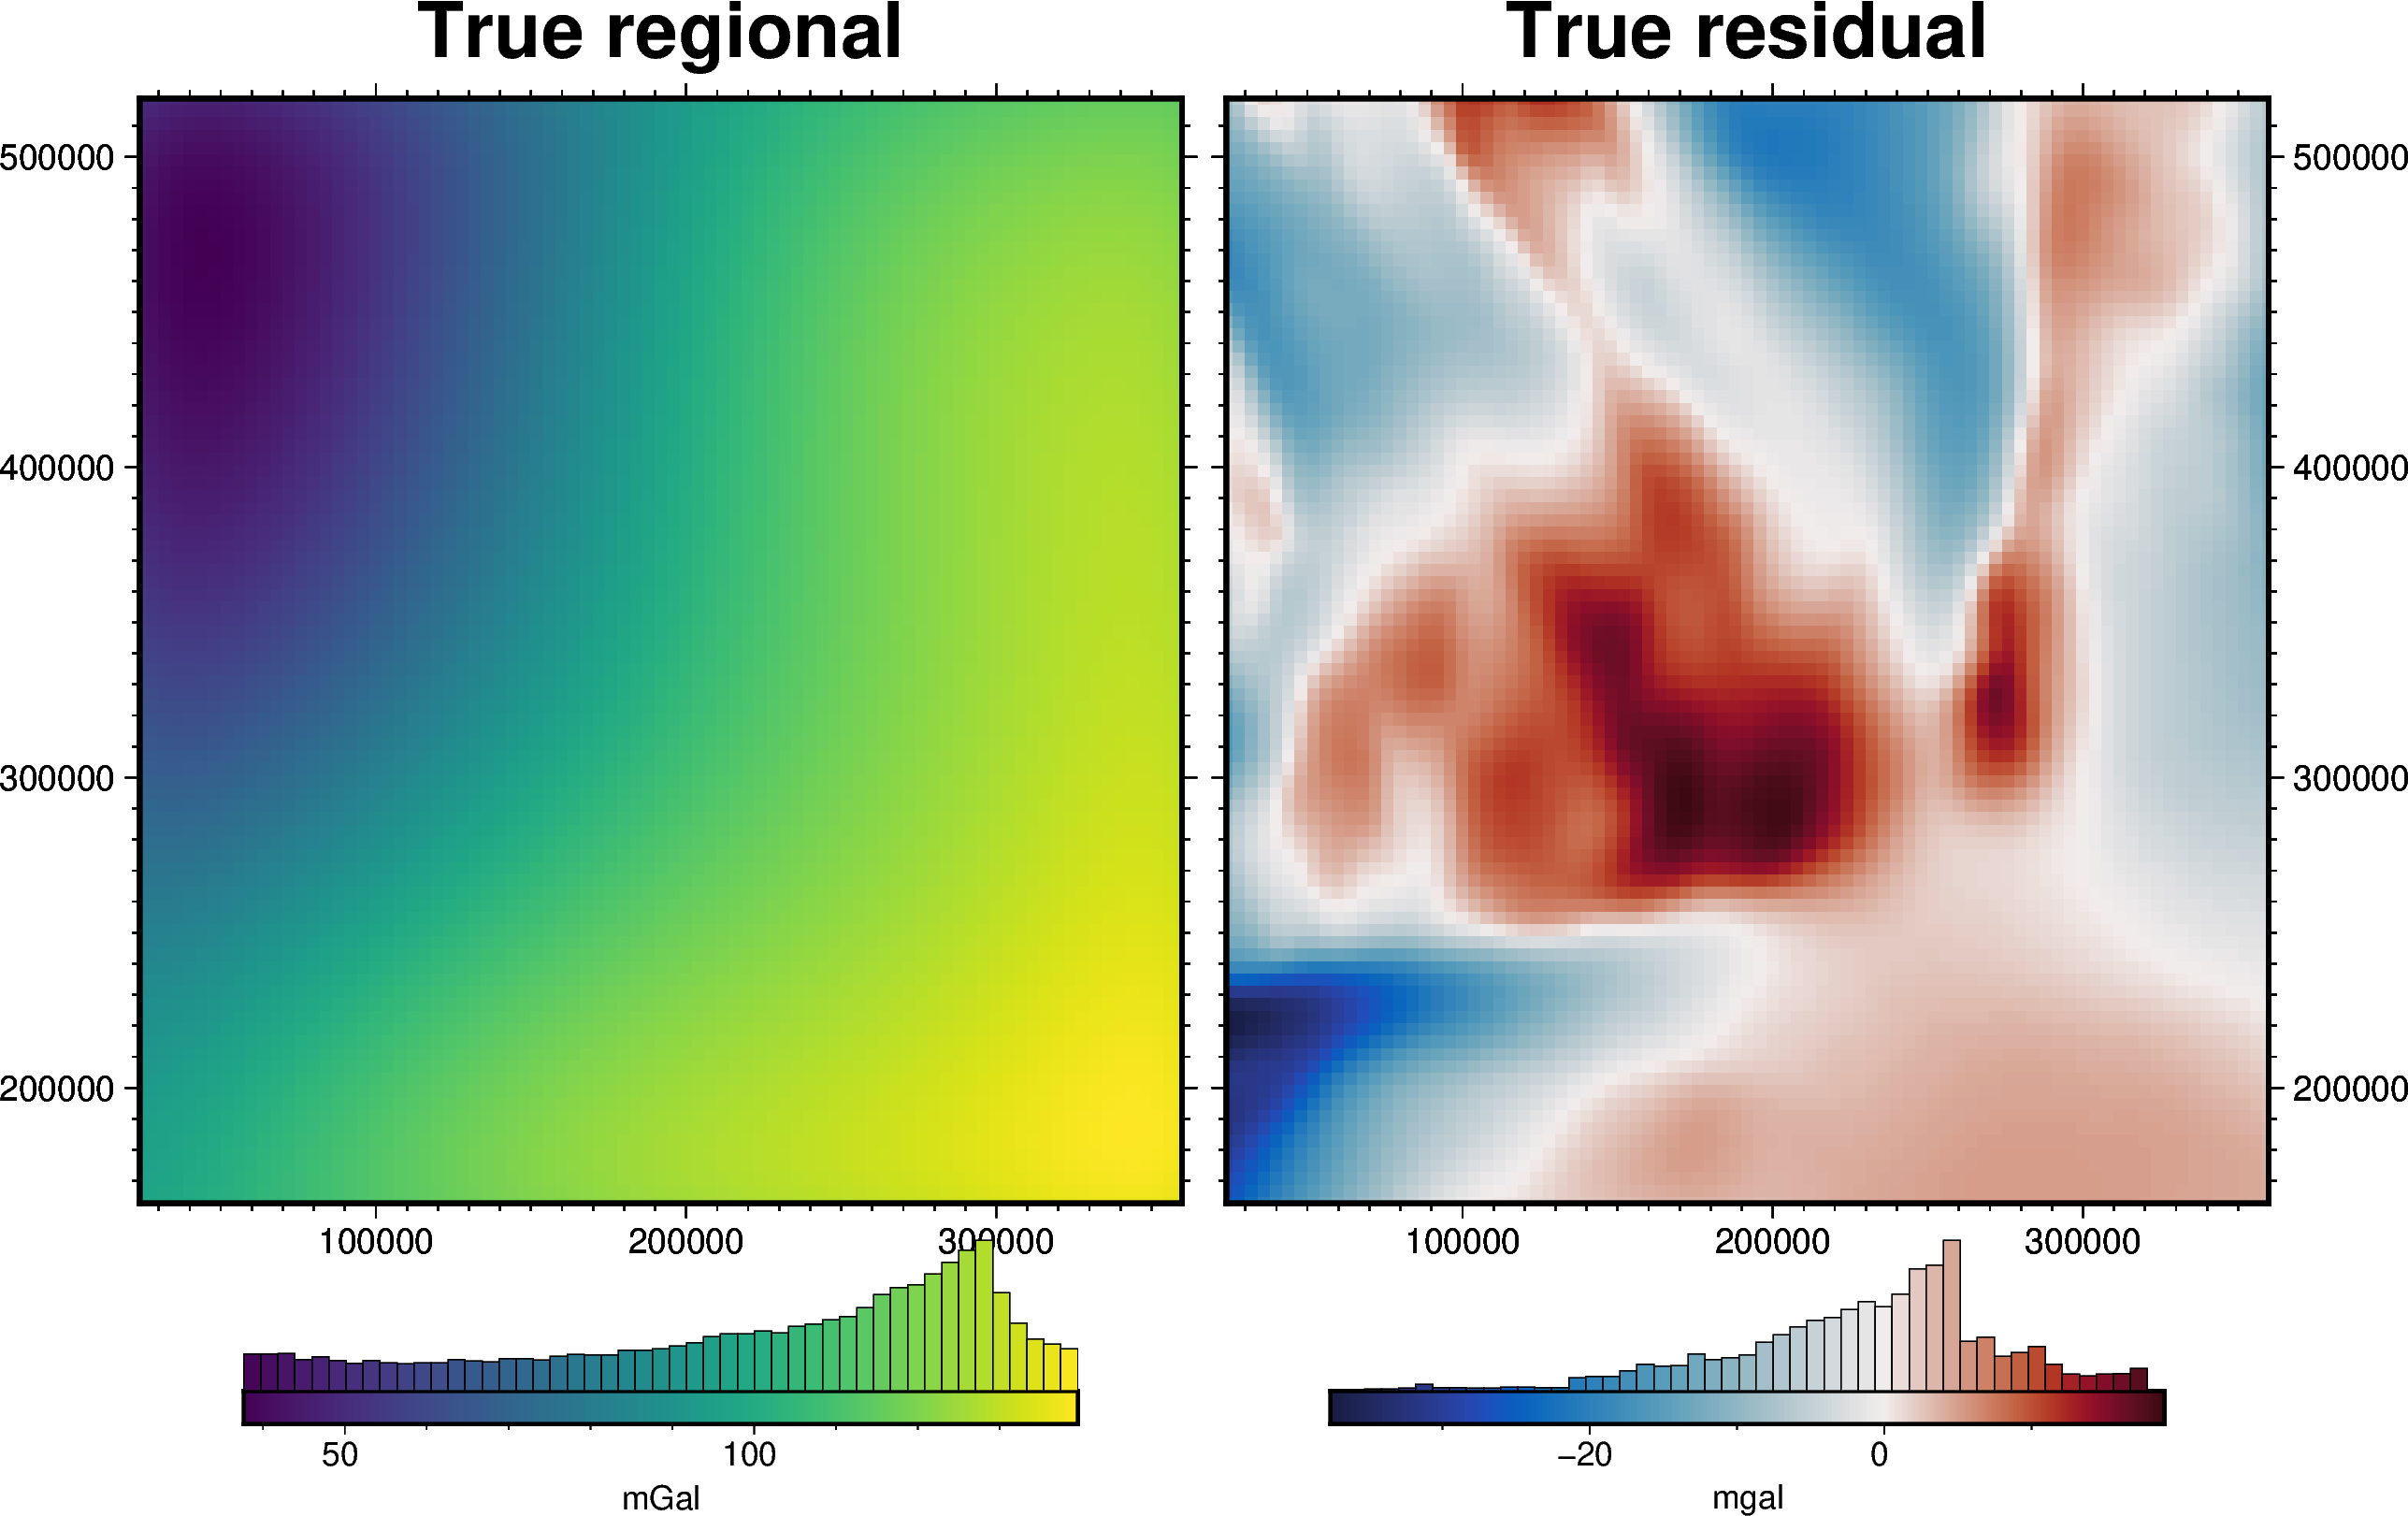

In [17]:
fig = maps.plot_grd(
    data.moho_grav,
    fig_height=10,
    title="True regional",
    cbar_label="mGal",
    hist=True,
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    data.true_res,
    fig=fig,
    cmap="balance+h0",
    origin_shift="x",
    fig_height=10,
    title="True residual",
    cbar_label="mgal",
    hist=True,
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig.show()

## True-Estimated regional plotting function

In [18]:
def regional_comparison(data, regional_column):
    # compare with true regional
    _ = polar_utils.grd_compare(
        data.moho_grav,
        data[regional_column],
        robust=True,
        grid1_name="True regional field",
        grid2_name="Estimated regional field",
        hist=True,
        inset=False,
        title="difference",
        grounding_line=False,
        points=constraint_points,
        points_style="x.3c",
    )
    # compare with true residual
    _ = polar_utils.grd_compare(
        data.true_res,
        data.res,
        cmap="balance+h0",
        robust=True,
        grid1_name="True residual field",
        grid2_name="Estimated residual field",
        hist=True,
        inset=False,
        title="difference",
        grounding_line=False,
        points=constraint_points,
        points_style="x.3c",
    )

## Save data so other notebooks can use it later


In [19]:
# save gravity dataframe
data.to_netcdf("../tmp/regional_sep_grav.nc")

# save constraint points
constraint_points.to_csv("../tmp/regional_sep_constraint_points.csv")

# merge and save grids
ds = xr.merge(
    [
        basement_topo.upward.rename("basement"),
        moho_topo.upward.rename("moho"),
        starting_topography.upward.rename("starting"),
    ]
)
ds.drop_attrs().to_netcdf("../tmp/regional_sep_grids.nc")

## Regional estimation methods

Now that we have a gravity misfit (difference between the true observed gravity and the forward calculated gravity from our knowledge of the topography), we can try and separate out the portion of the misfit not related to our lack of understanding of the topography. This is the **regional misfit** and in this case is resulting from our lower layer of prisms.

There are 4 main techniques: a **constant** value for the regional field, **filtering** the misfit to get the regional, fitting a polynomial **trend** to the misfit to get the regional, calculating the long-wavelength component of the misfit using the **equivalent sources** method, and finding a regional field by using point of known elevation for the layer of interest (**constraint point minimization**).

In [20]:
data

<xarray.Dataset> Size: 491kB
Dimensions:                   (northing: 90, easting: 85)
Coordinates:
  * northing                  (northing) float64 720B 1.629e+05 ... 5.189e+05
  * easting                   (easting) float64 680B 2.39e+04 ... 3.599e+05
Data variables:
    upward                    (northing, easting) float64 61kB 1e+03 ... 1e+03
    basement_grav             (northing, easting) float64 61kB -2.757 ... -16.32
    moho_grav                 (northing, easting) float64 61kB 96.96 ... 114.7
    gravity_anomaly_no_noise  (northing, easting) float64 61kB 94.2 ... 98.37
    gravity_anomaly           (northing, easting) float64 61kB 94.46 ... 98.23
    uncert                    (northing, easting) float64 61kB 2.0 2.0 ... 2.0
    forward_gravity           (northing, easting) float64 61kB 23.65 ... -10.12
    true_res                  (northing, easting) float64 61kB -26.4 ... -6.2
Attributes:
    region:        (23900.0, 359900.0, 162900.0, 518900.0)
    spacing:       4000.0
    buffer_width:  32000.0
    inner_region:  (55900.0, 327900.0, 194900.0, 486900.0)
    dataset_type:  data
    model_type:    prisms

### Constant value

#### 1) Constant value equal to average value of gravity misfit at constraint points

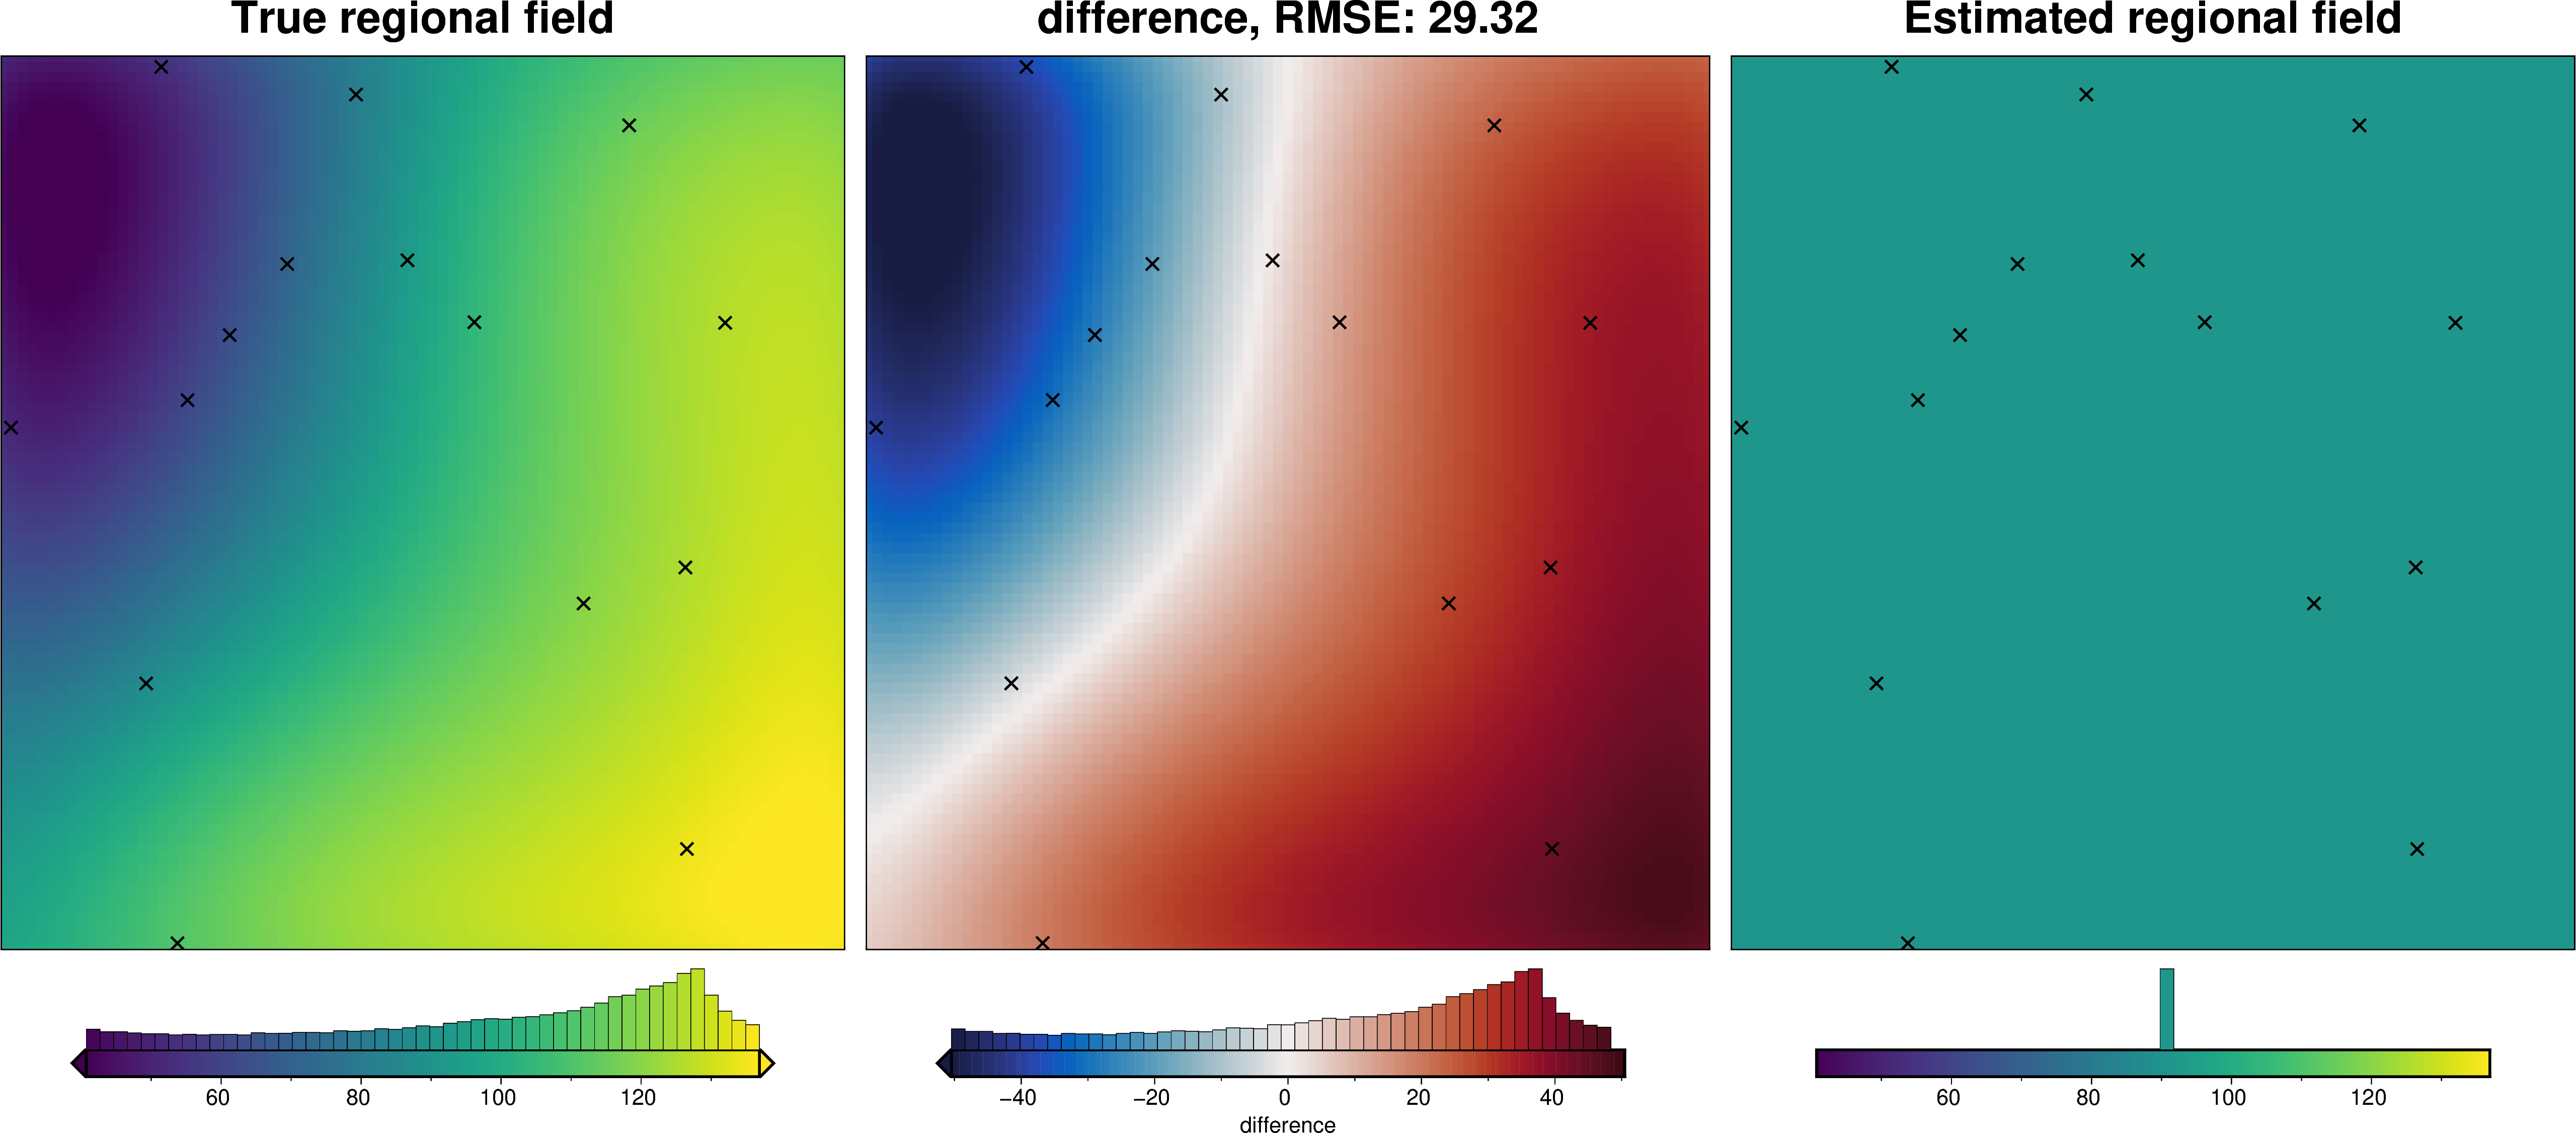

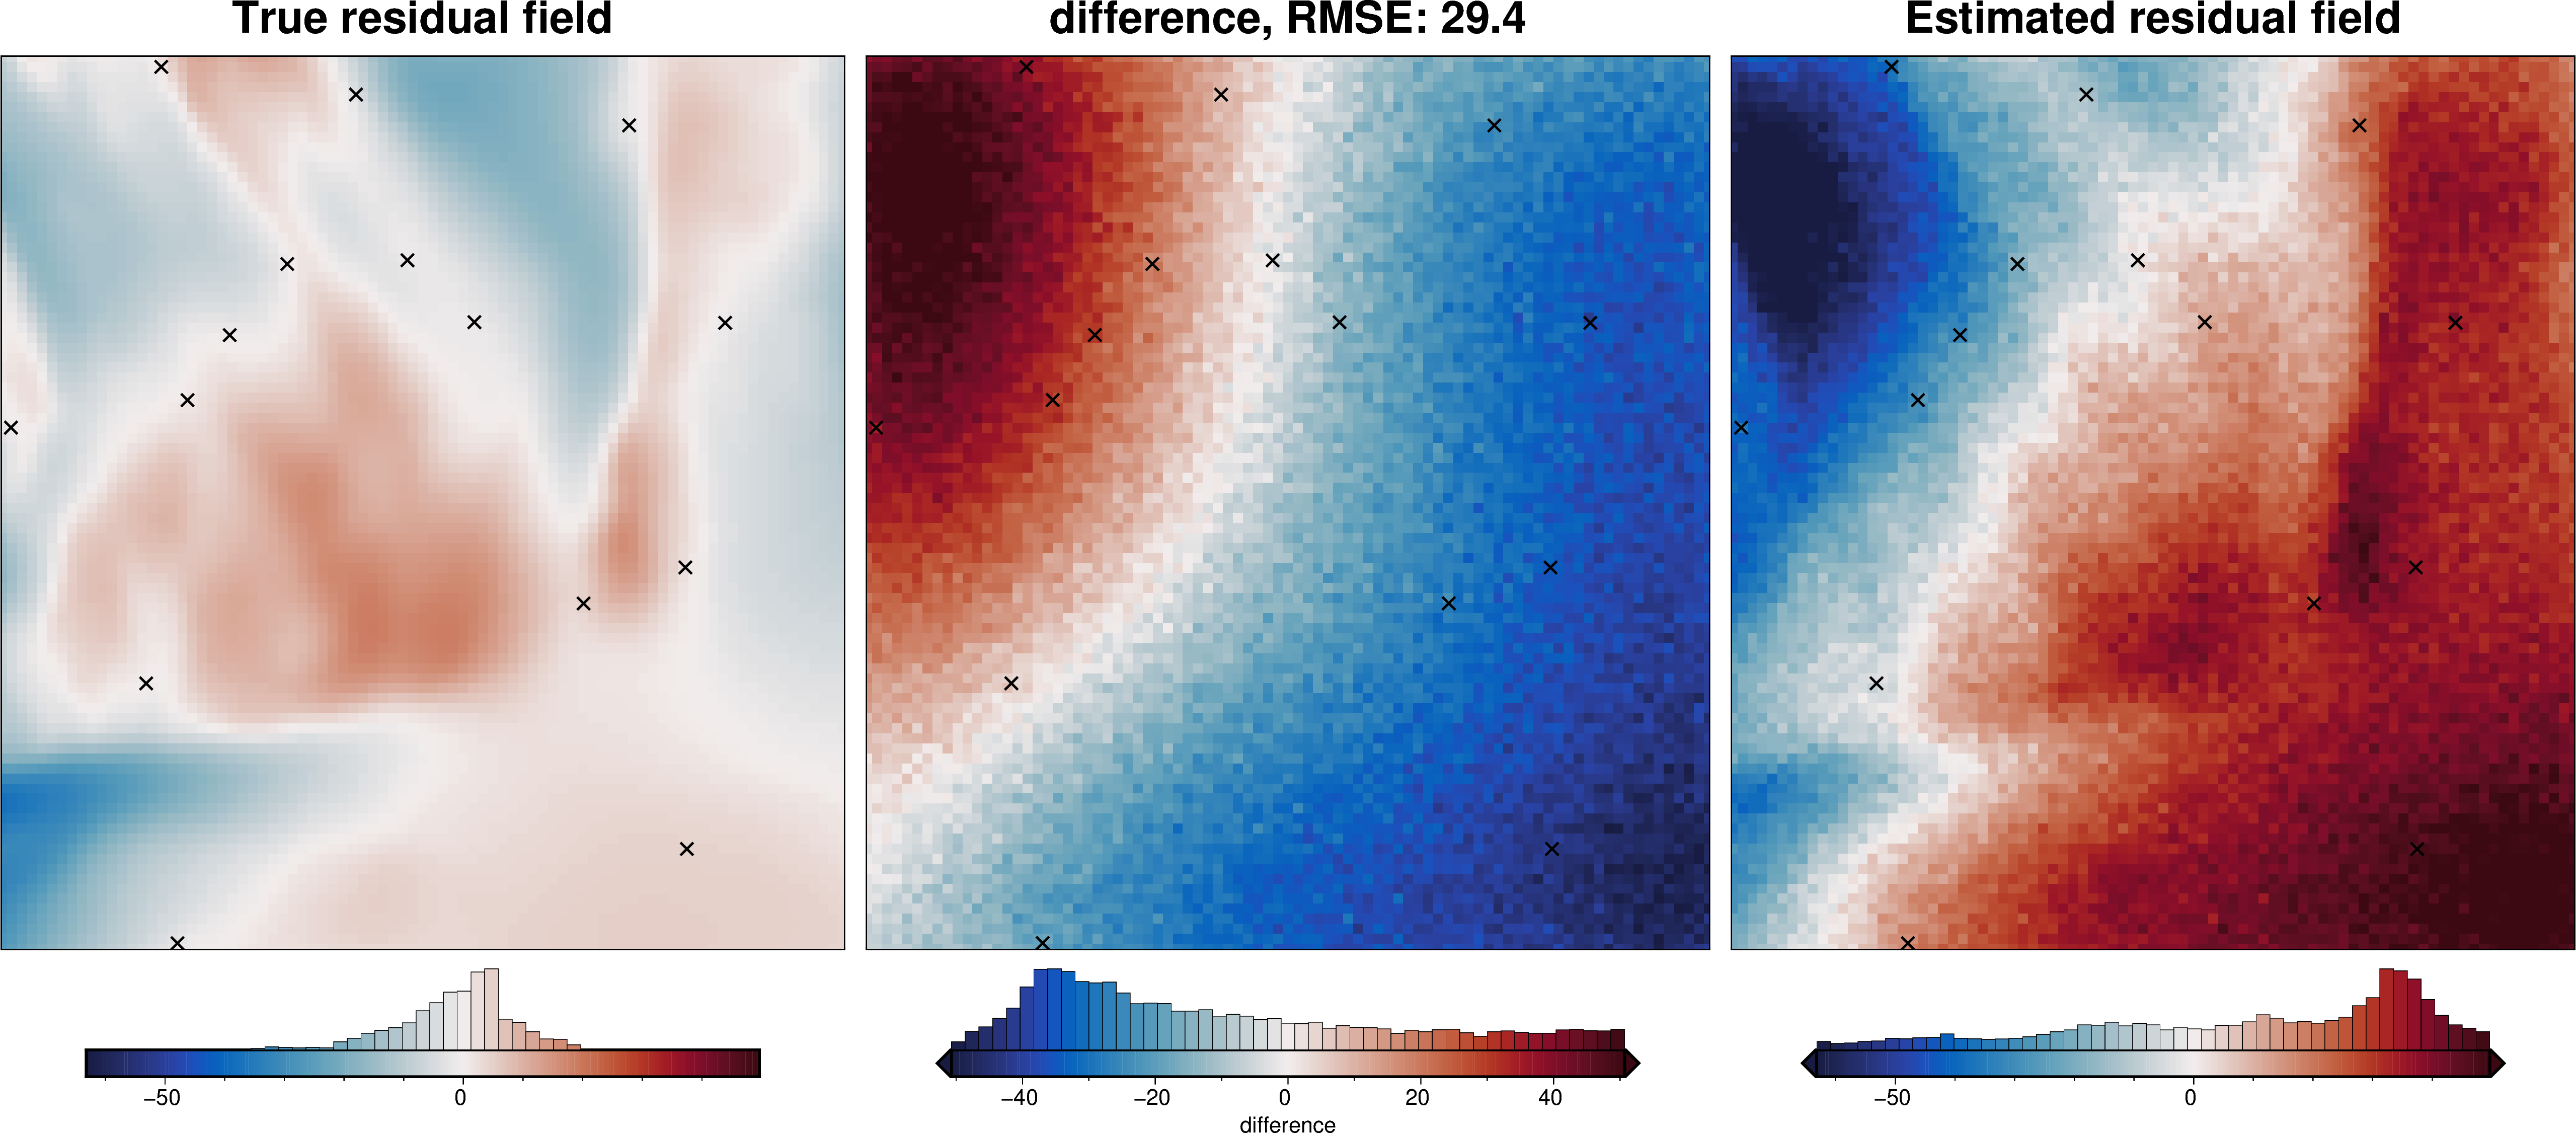

gravity_anomaly     misfit        reg        res
0        94.460183  70.812794  91.191699 -20.378905
1        94.927666  72.456090  91.191699 -18.735609
2        97.785802  76.593996  91.191699 -14.597703
3        97.975486  78.126371  91.191699 -13.065328
4        97.758807  79.290784  91.191699 -11.900915

In [21]:
# estimate regional with the mean misfit at constraints
data.inv.regional_constant(
    constraints_df=constraint_points,
)
data["constant_reg"] = data.reg
data["constant_res"] = data.res

regional_comparison(data, "constant_reg")

data.inv.df[["gravity_anomaly", "misfit", "reg", "res"]].head()

#### 2) apply a custom constant value

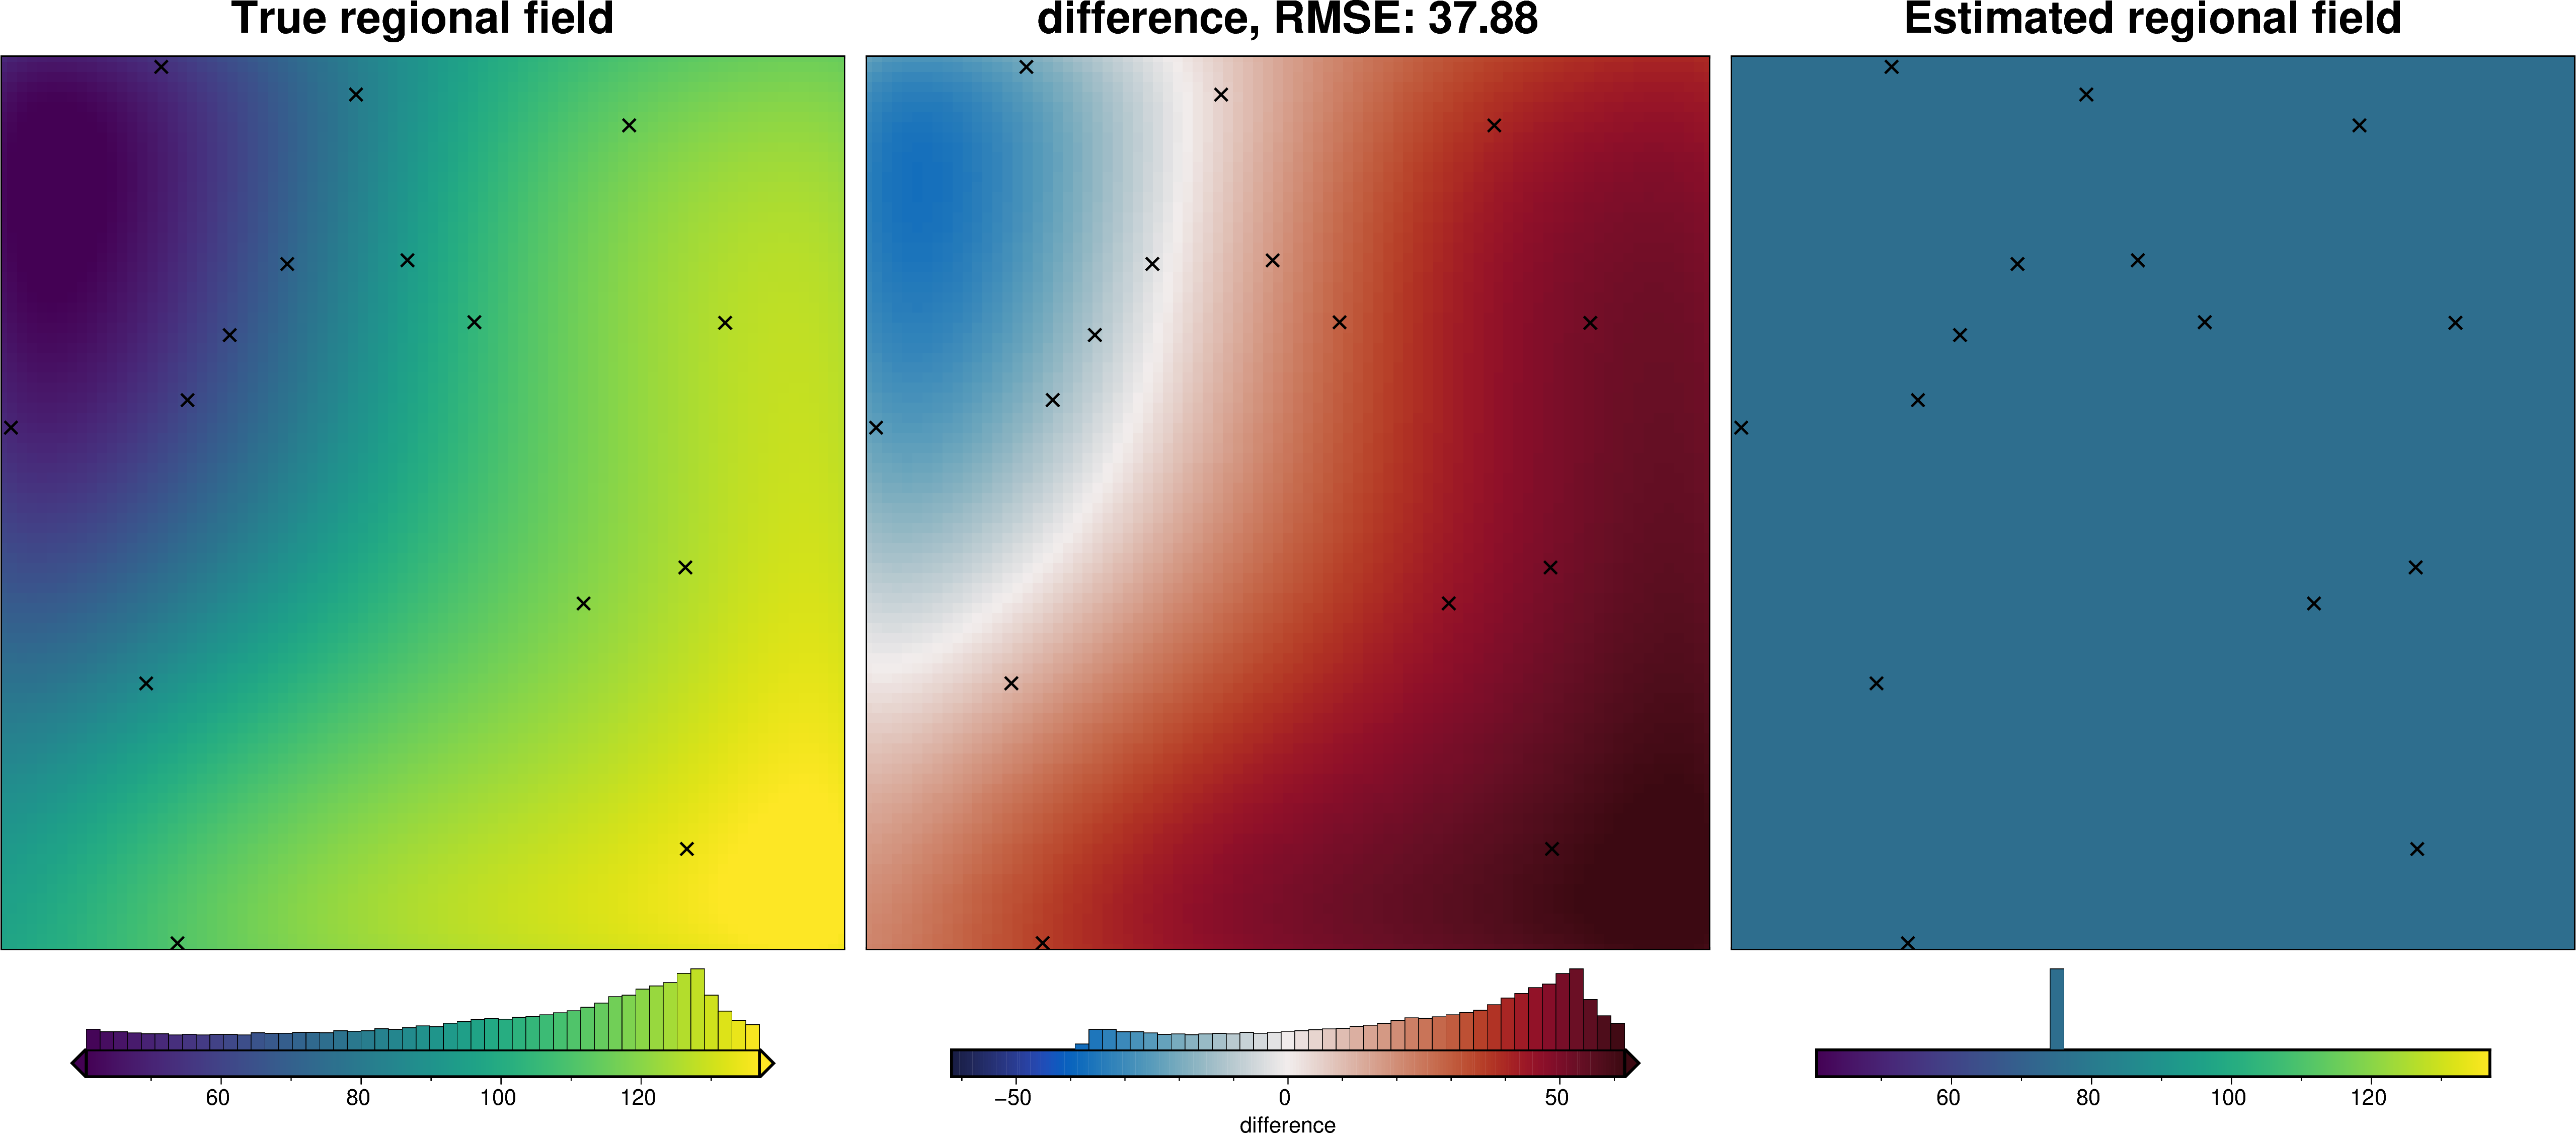

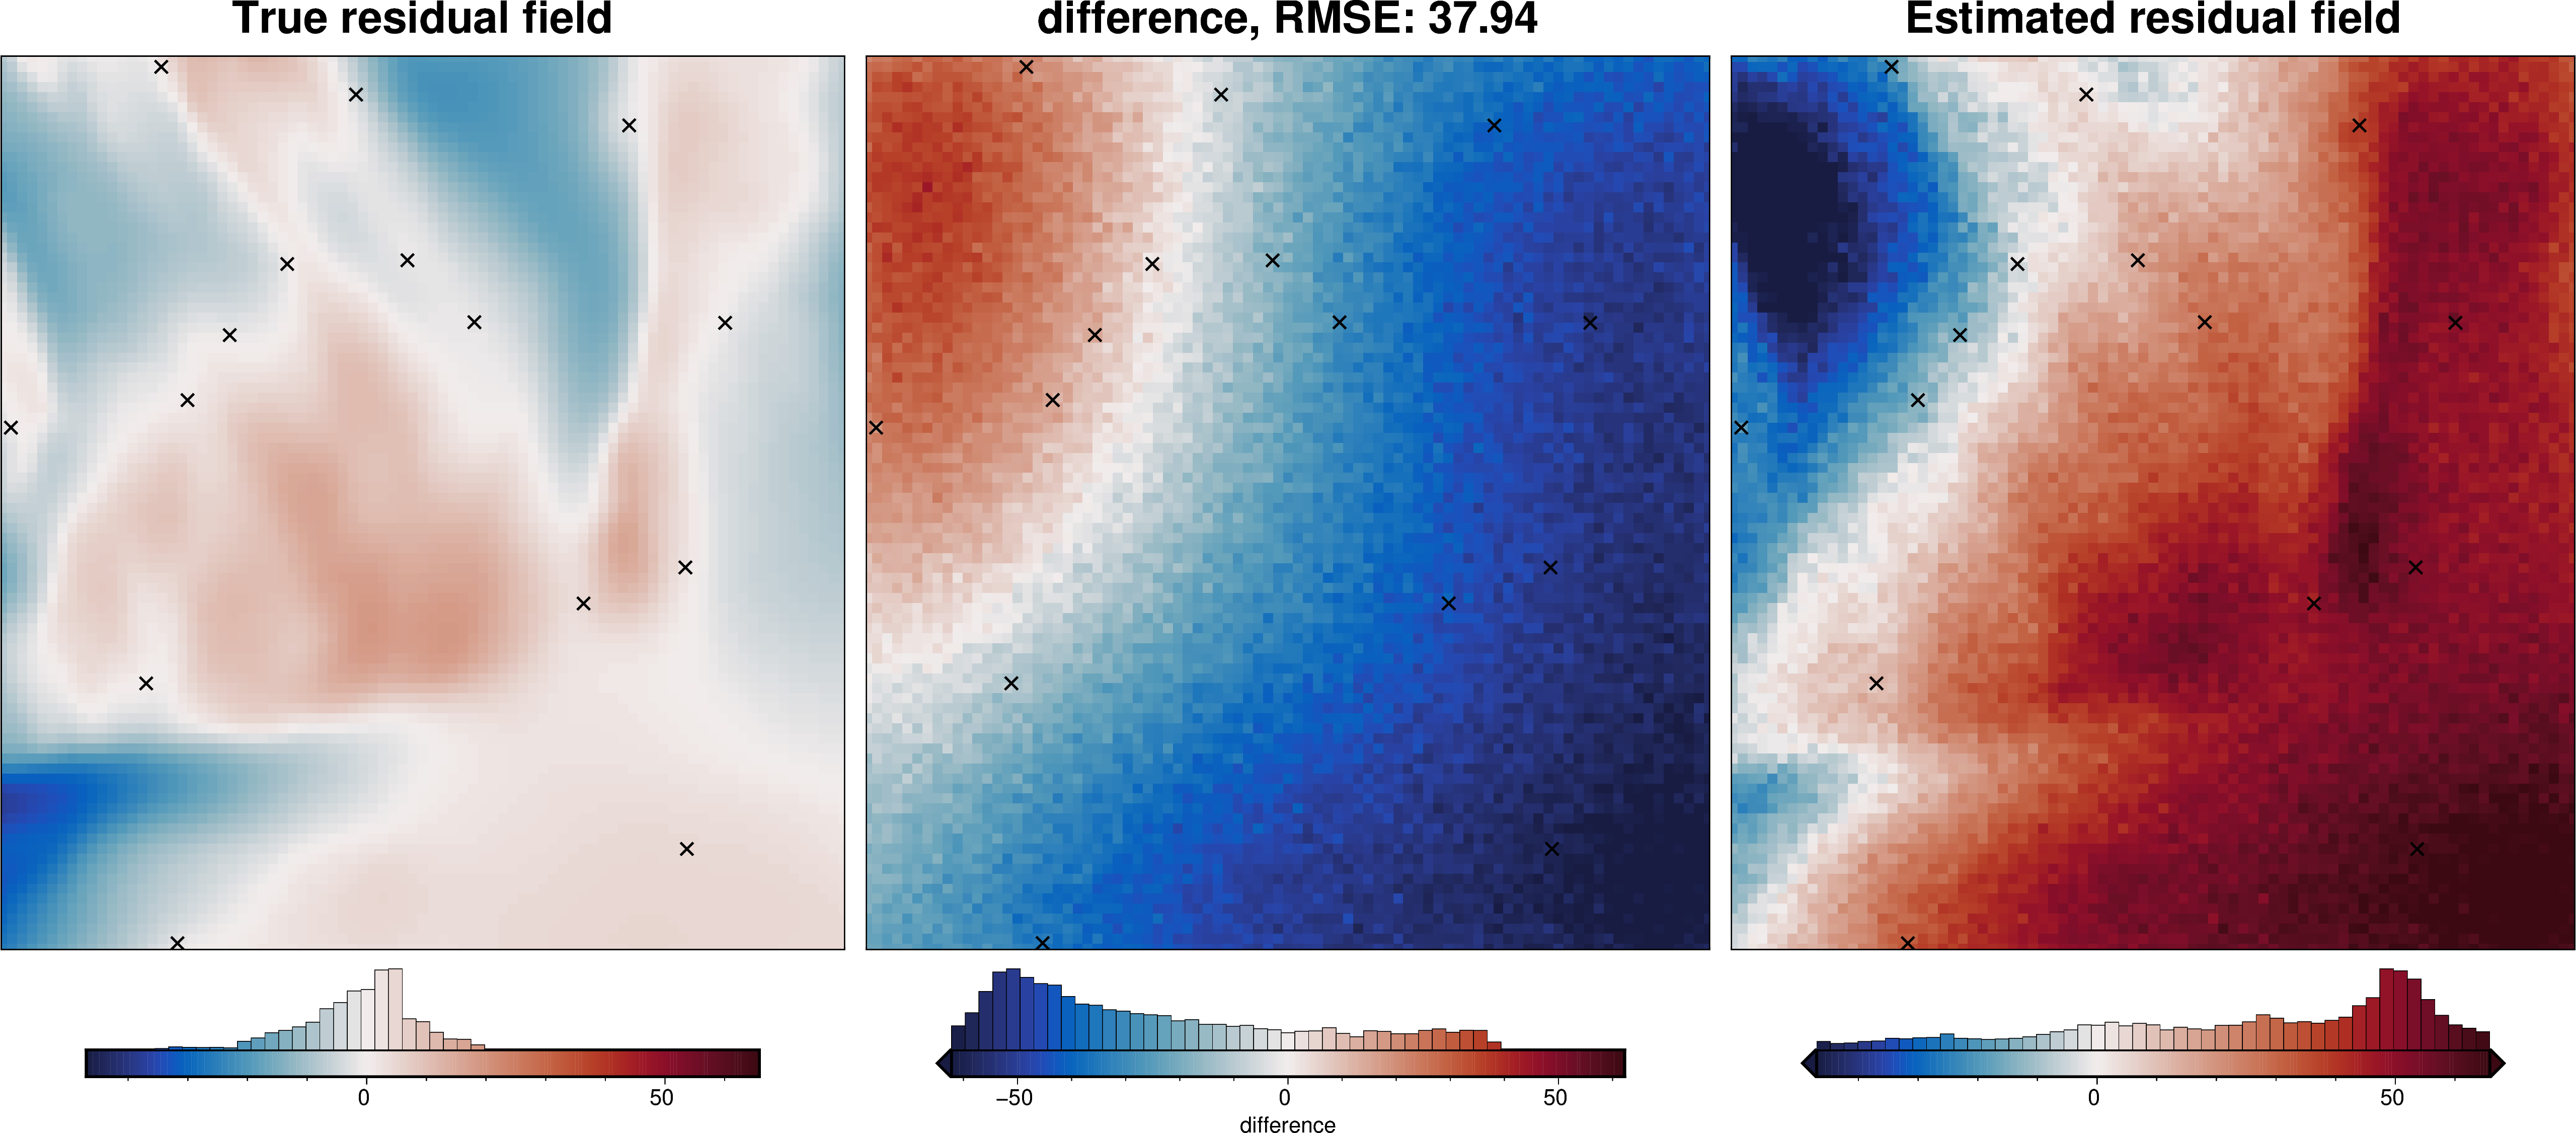

gravity_anomaly     misfit   reg       res
0        94.460183  70.812794  75.0 -4.187206
1        94.927666  72.456090  75.0 -2.543910
2        97.785802  76.593996  75.0  1.593996
3        97.975486  78.126371  75.0  3.126371
4        97.758807  79.290784  75.0  4.290784

In [22]:
# estimate regional with the custom constant value
data.inv.regional_constant(
    constant=75,
)
data["constant_custom_reg"] = data.reg
data["constant_custom_res"] = data.res

regional_comparison(data, "constant_custom_reg")

data.inv.df[["gravity_anomaly", "misfit", "reg", "res"]].head()

### Filter

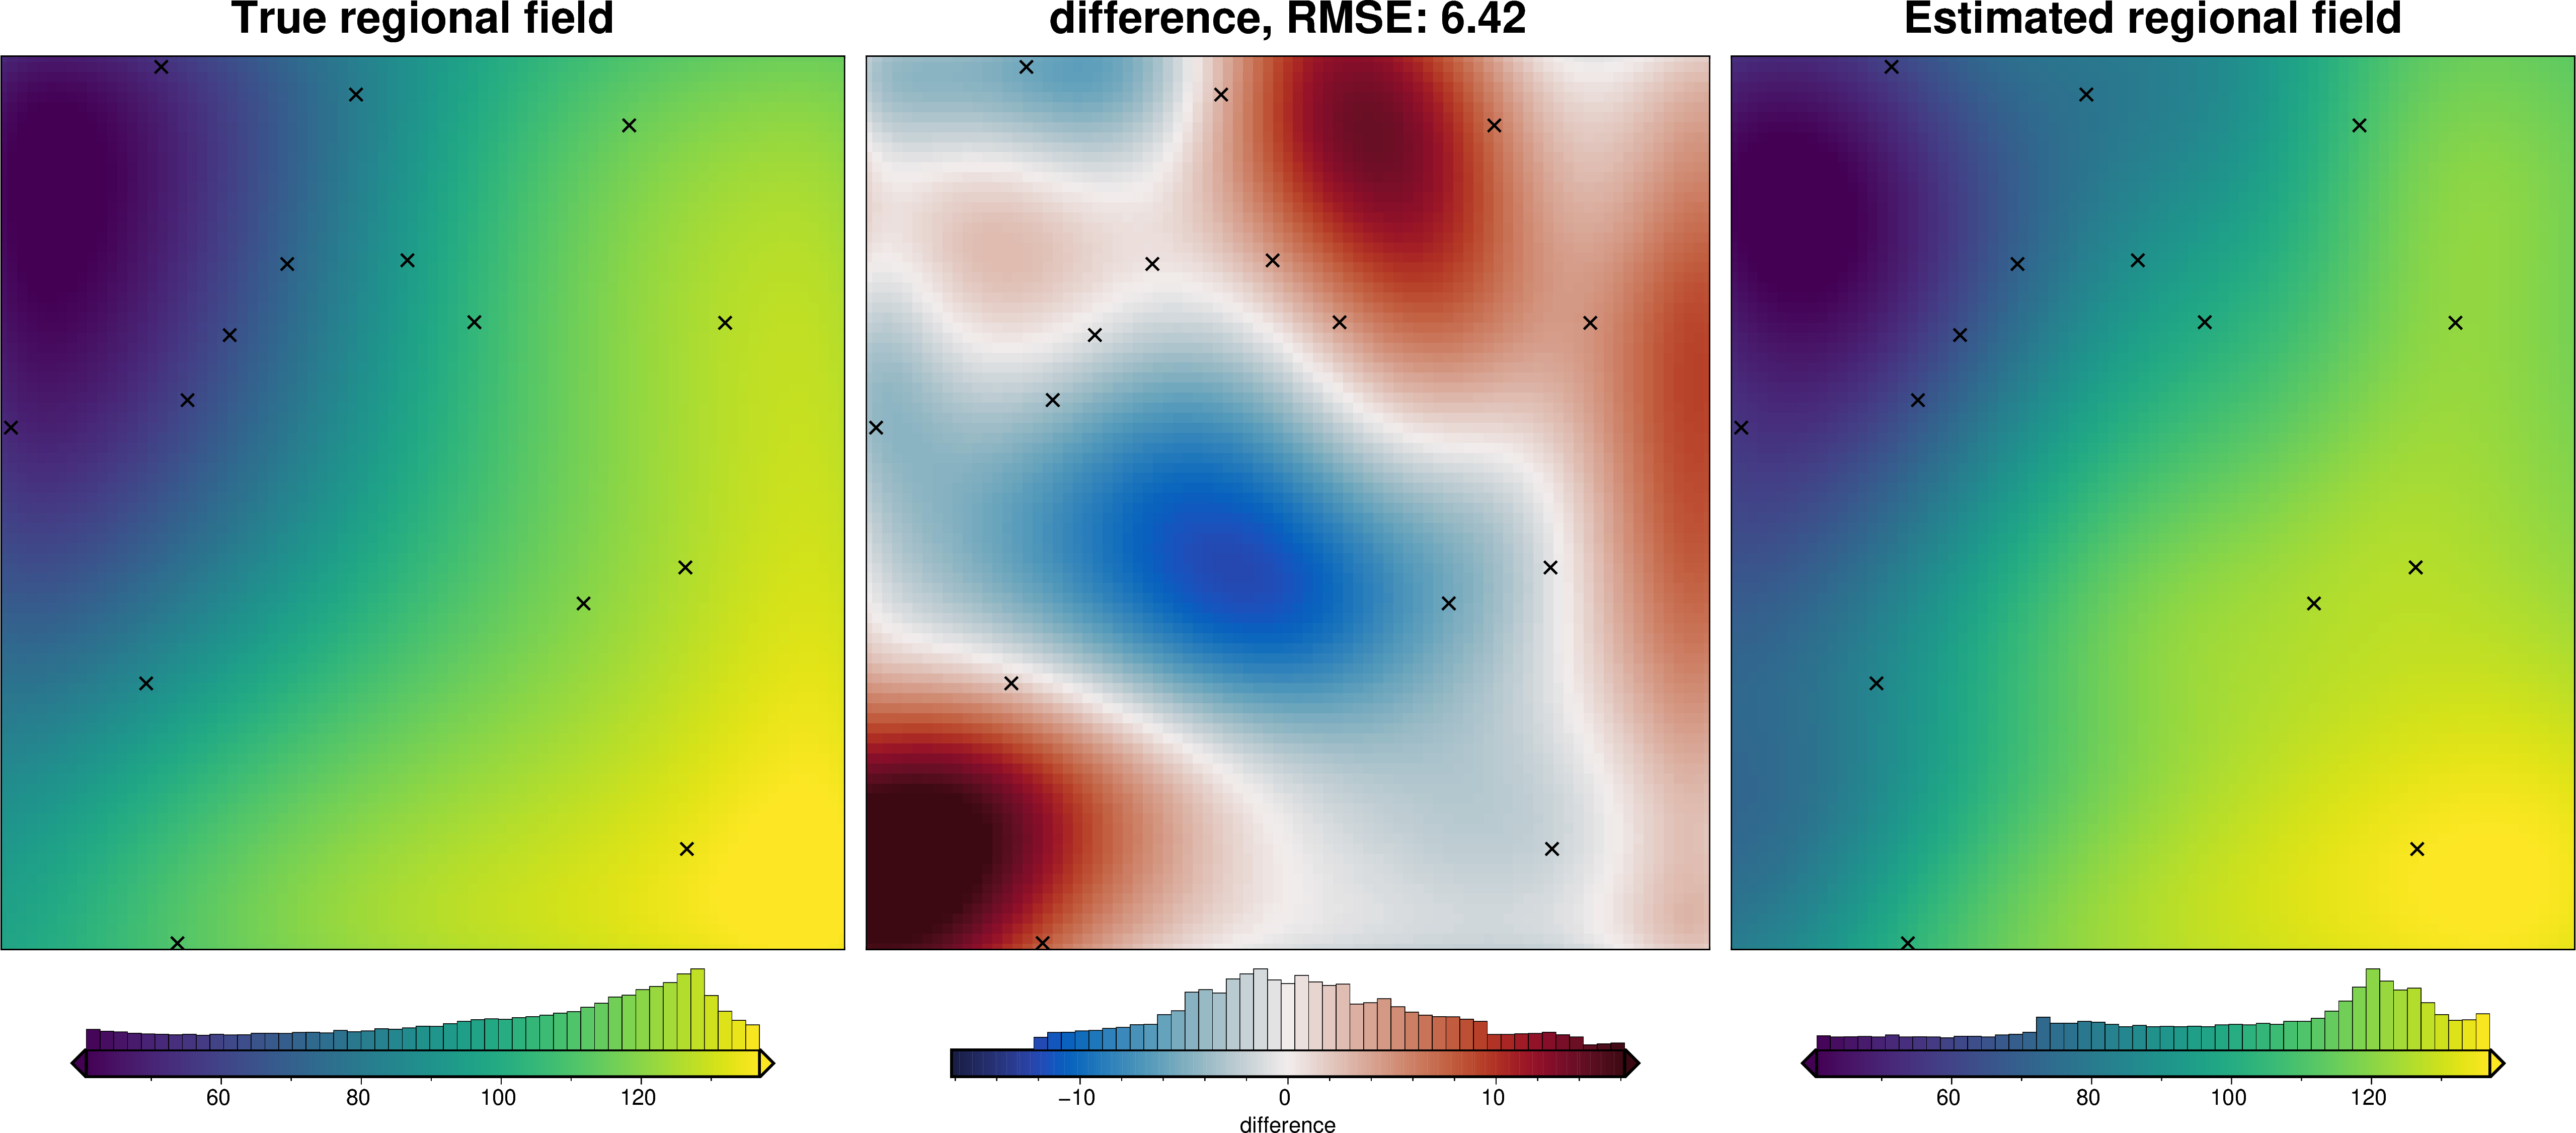

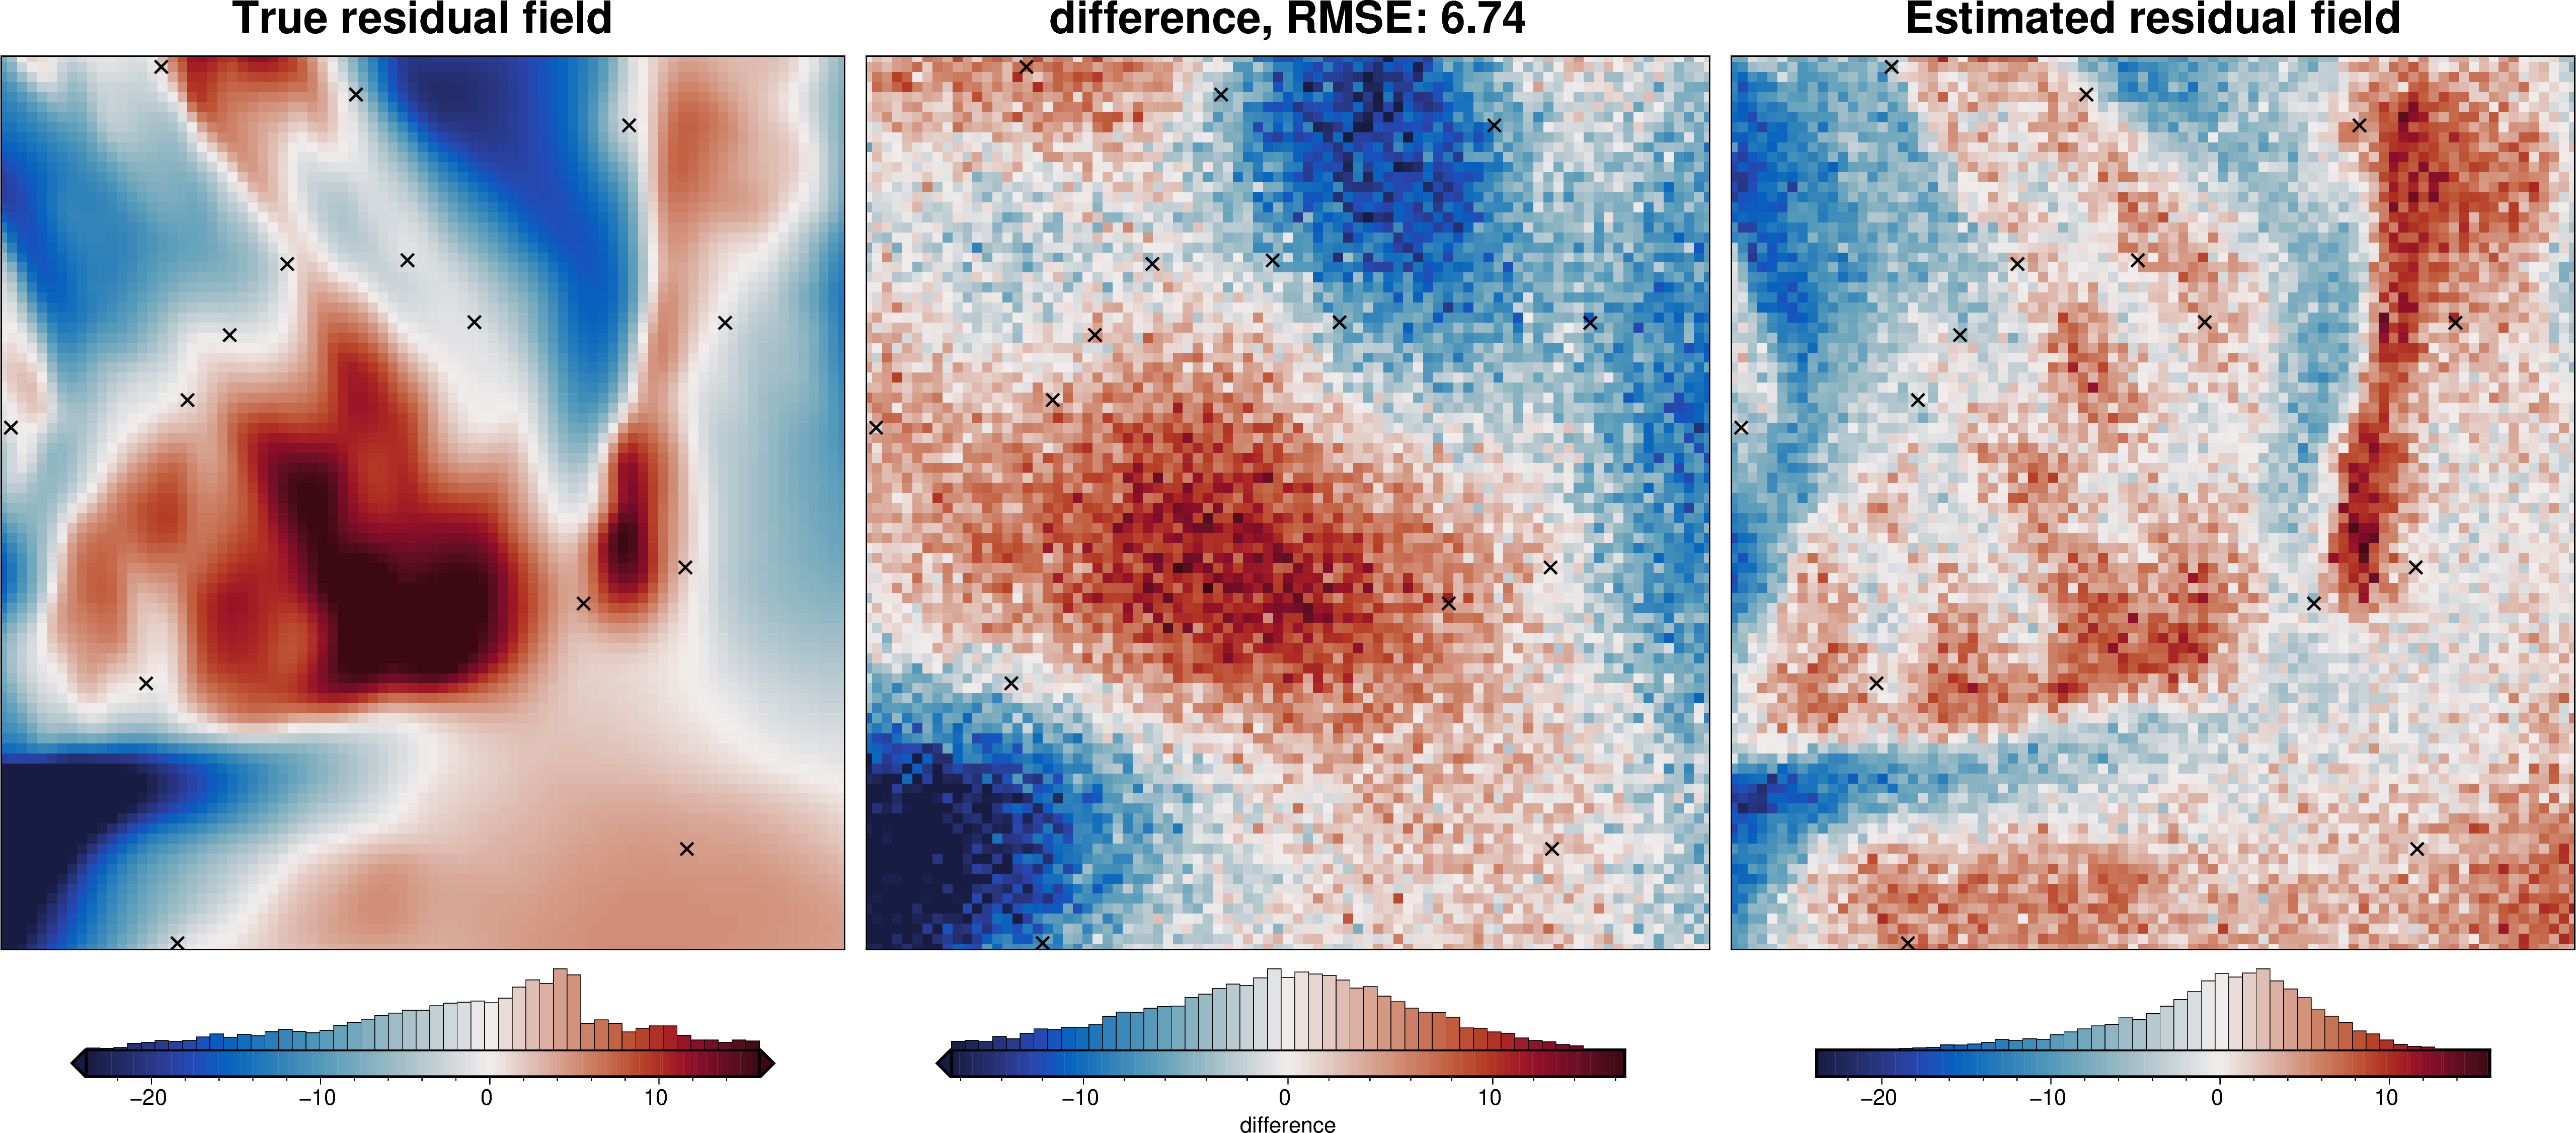

gravity_anomaly     misfit        reg        res
0        94.460183  70.812794  81.352826 -10.540032
1        94.927666  72.456090  81.764734  -9.308644
2        97.785802  76.593996  82.334142  -5.740146
3        97.975486  78.126371  83.055680  -4.929309
4        97.758807  79.290784  83.921333  -4.630550

In [23]:
# estimate regional with a 200km low pass filter
data.inv.regional_filter(
    filter_width=200e3,
)
data["filter_reg"] = data.reg
data["filter_res"] = data.res

regional_comparison(data, "filter_reg")

data.inv.df[["gravity_anomaly", "misfit", "reg", "res"]].head()

### Trend

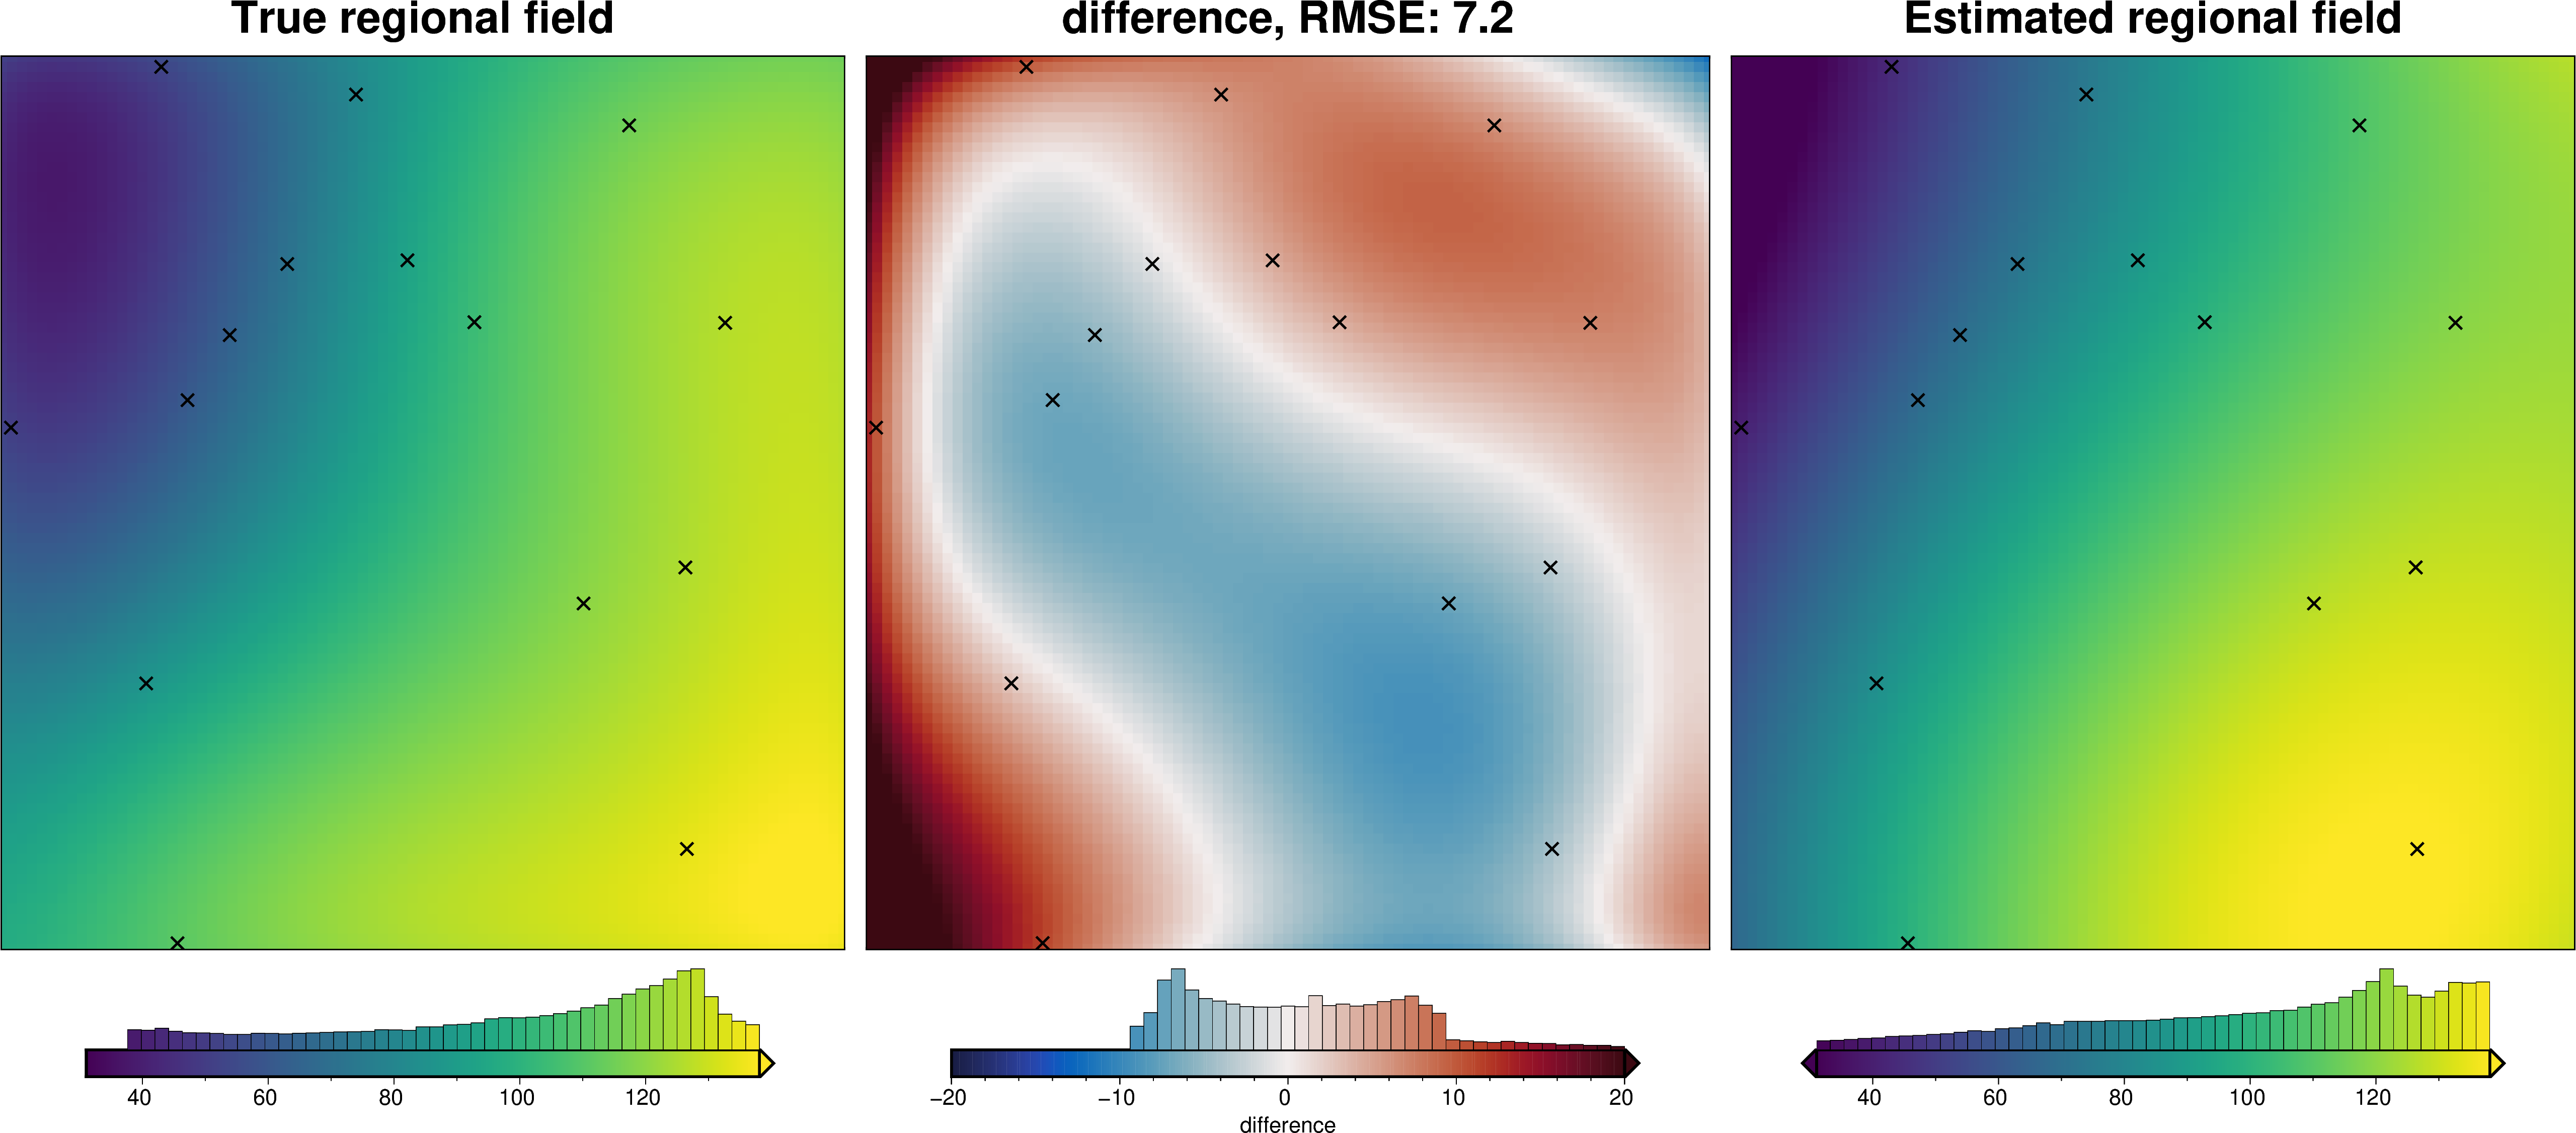

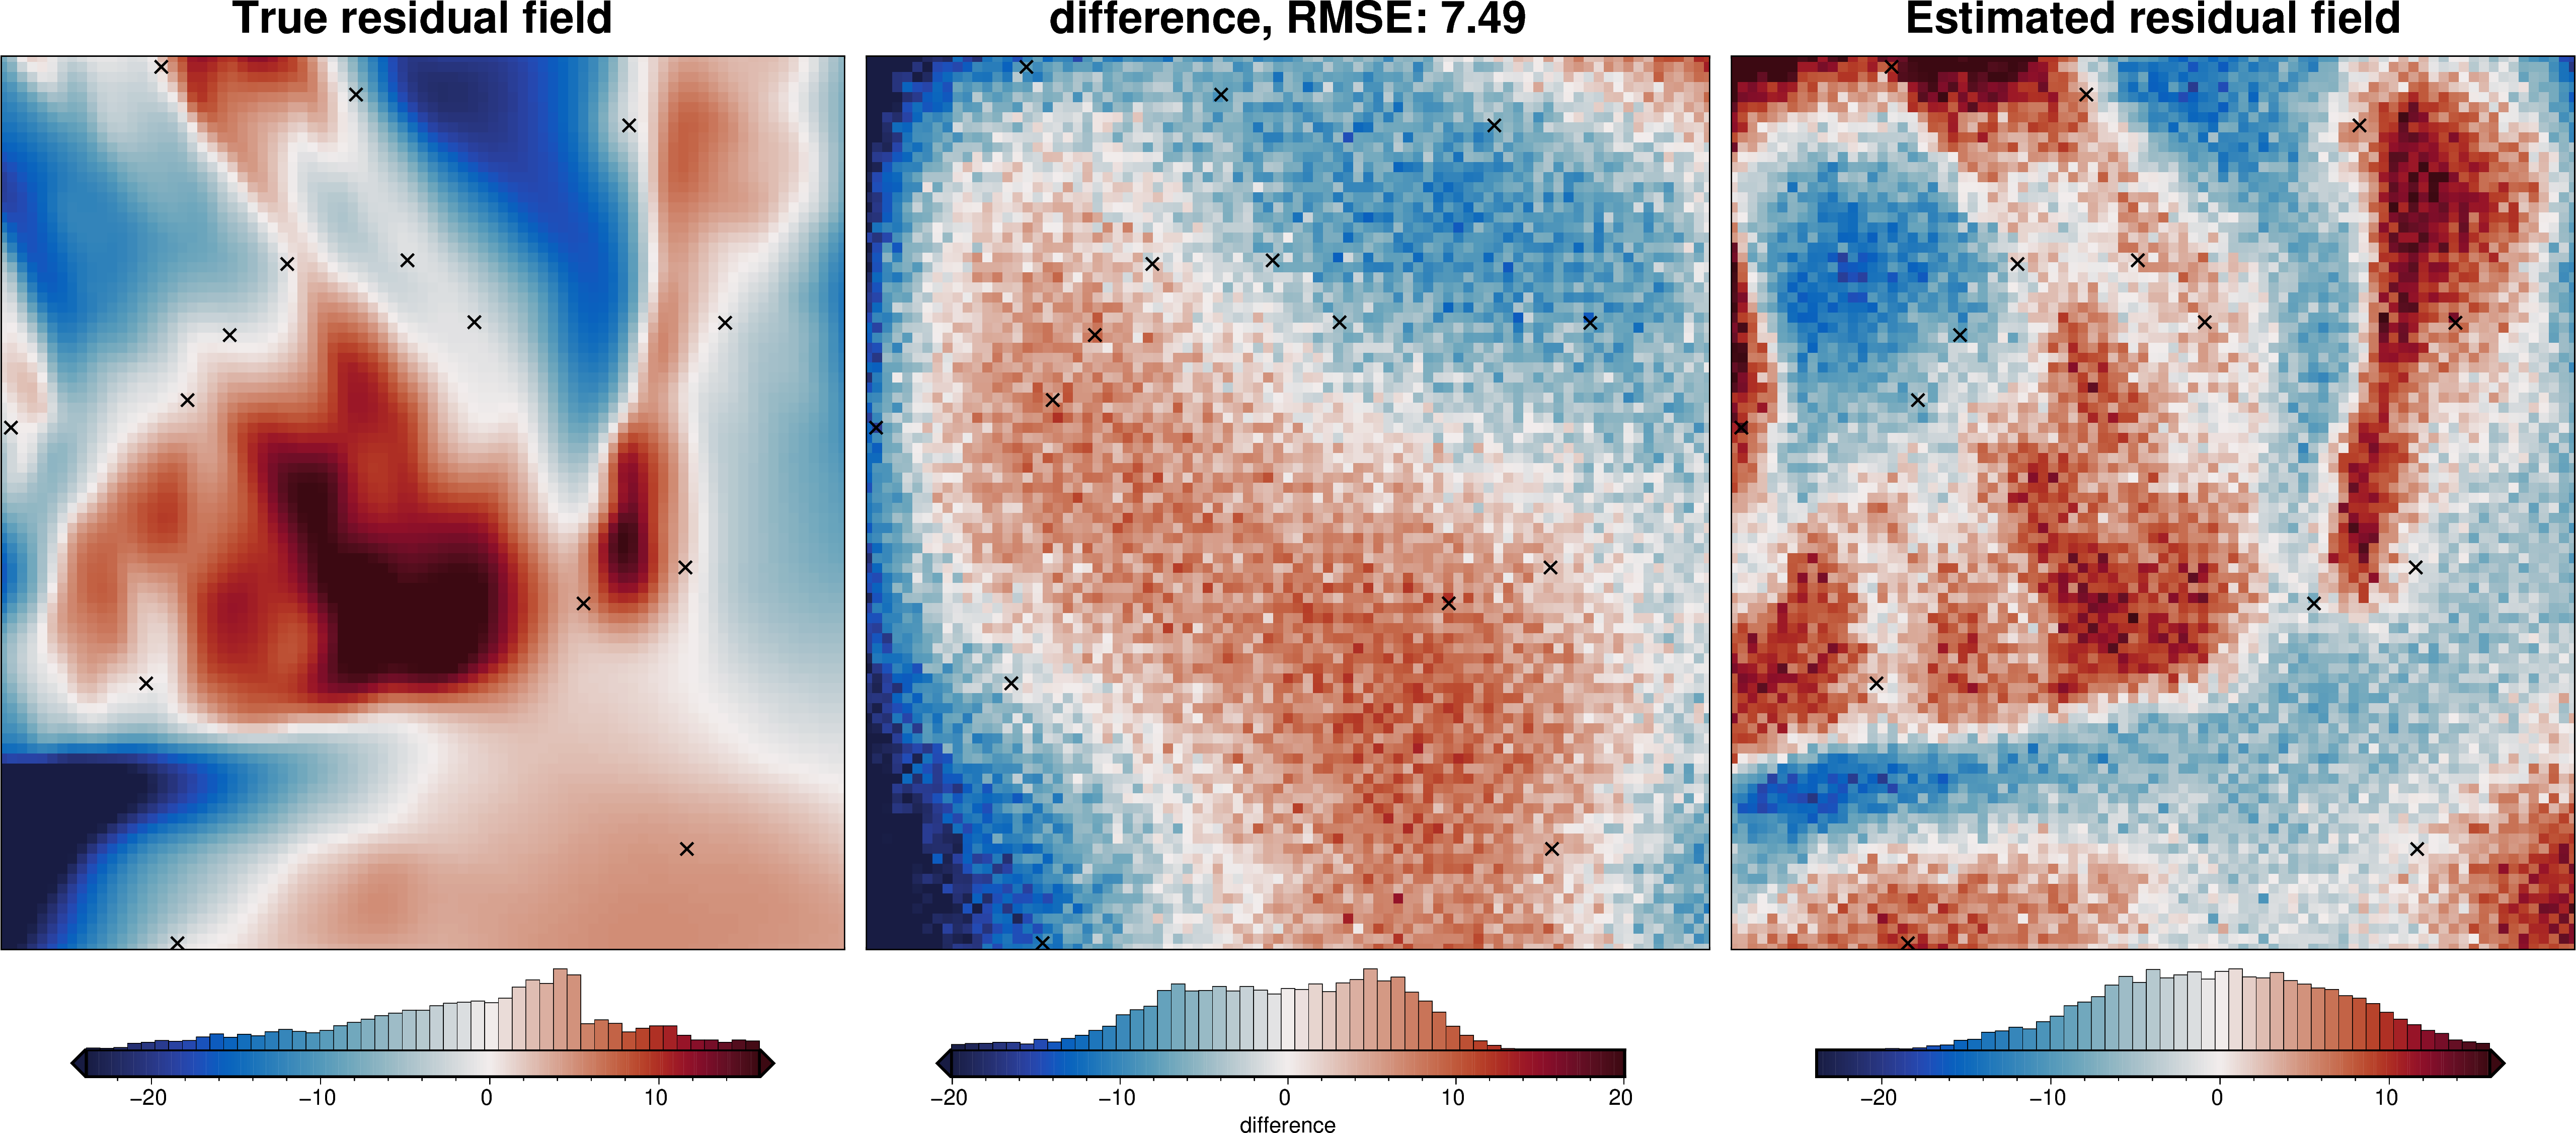

gravity_anomaly     misfit        reg       res
0        94.460183  70.812794  66.726353  4.086441
1        94.927666  72.456090  68.802852  3.653238
2        97.785802  76.593996  70.854683  5.739312
3        97.975486  78.126371  72.881577  5.244794
4        97.758807  79.290784  74.883262  4.407521

In [24]:
# estimate regional with fitting a 3rd order trend
data.inv.regional_trend(
    trend=3,
)
data["trend_reg"] = data.reg
data["trend_res"] = data.res

regional_comparison(data, "trend_reg")

data.inv.df[["gravity_anomaly", "misfit", "reg", "res"]].head()

### Equivalent Sources

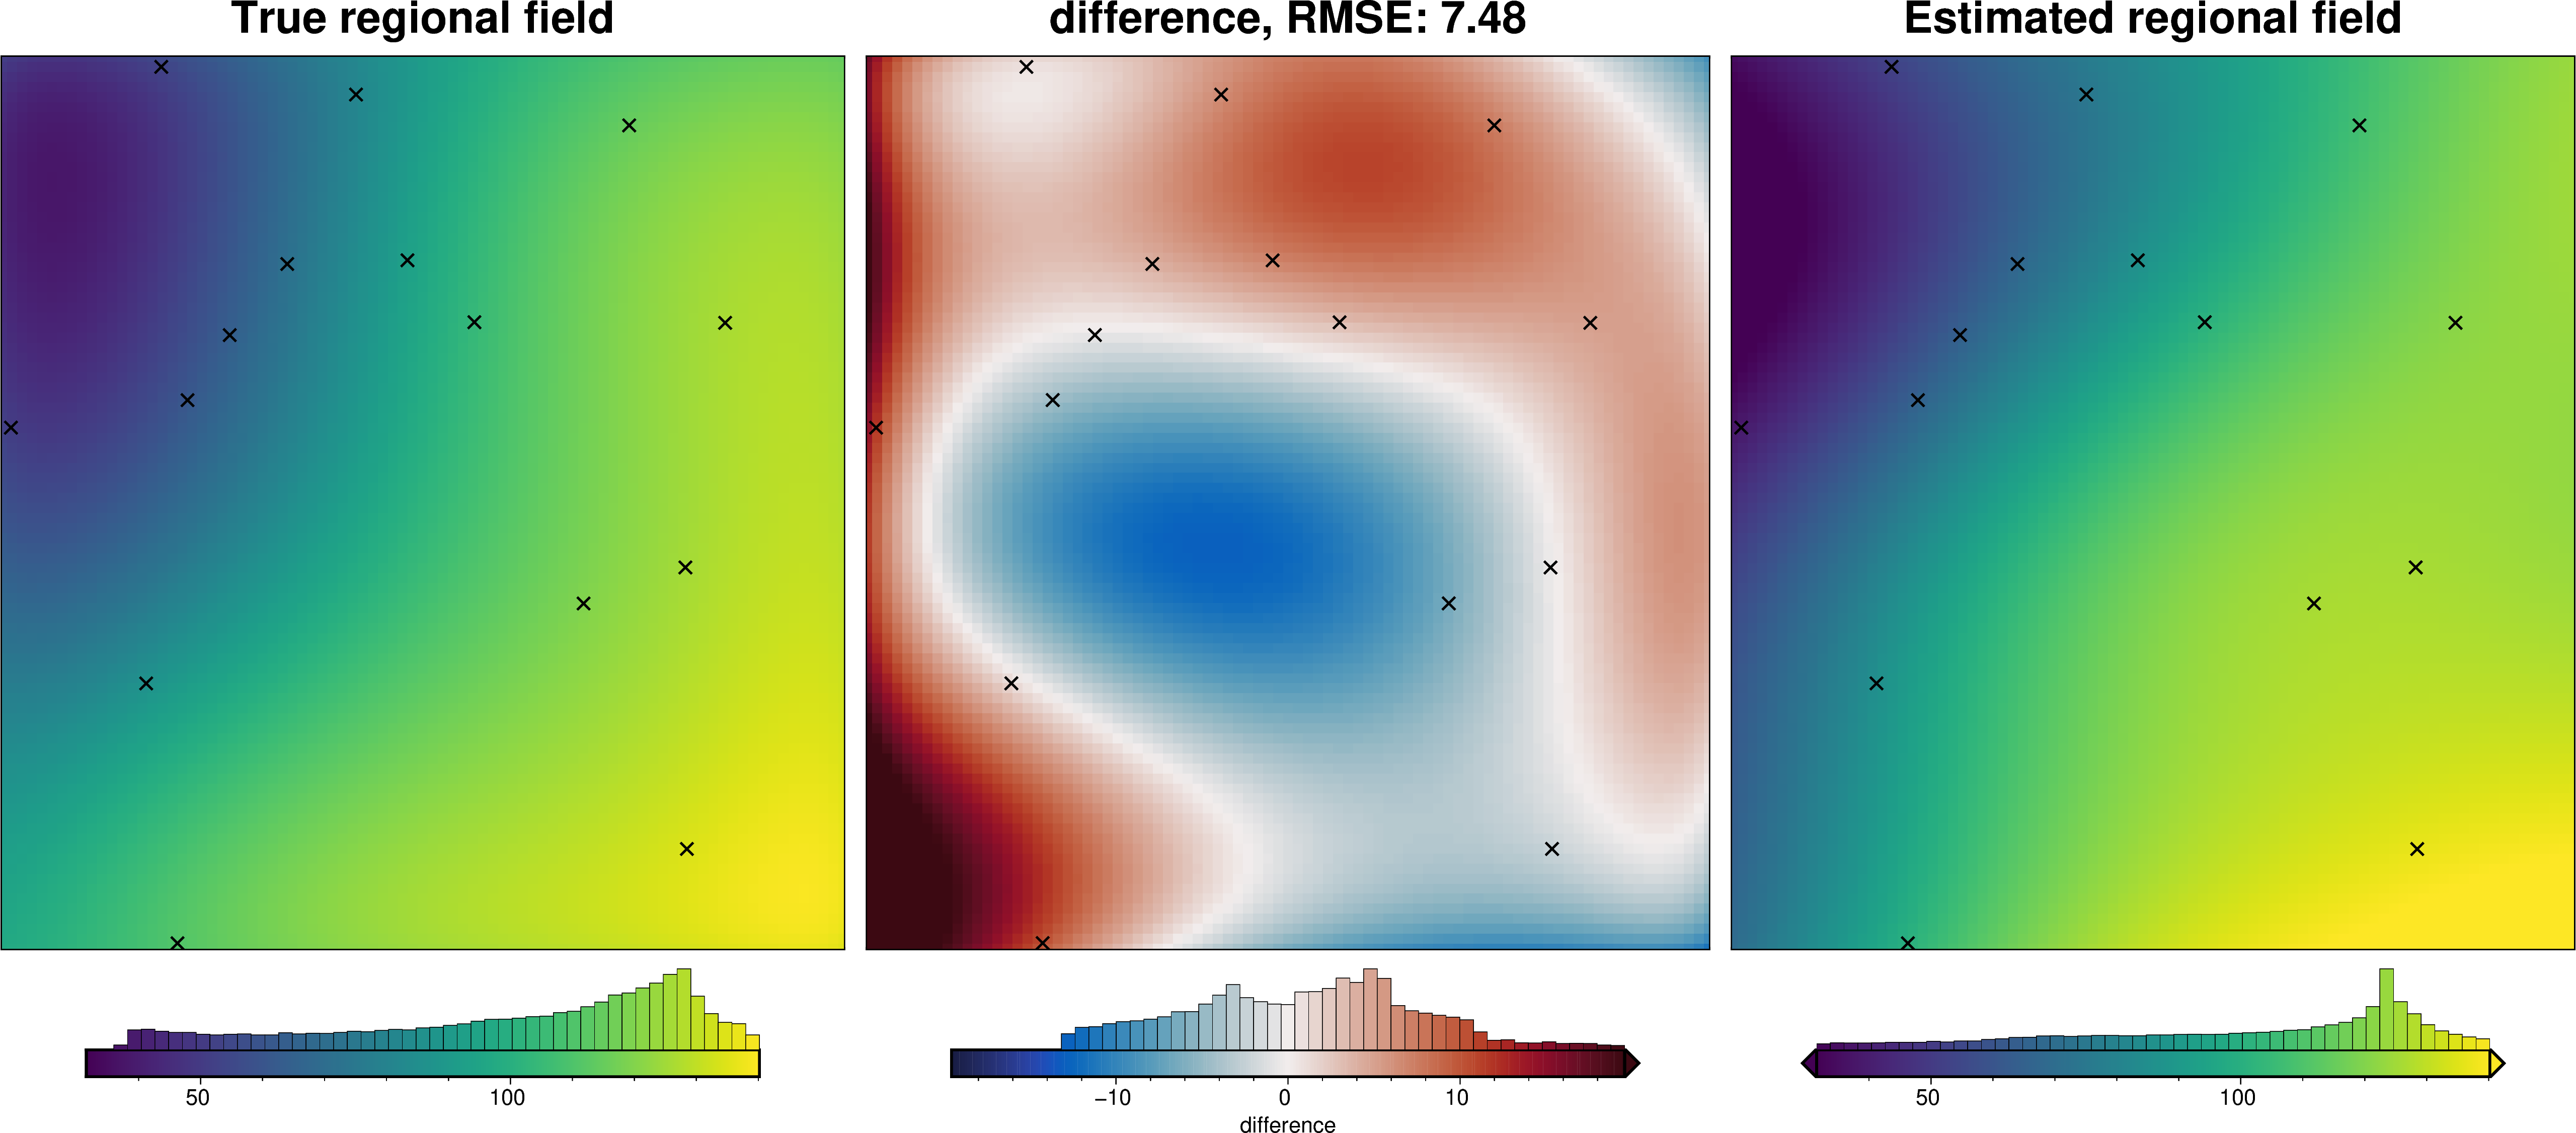

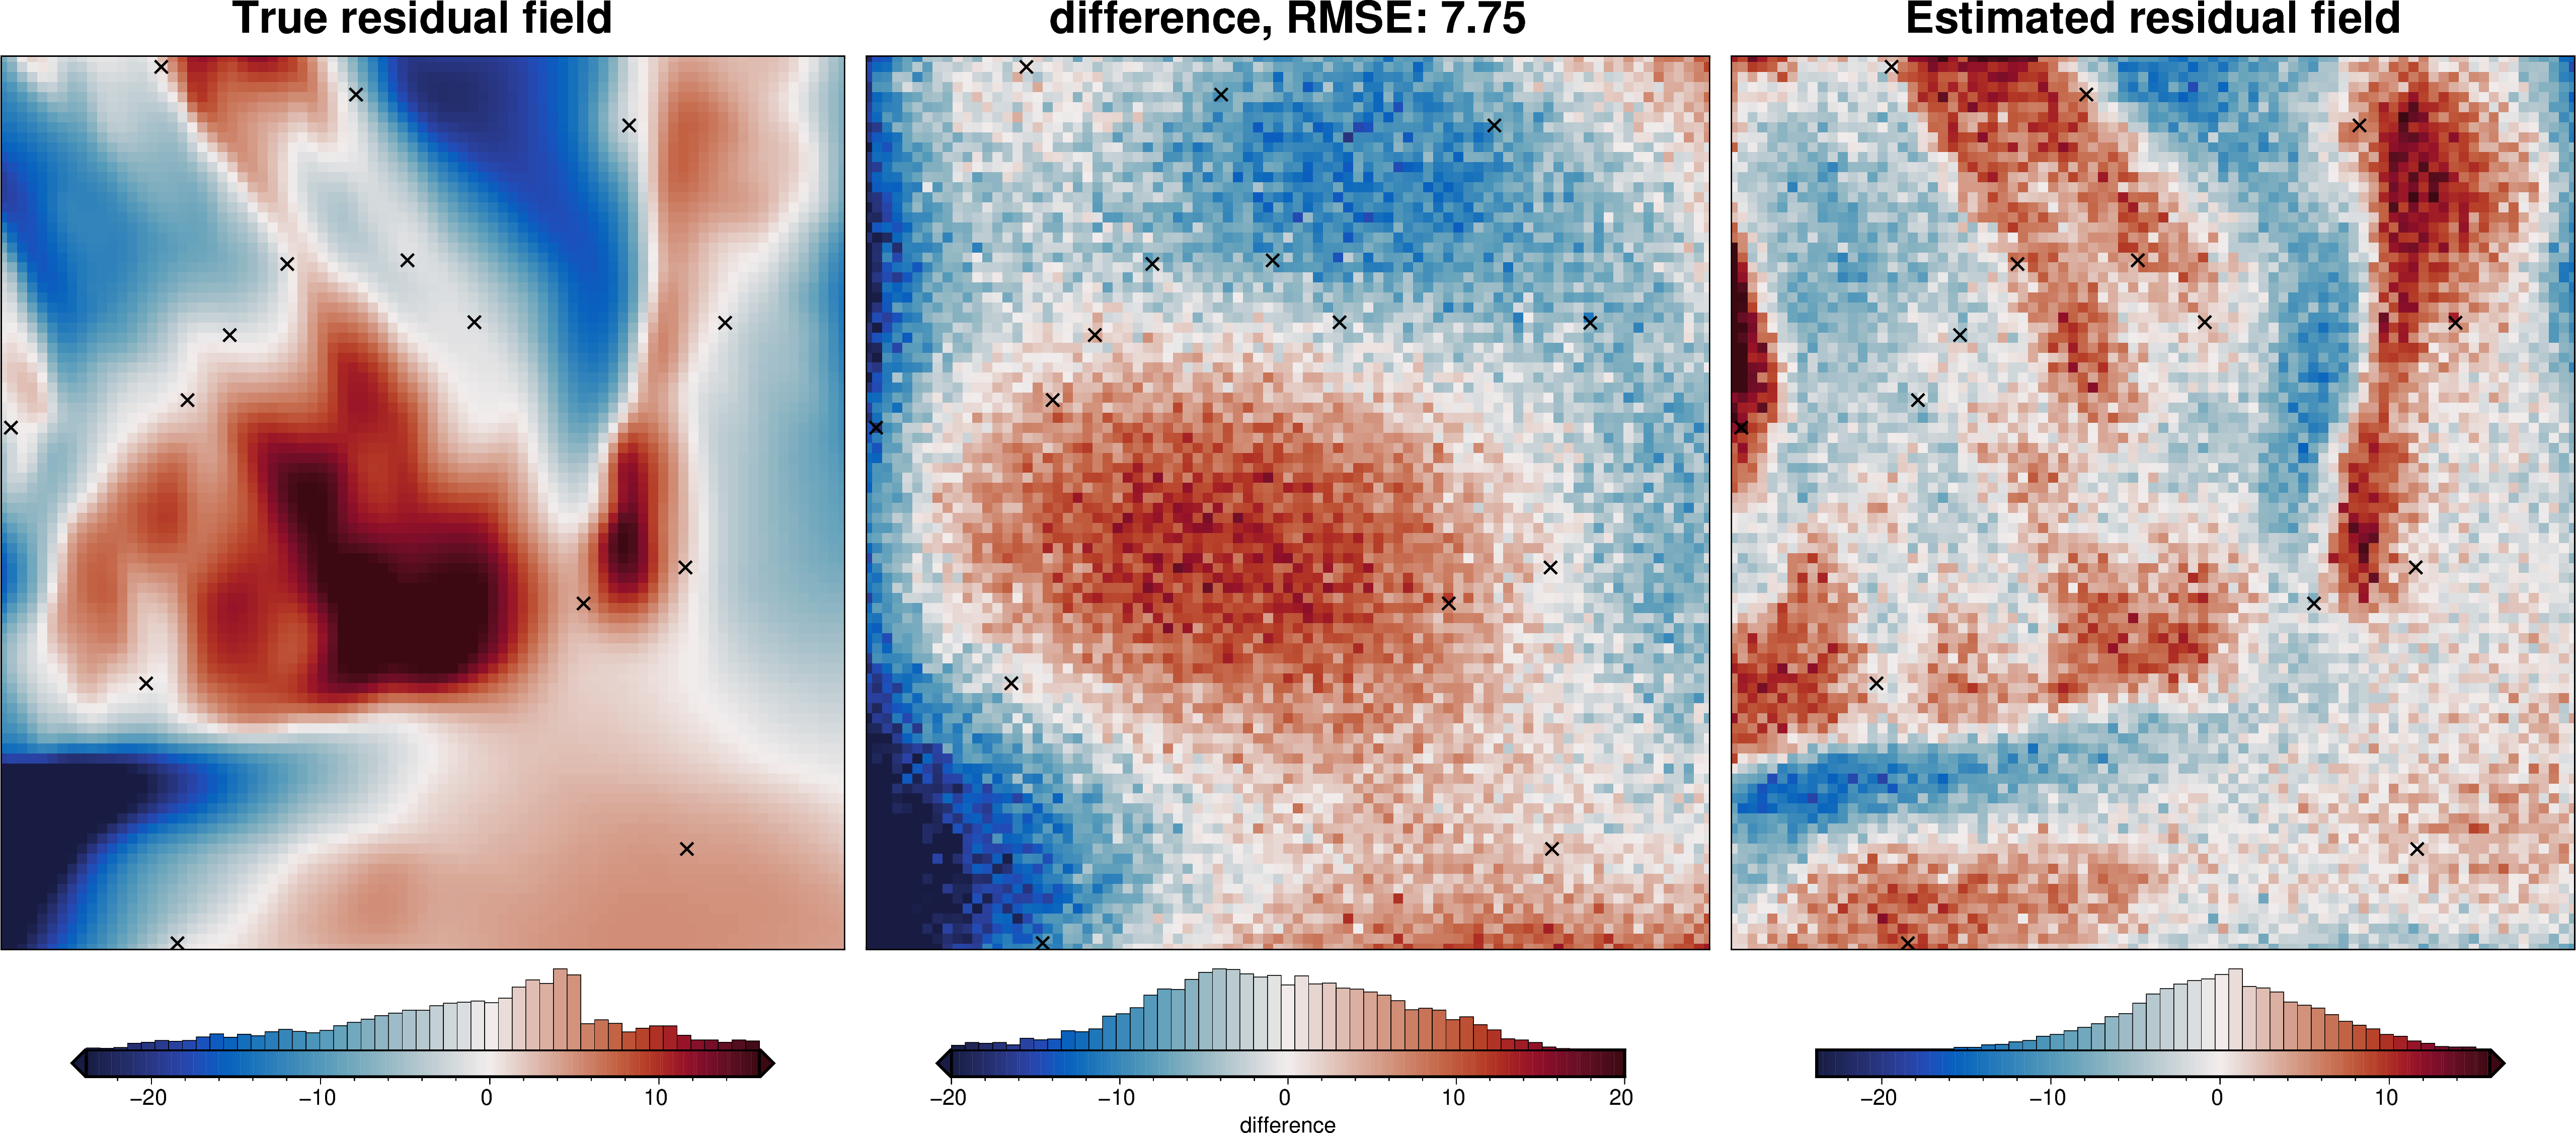

gravity_anomaly     misfit        reg       res
0        94.460183  70.812794  69.673004  1.139790
1        94.927666  72.456090  71.412164  1.043925
2        97.785802  76.593996  73.168601  3.425395
3        97.975486  78.126371  74.940069  3.186301
4        97.758807  79.290784  76.724228  2.566556

In [ ]:
# estimate regional with equivalent sources. This estimates the long-wavelength component
# by either
# 1) using deep sources (`depth` parameter)
# 2) upwards continuing the fitted data (`grav_obs_height` parameter)
# 3) apply damping to the fitting (`damping` parameter)
data.inv.regional_eq_sources(
    depth=300e3,
    damping=0.1,
    grav_obs_height=1.5e3,
    block_size=spacing * 10,
)
data["eq_sources_reg"] = data.reg
data["eq_sources_res"] = data.res

regional_comparison(data, "eq_sources_reg")

data.inv.df[["gravity_anomaly", "misfit", "reg", "res"]].head()

### Constraint point minimization

#### gridding with PyGMT and tension factors

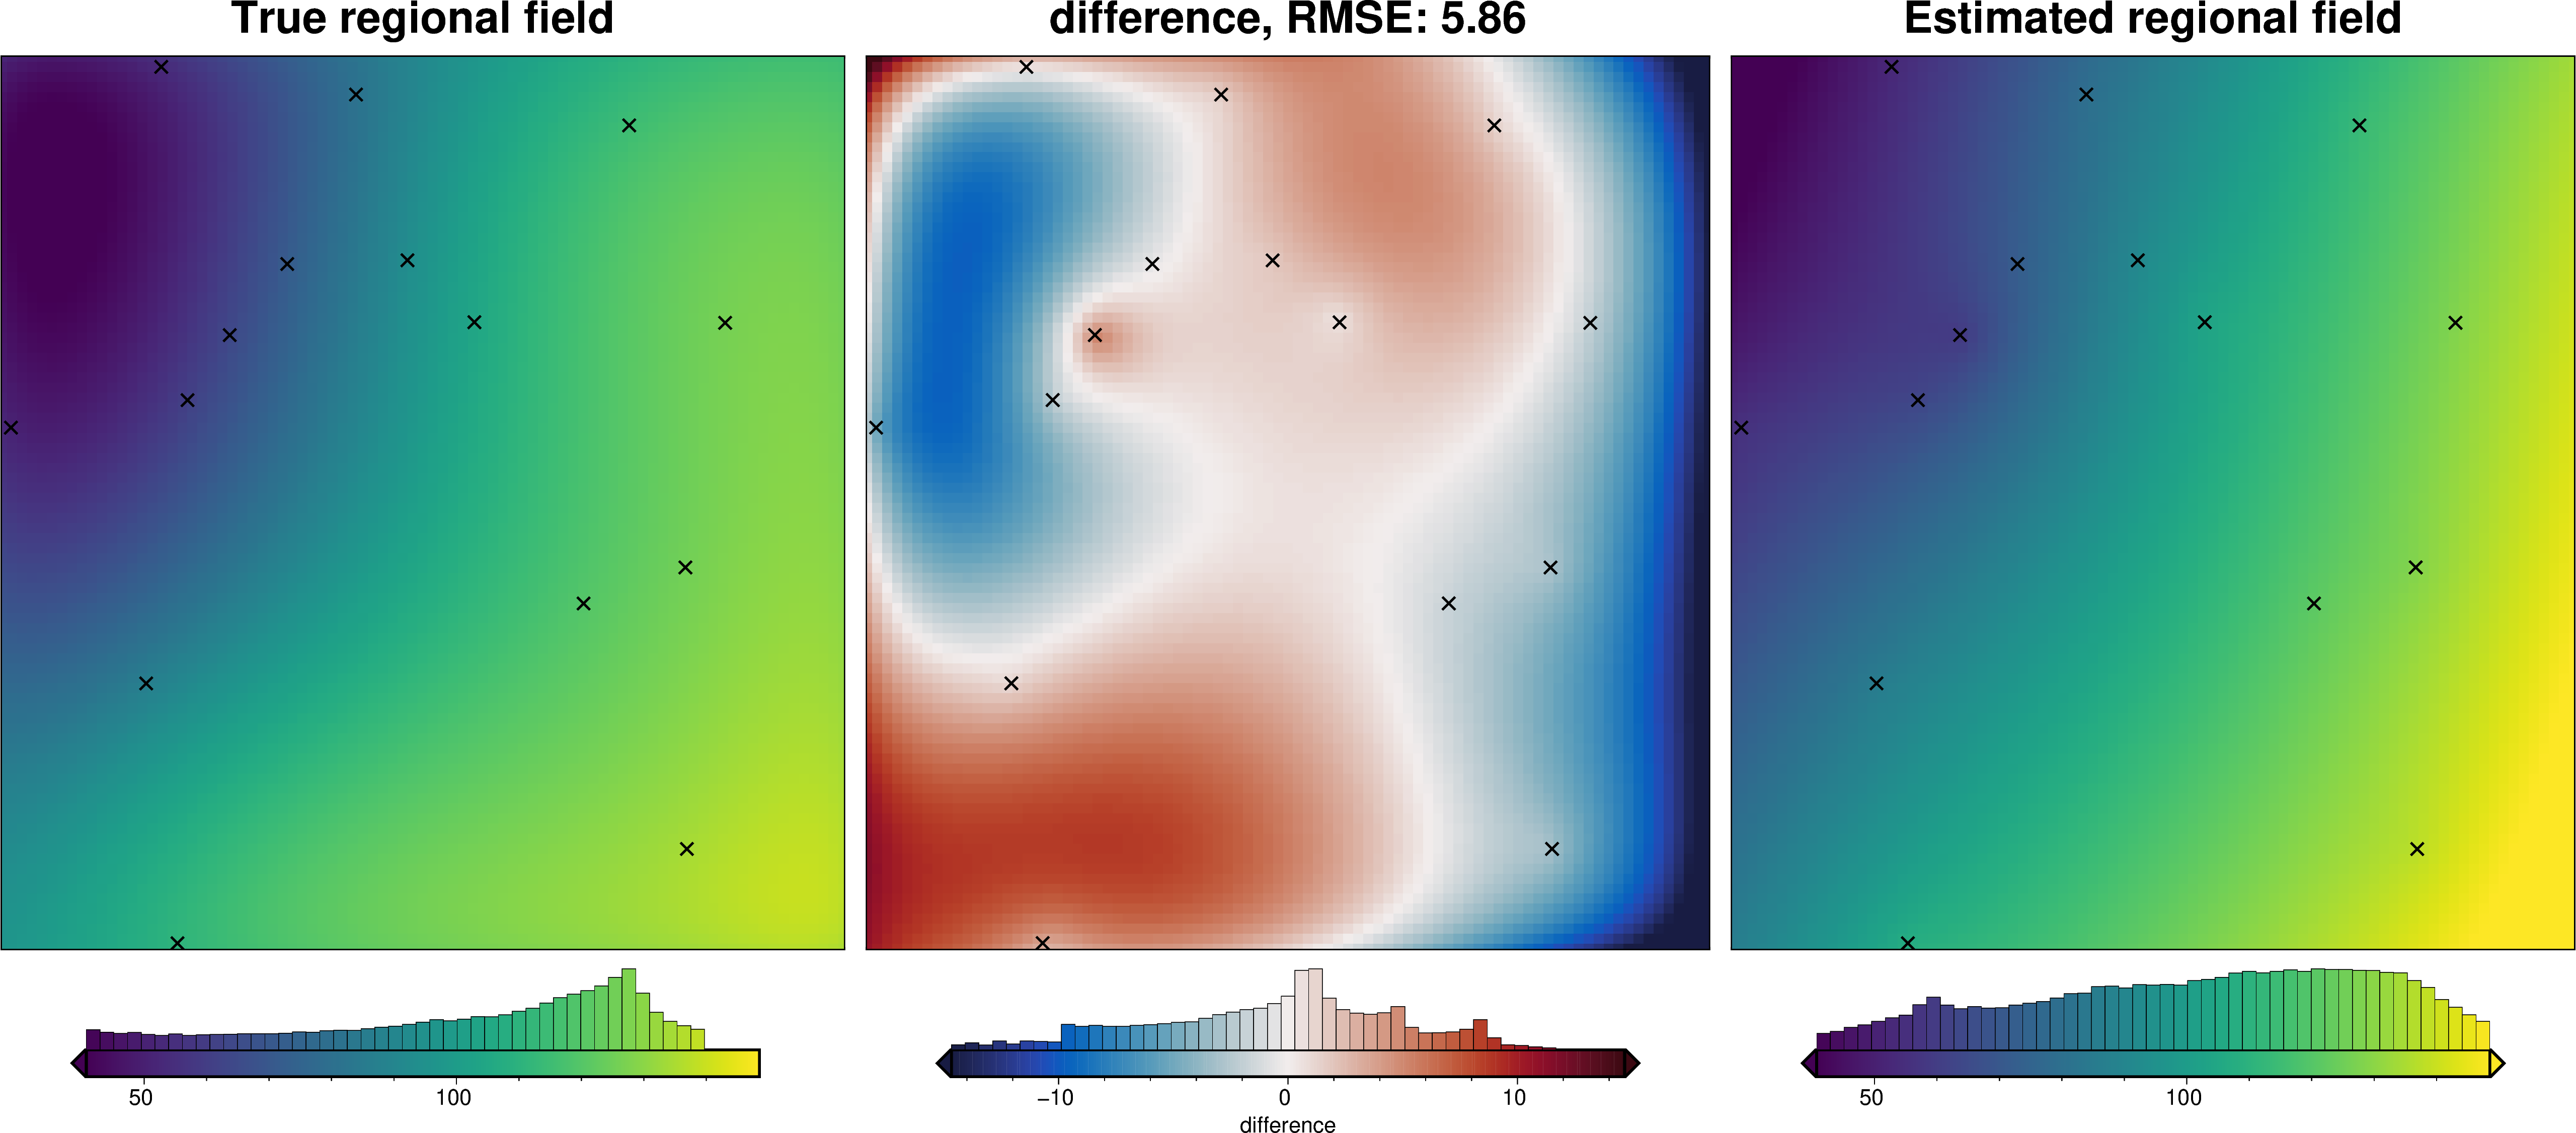

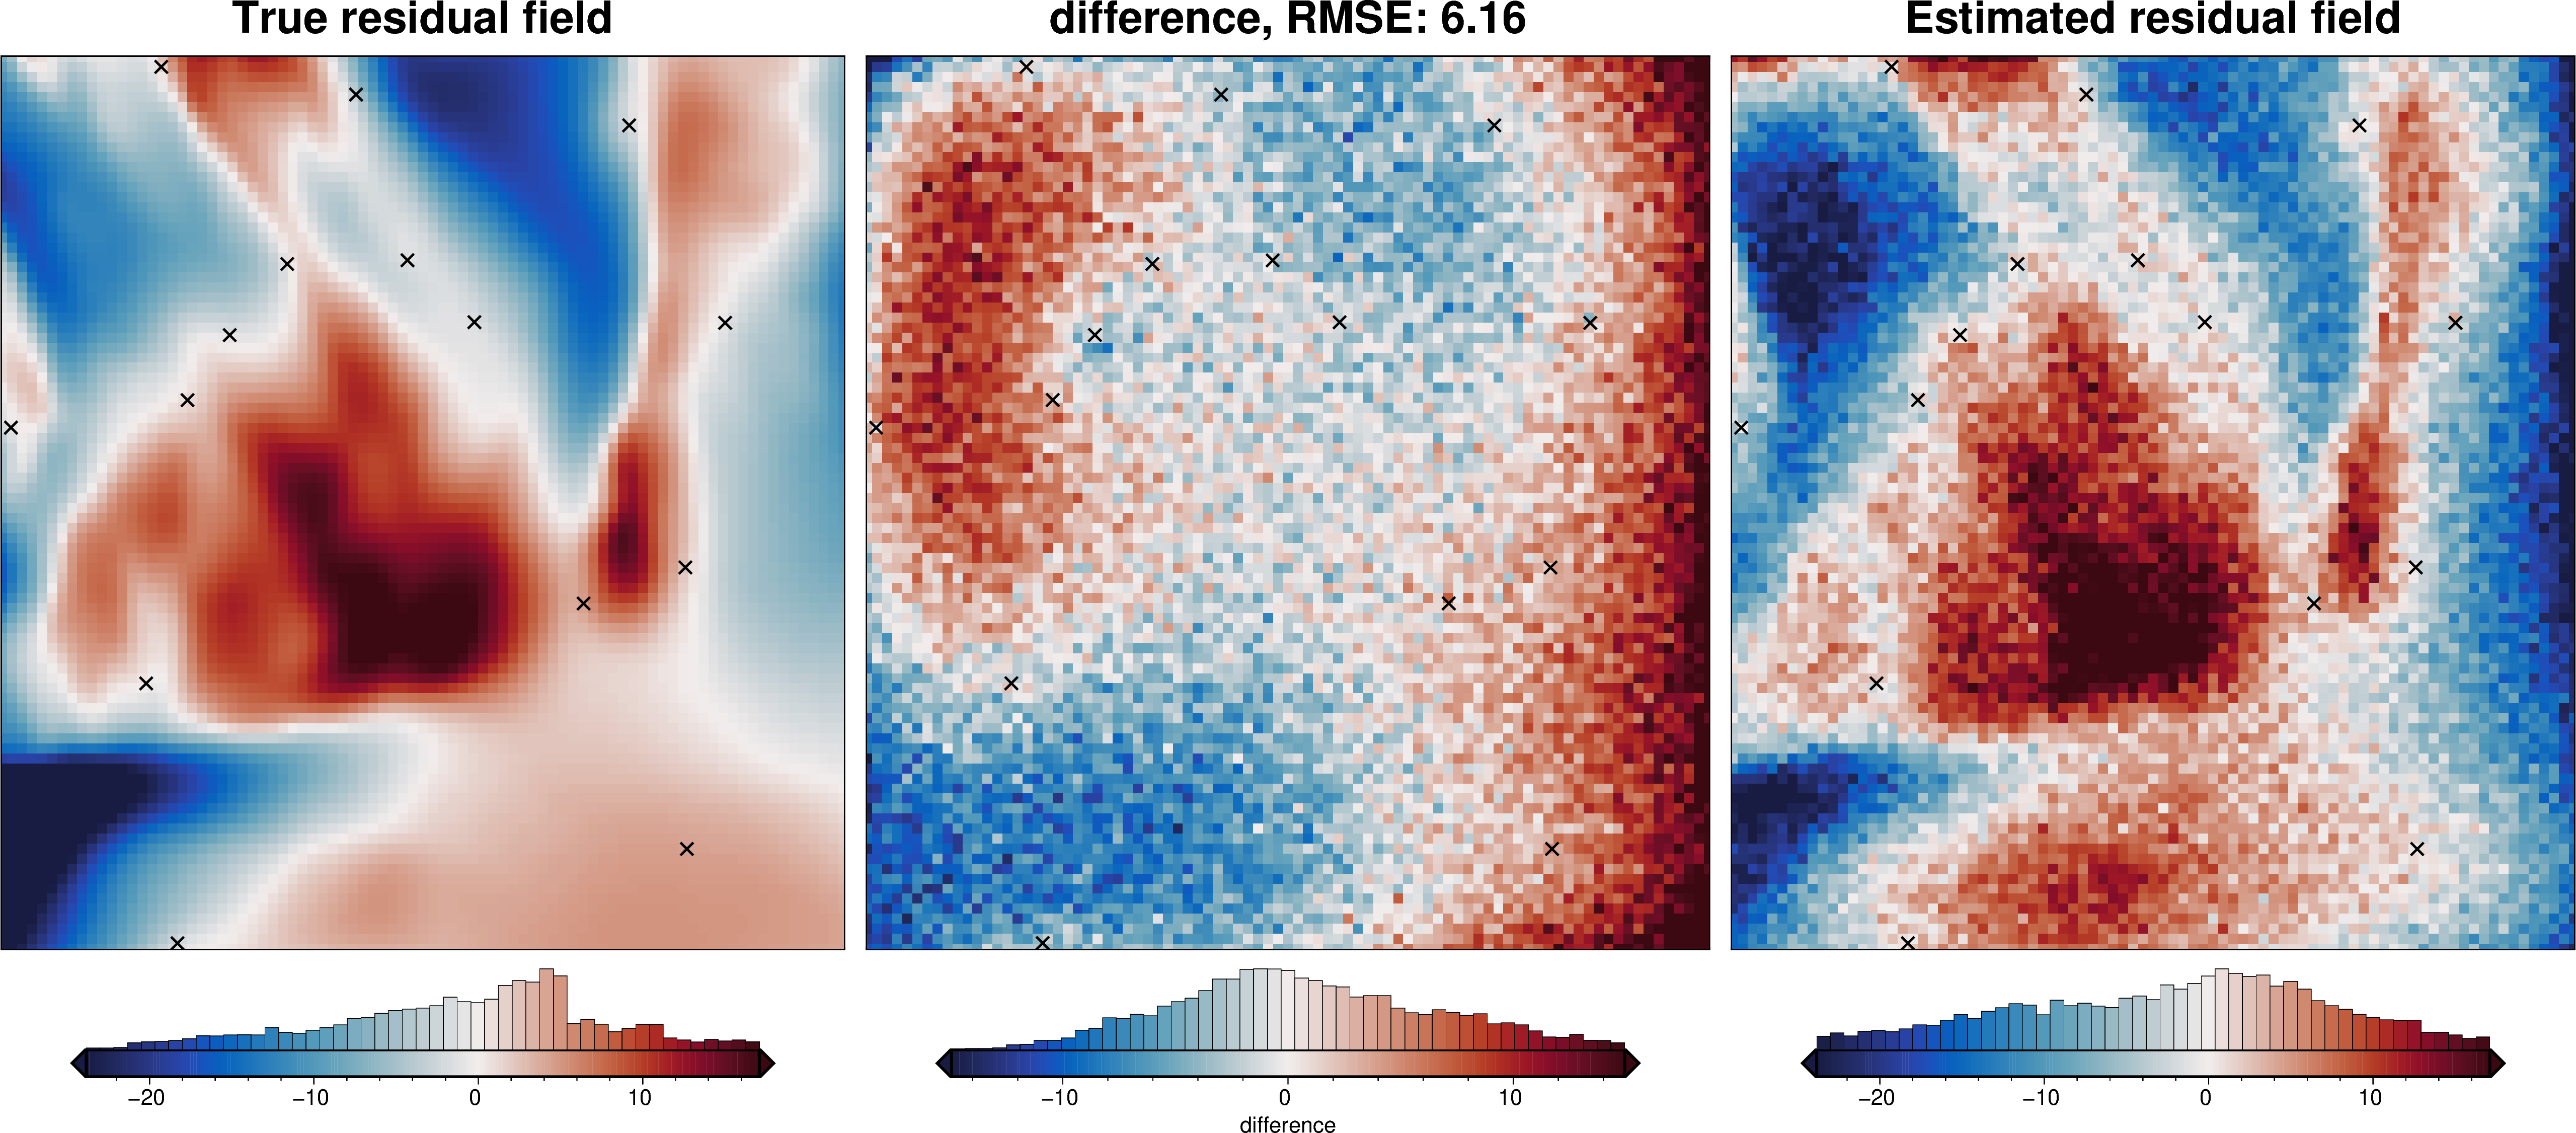

gravity_anomaly     misfit        reg        res
0        94.460183  70.812794  86.336502 -15.523709
1        94.927666  72.456090  87.427879 -14.971790
2        97.785802  76.593996  88.526497 -11.932501
3        97.975486  78.126371  89.632988 -11.506617
4        97.758807  79.290784  90.748207 -11.457423

In [26]:
# estimate regional with the constraints method
data.inv.regional_constraints(
    constraints_df=constraint_points,
    grid_method="pygmt",
    tension_factor=0.3,
)
data["constraints_pygmt_reg"] = data.reg
data["constraints_pygmt_res"] = data.res

regional_comparison(data, "constraints_pygmt_reg")

data.inv.df[["gravity_anomaly", "misfit", "reg", "res"]].head()

#### gridding with Verde and biharmonic splines

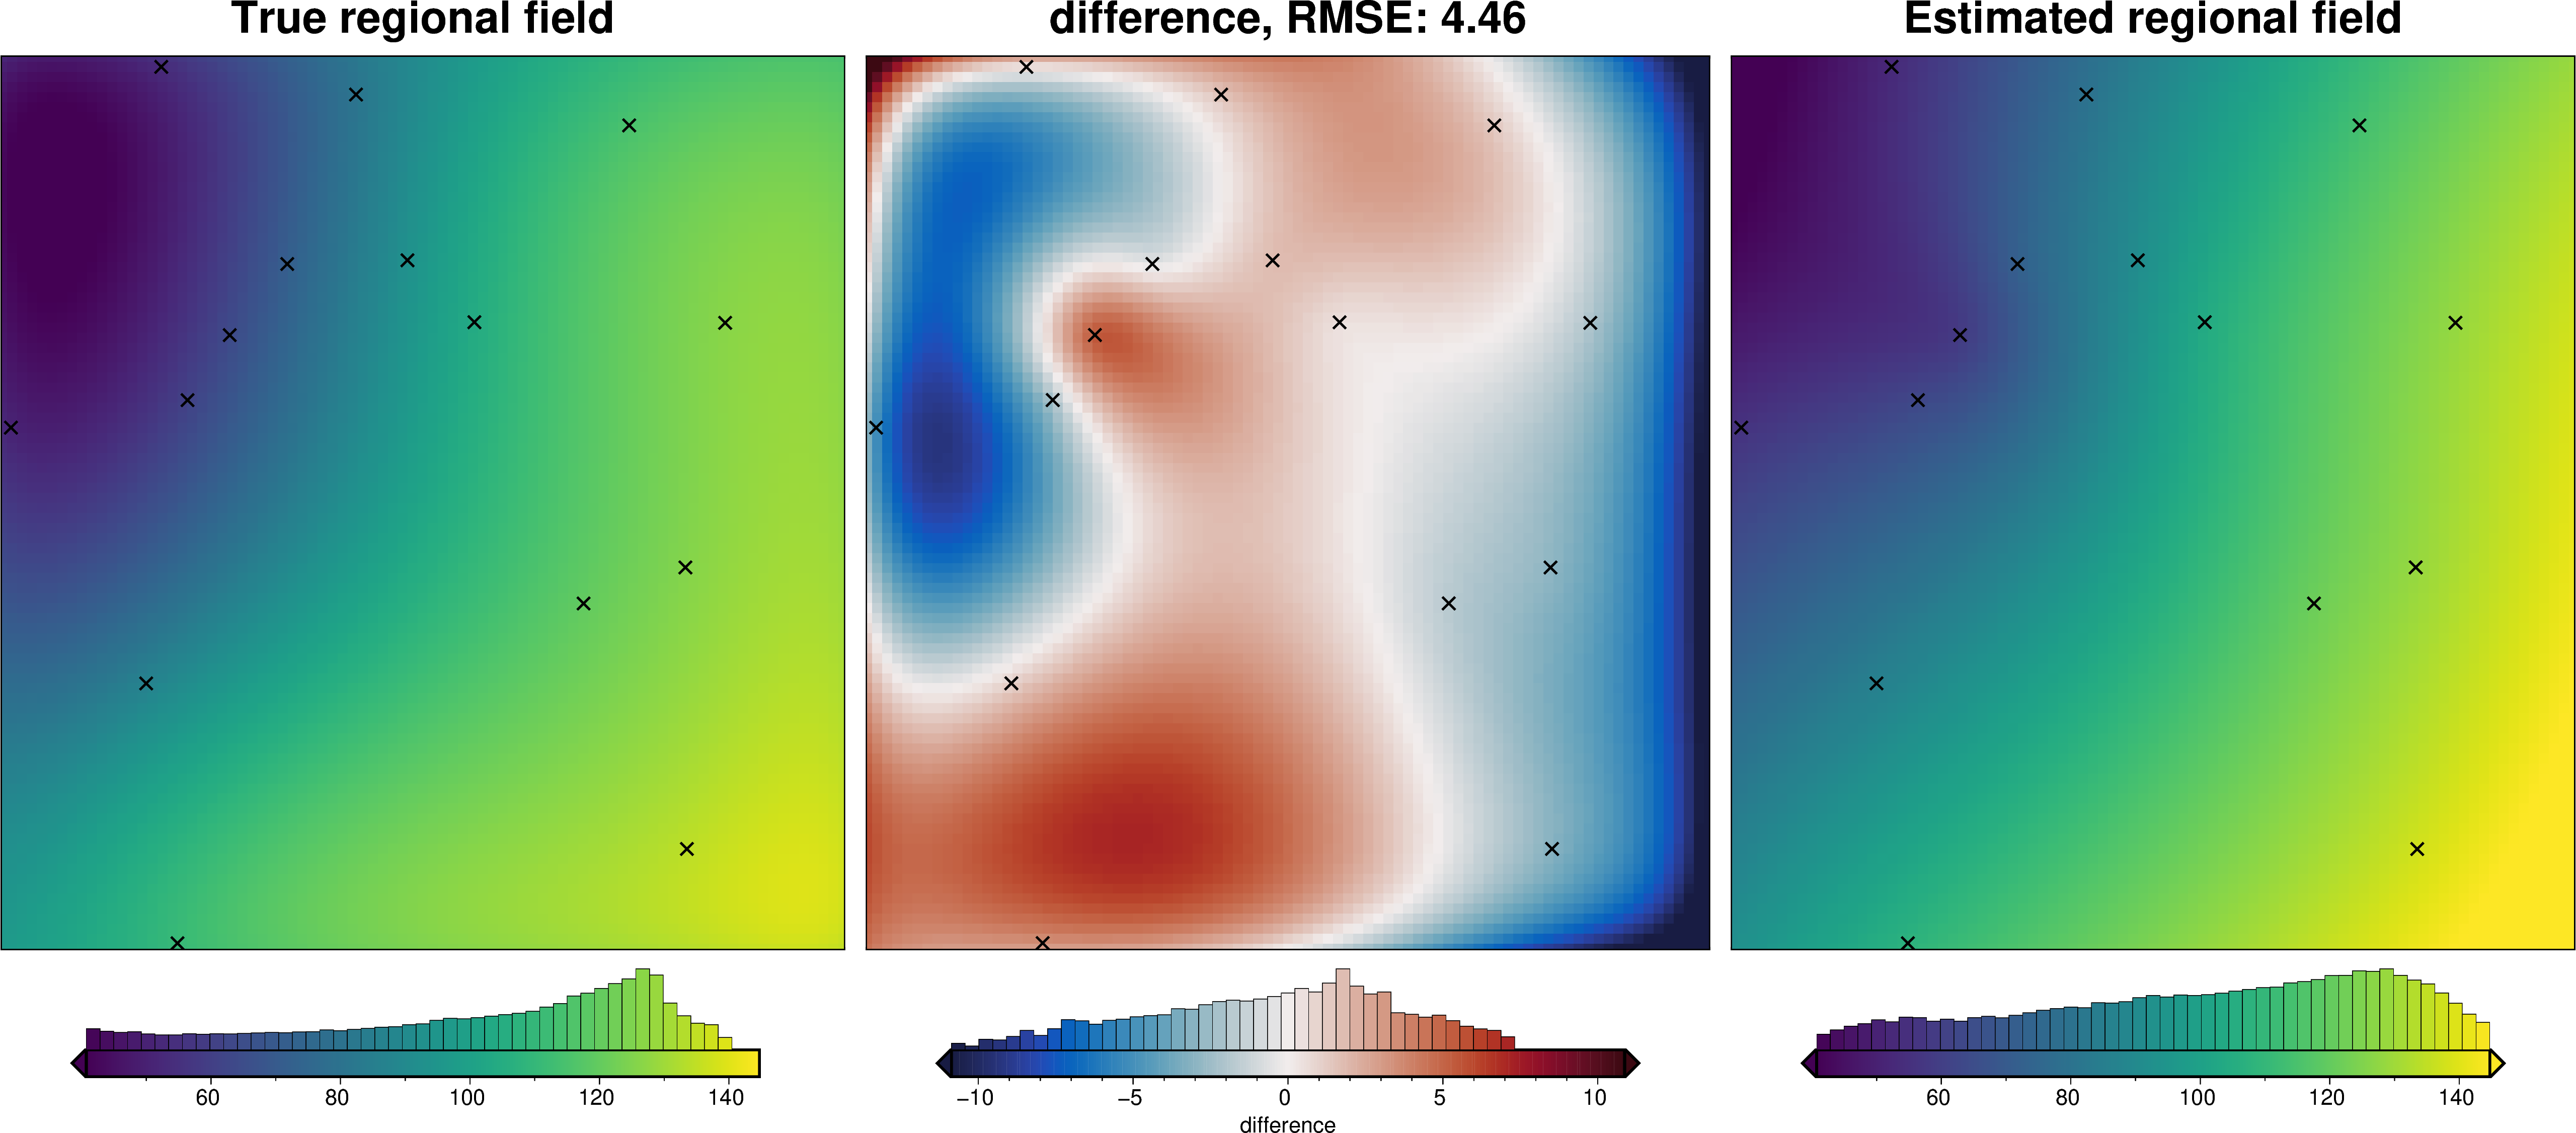

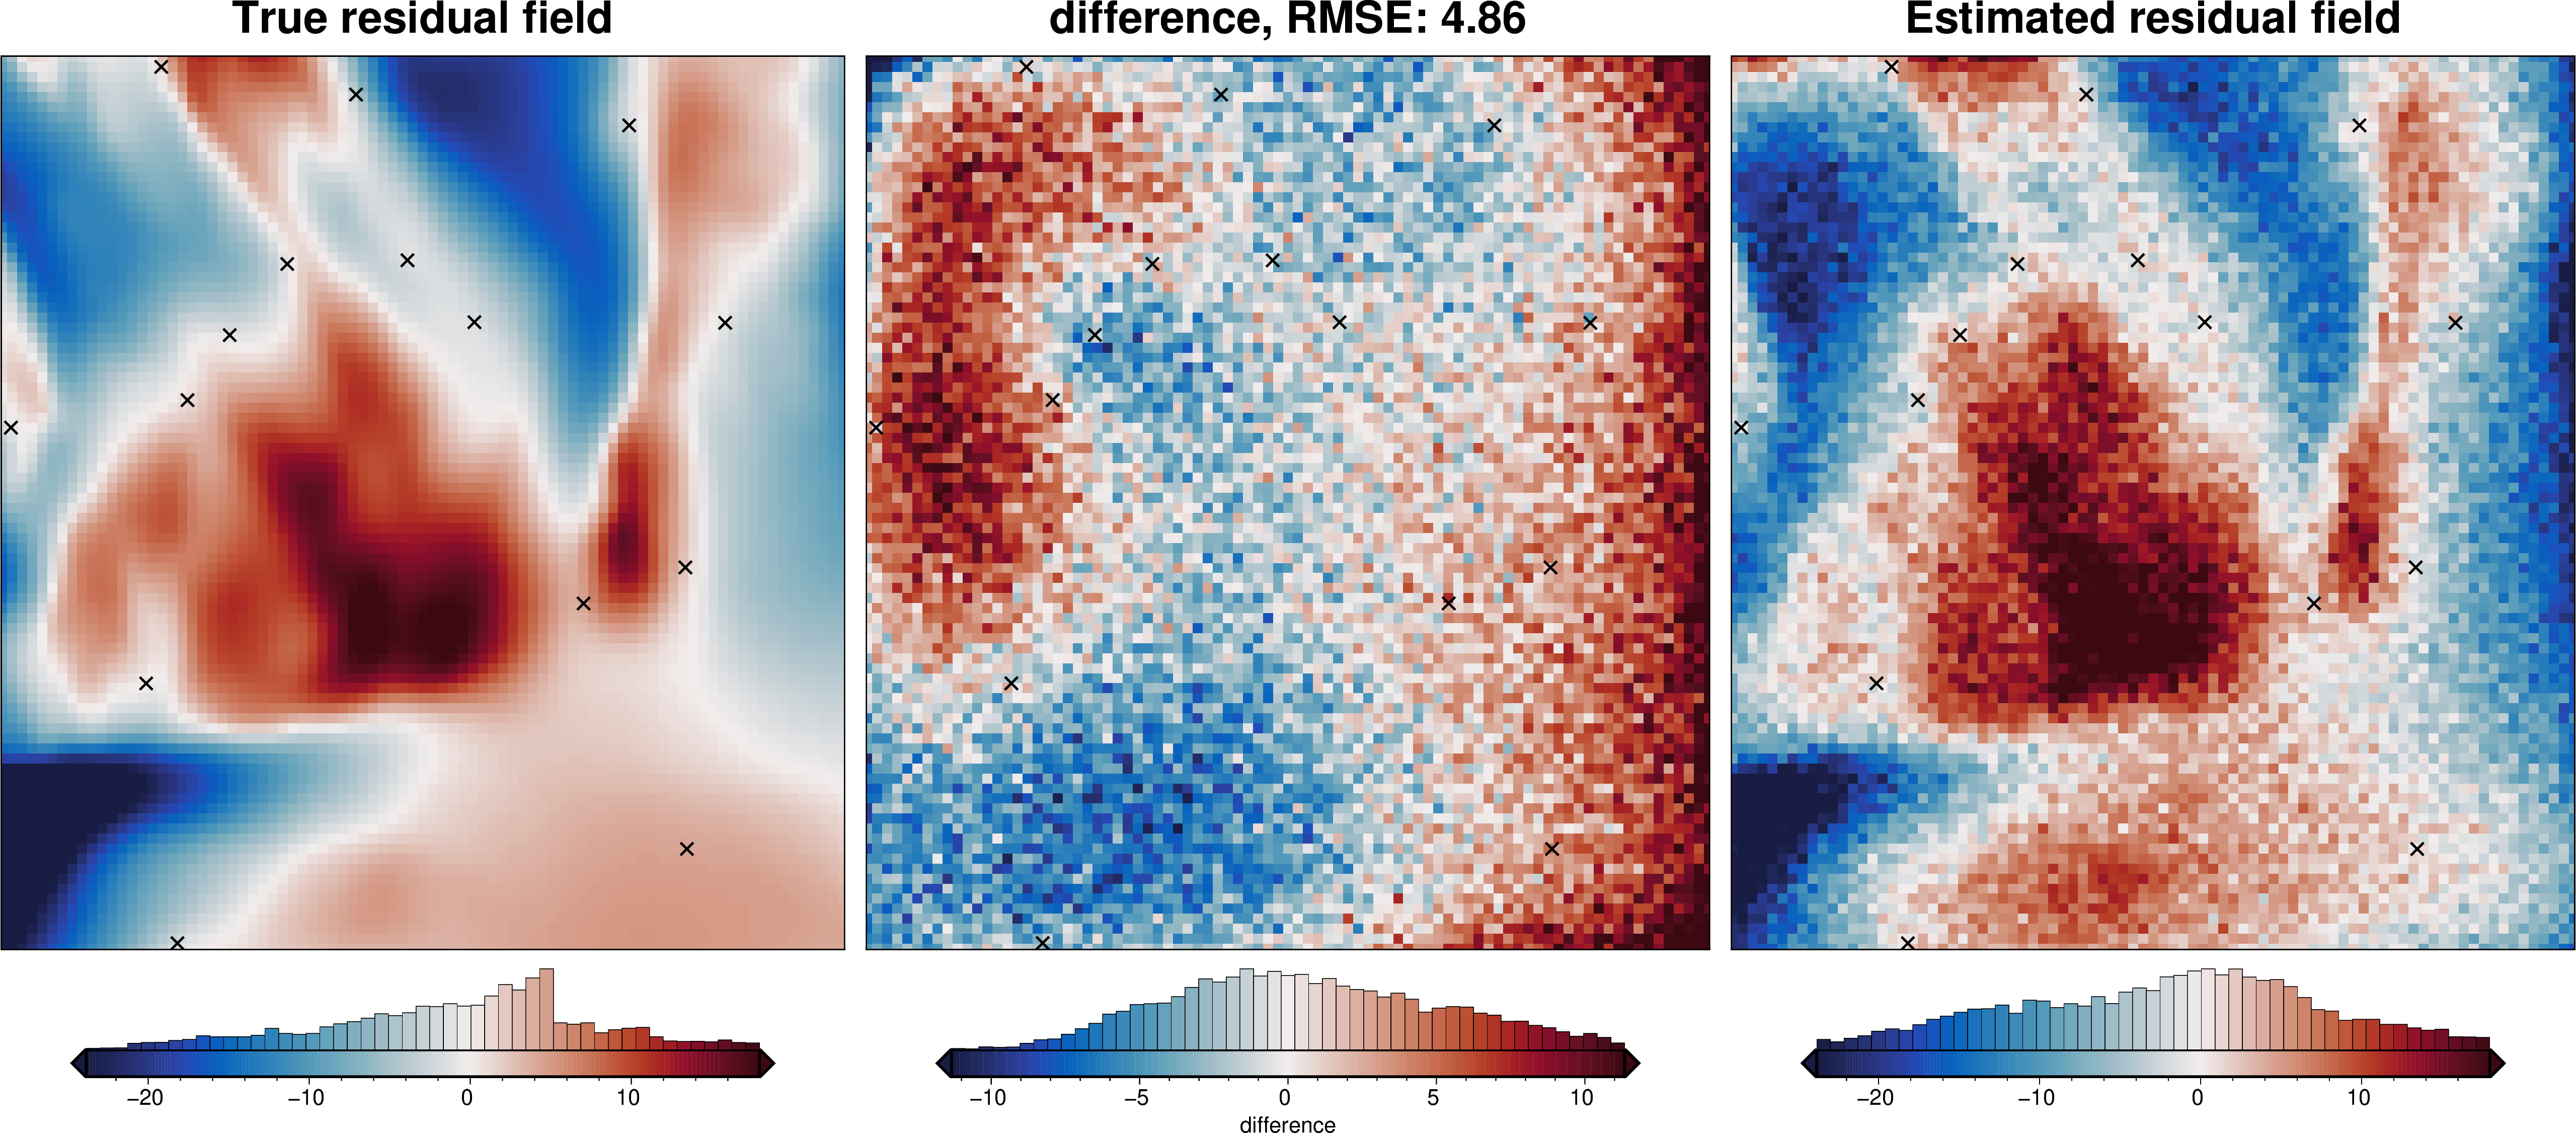

gravity_anomaly     misfit        reg        res
0        94.460183  70.812794  92.412603 -21.599810
1        94.927666  72.456090  93.331170 -20.875081
2        97.785802  76.593996  94.245098 -17.651102
3        97.975486  78.126371  95.154310 -17.027939
4        97.758807  79.290784  96.058710 -16.767926

In [27]:
# estimate regional with the constraints method
data.inv.regional_constraints(
    constraints_df=constraint_points,
    grid_method="verde",
    spline_dampings=np.logspace(-20, 0, 10),
)
data["constraints_verde_reg"] = data.reg
data["constraints_verde_res"] = data.res

regional_comparison(data, "constraints_verde_reg")

data.inv.df[["gravity_anomaly", "misfit", "reg", "res"]].head()

#### gridding with Equivalent sources

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

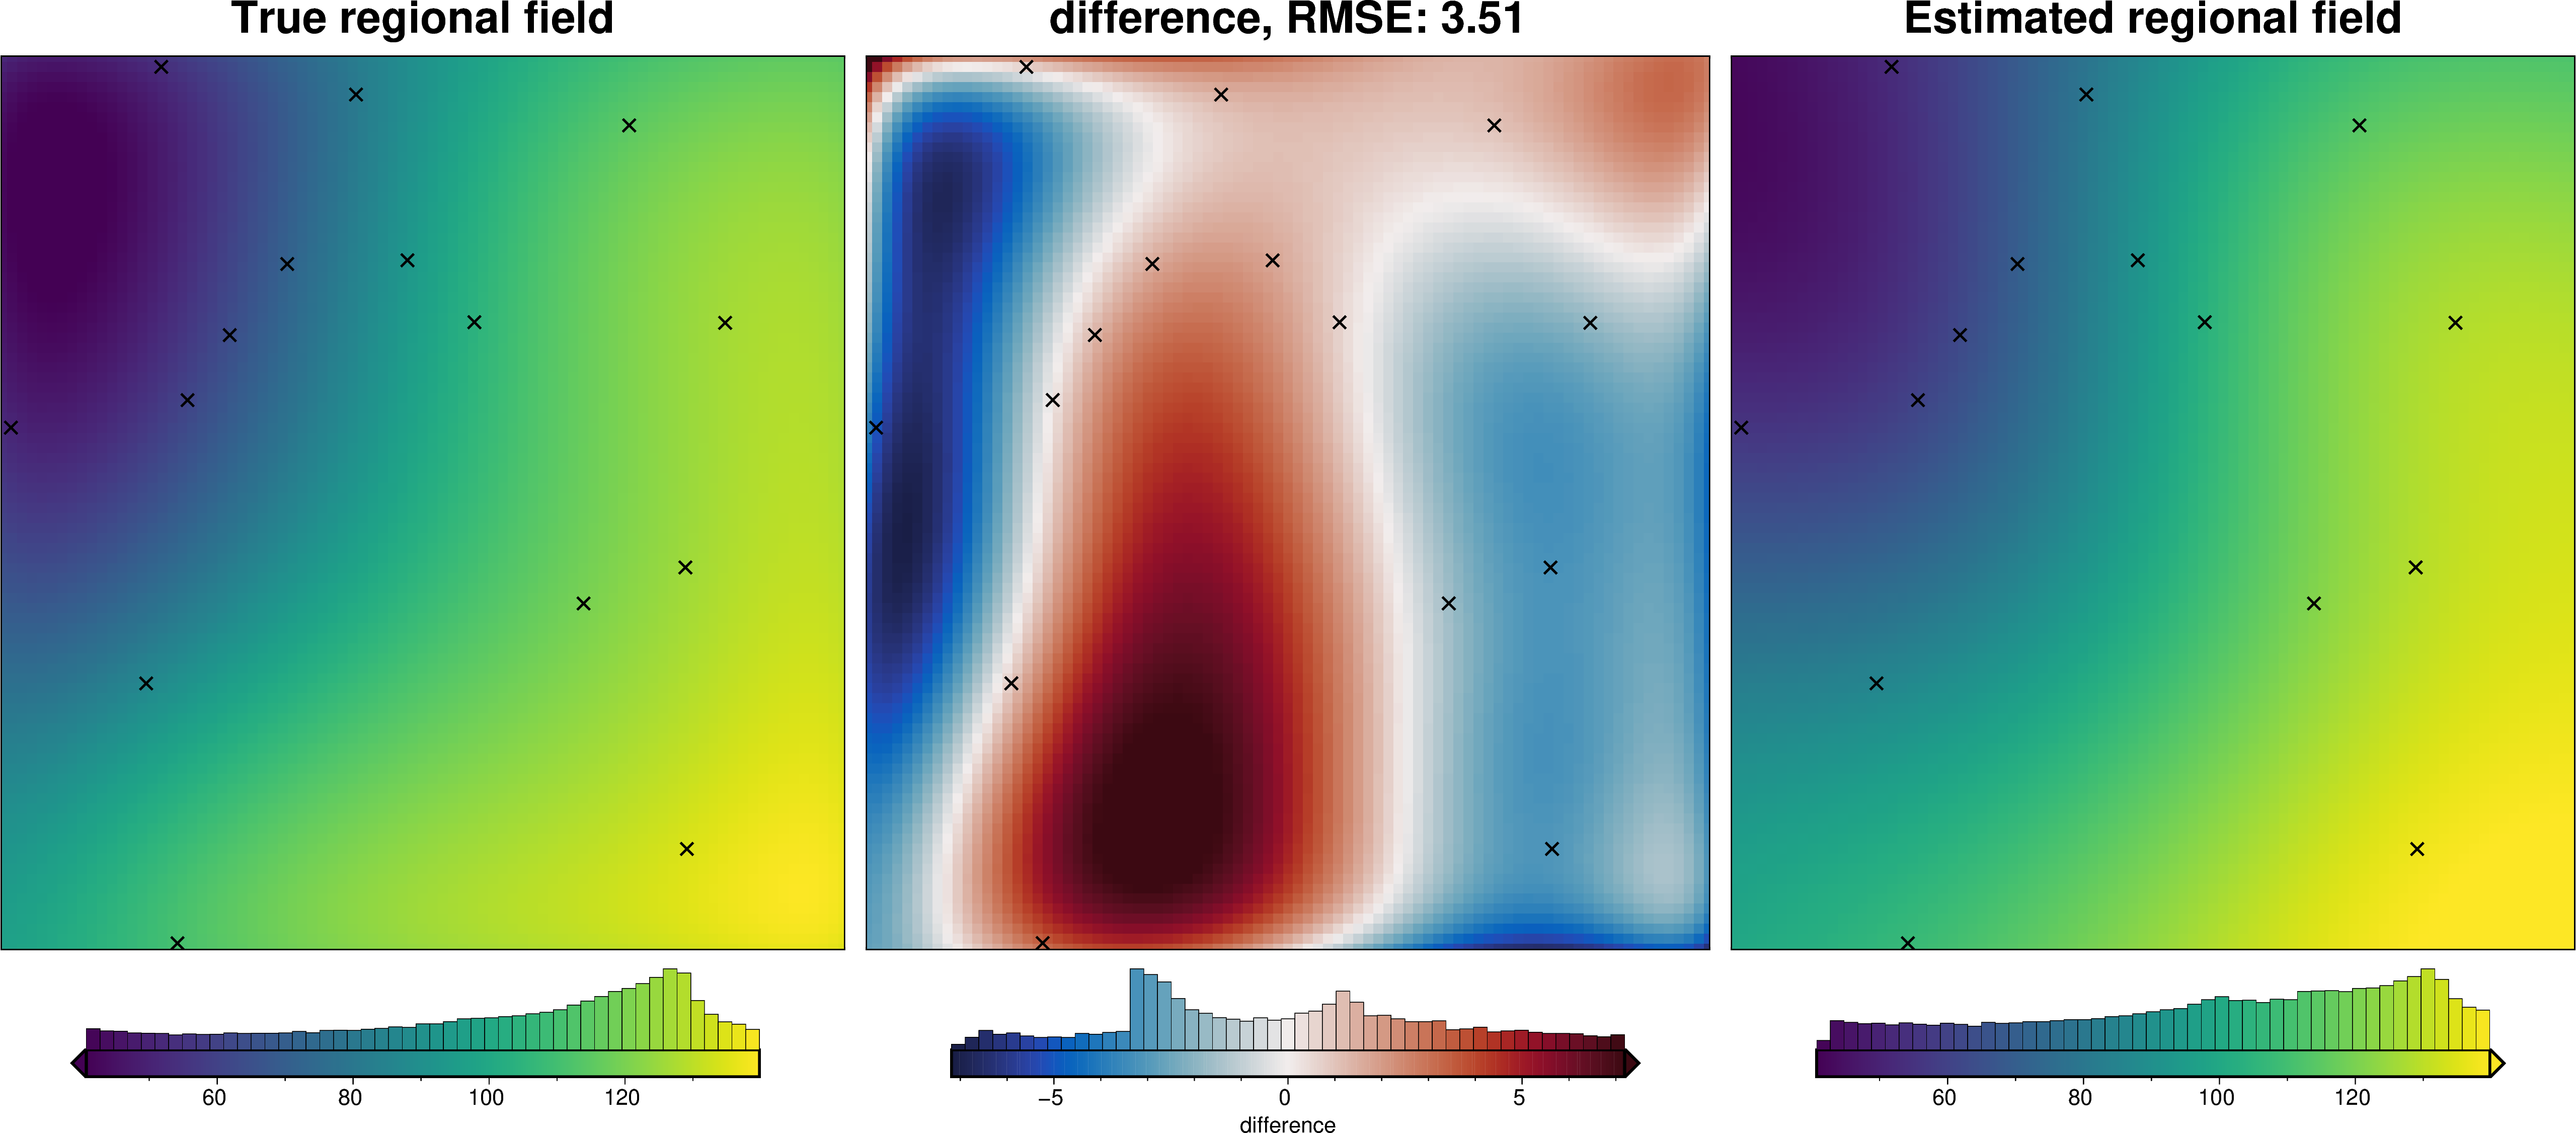

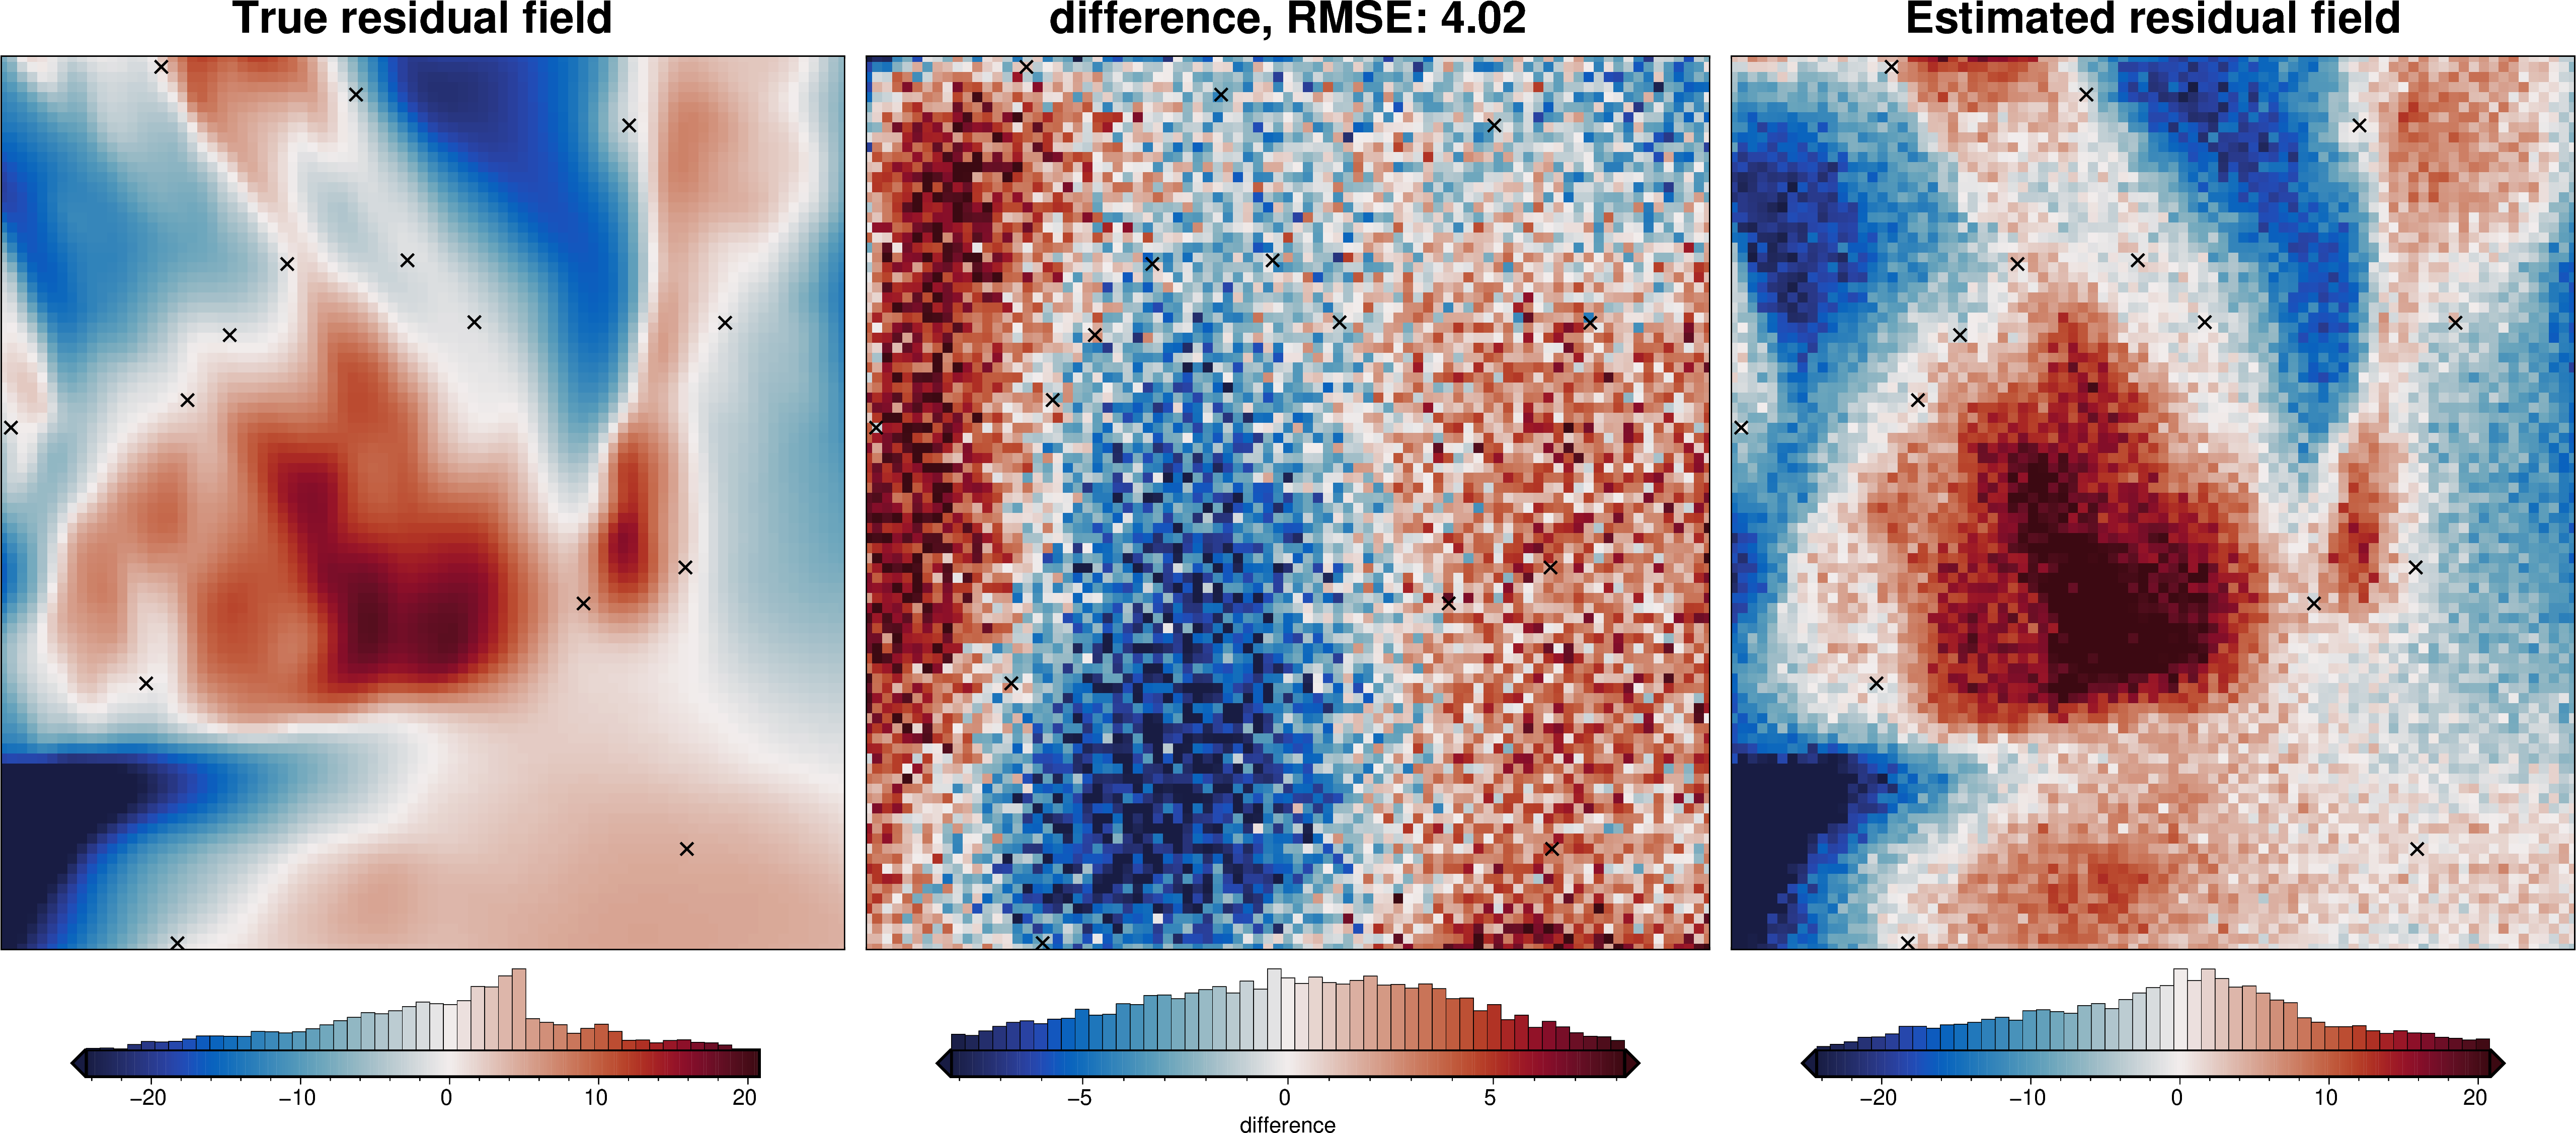

gravity_anomaly     misfit         reg        res
0        94.460183  70.812794   99.708230 -28.895436
1        94.927666  72.456090  100.092829 -27.636740
2        97.785802  76.593996  100.482543 -23.888547
3        97.975486  78.126371  100.877875 -22.751504
4        97.758807  79.290784  101.279332 -21.988548

In [28]:
# estimate regional with the constraints method
data.inv.regional_constraints(
    constraints_df=constraint_points,
    grid_method="eq_sources",
    # either automatically determine best damping
    cv=True,
    cv_kwargs=dict(
        n_trials=20,
        damping_limits=(1e-20, 1e3),
        fname="../tmp/tmp",
    ),
    # or provide a value
    # damping=1e-15,
    depth="default",
    block_size=None,
)
data["constraints_eqs_reg"] = data.reg
data["constraints_eqs_res"] = data.res

regional_comparison(data, "constraints_eqs_reg")

data.inv.df[["gravity_anomaly", "misfit", "reg", "res"]].head()

We can also use the class method `regional_separation()` and pass through the `method` and keyword args, combining all the above functions into one.

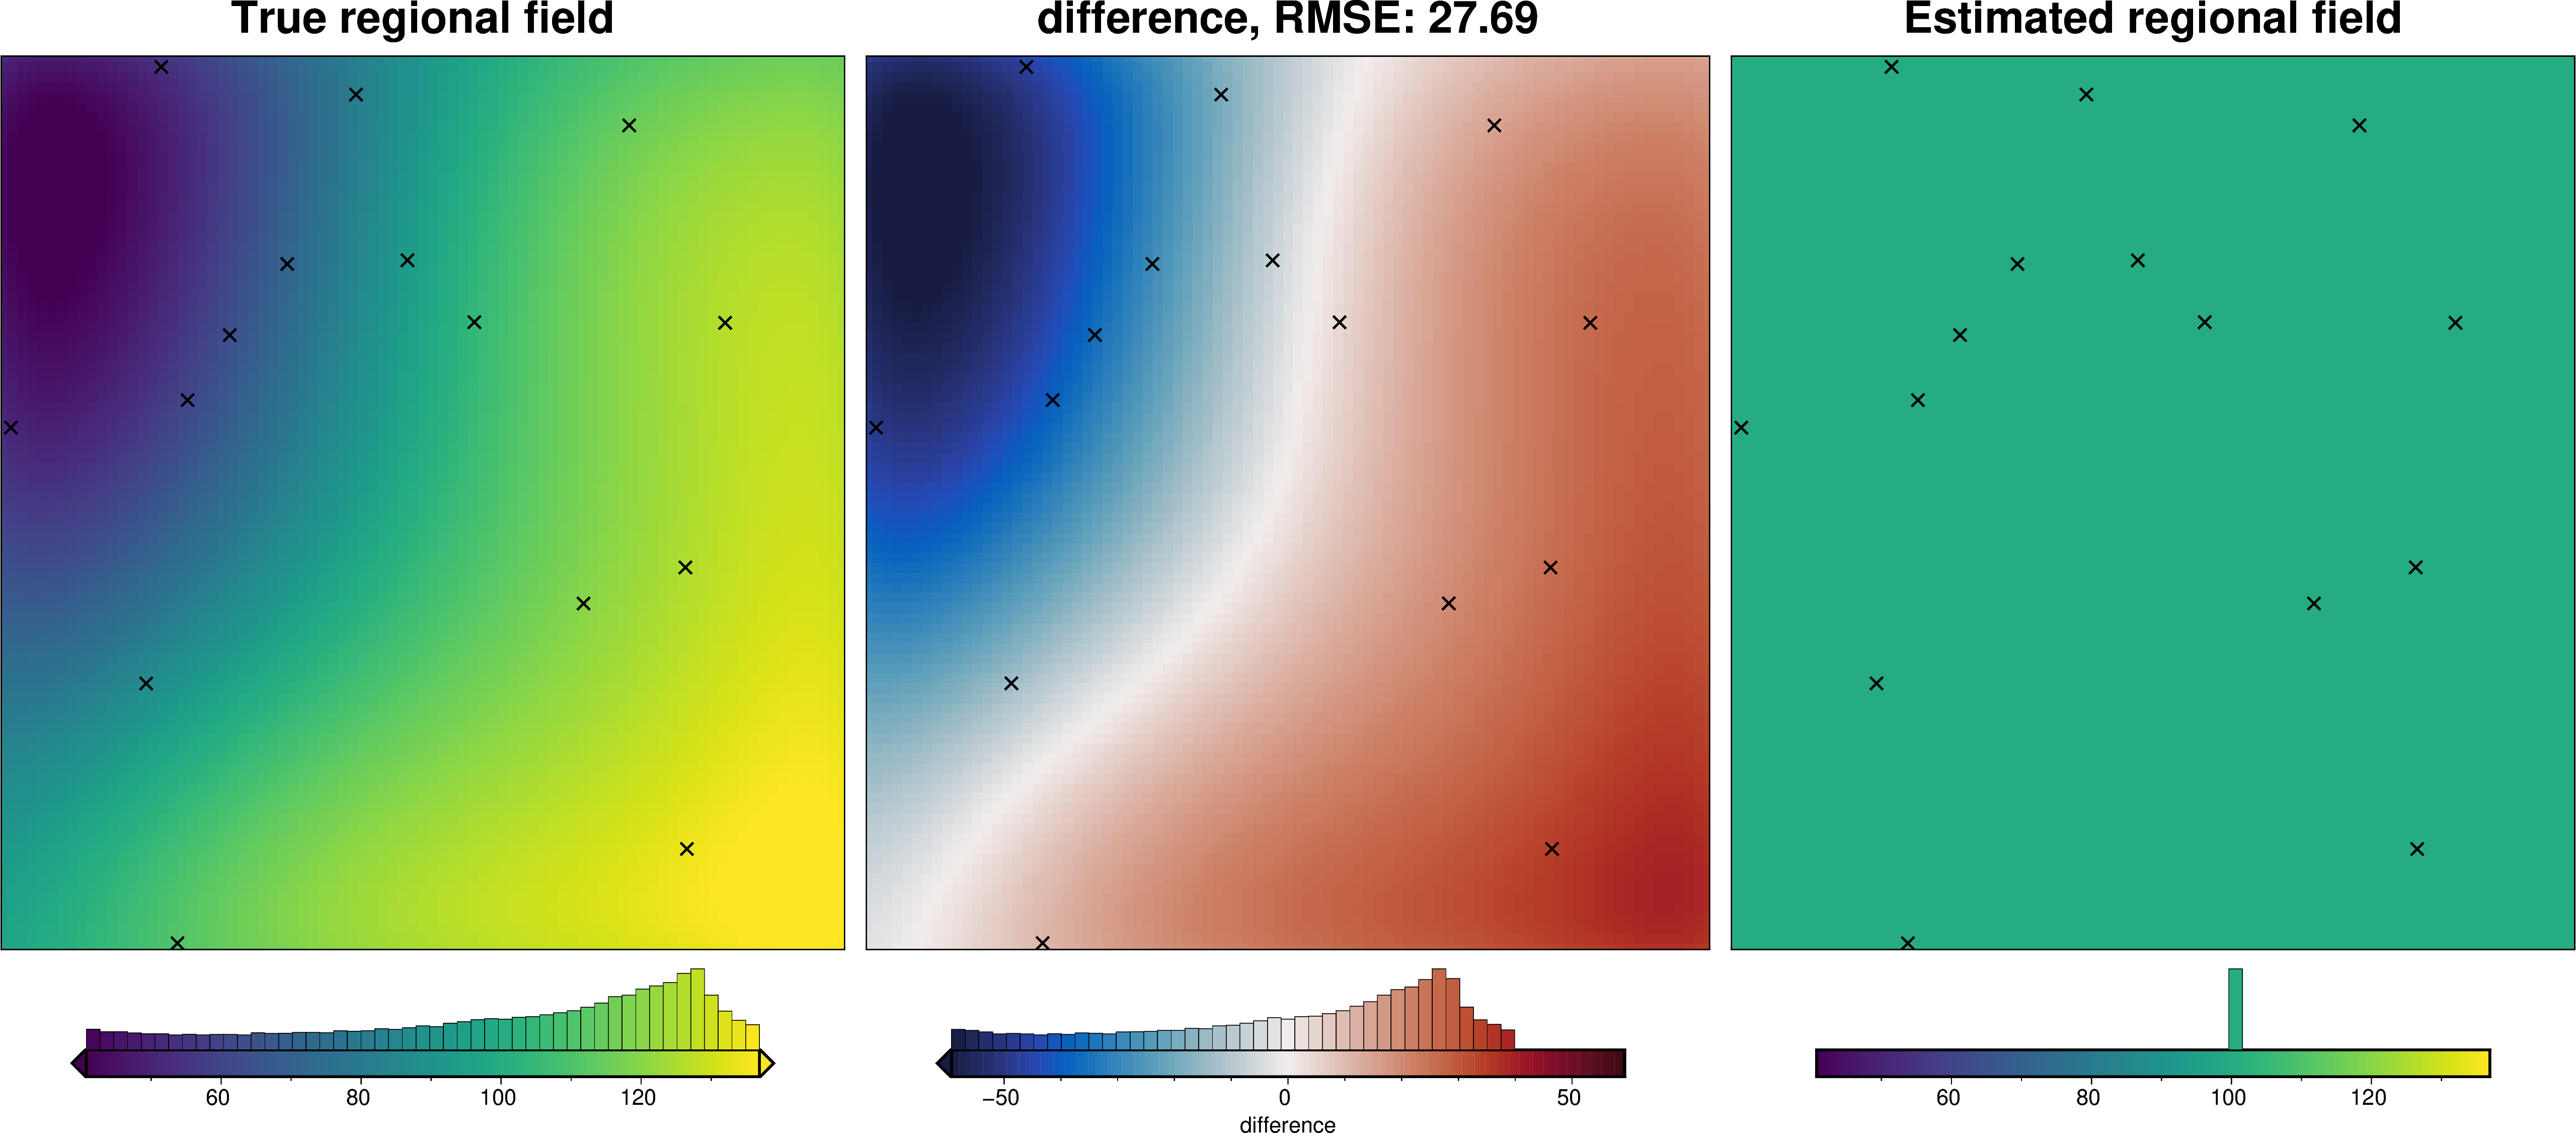

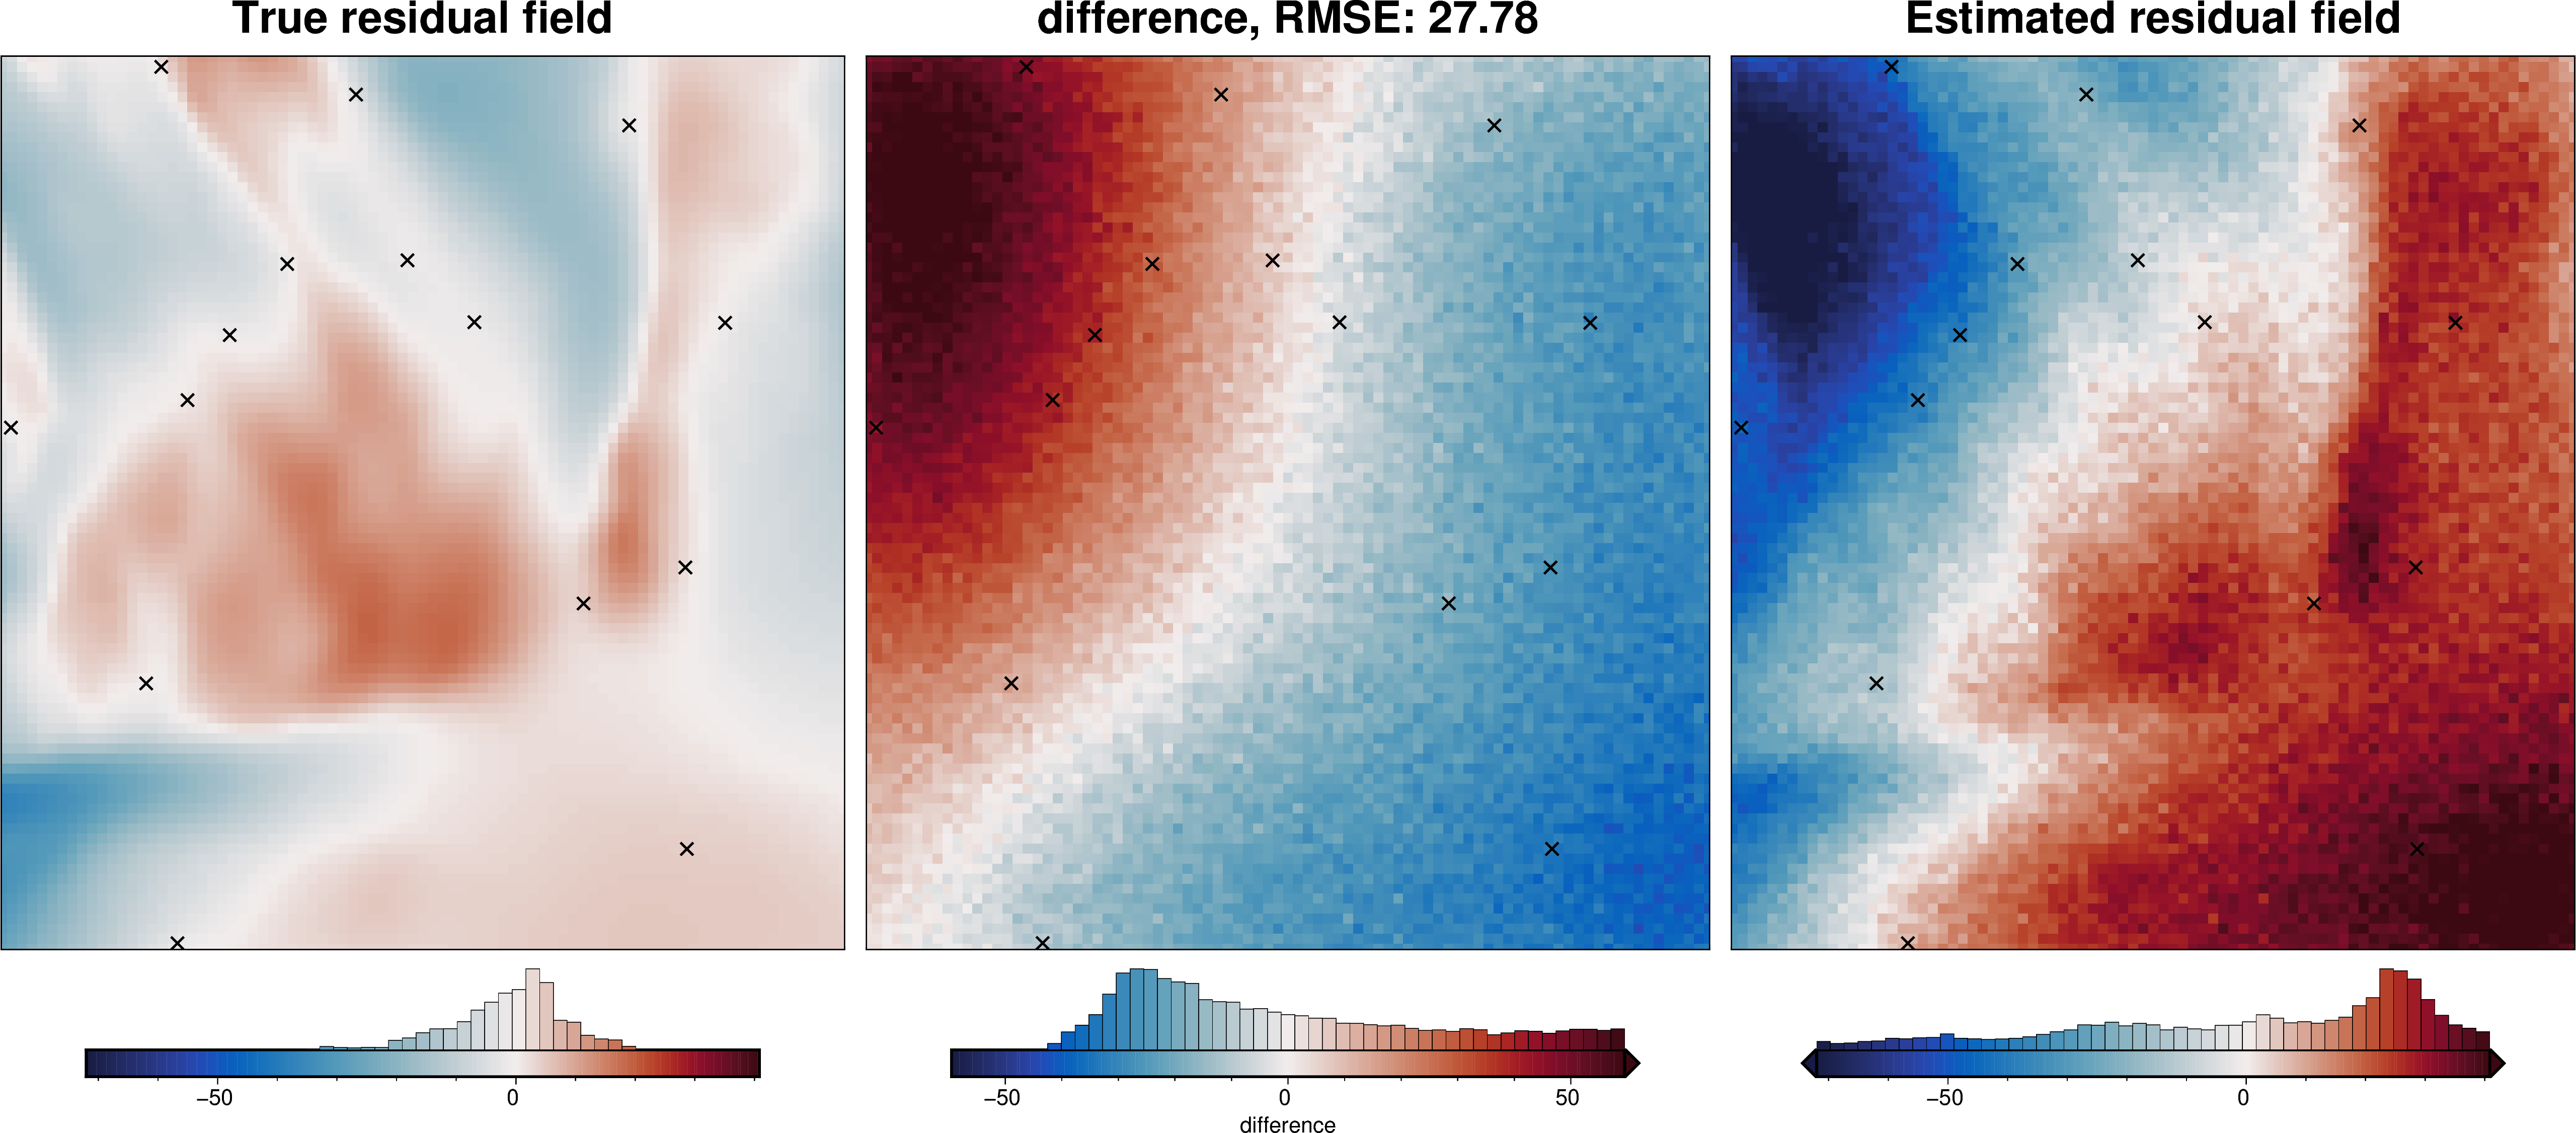

gravity_anomaly     misfit    reg        res
0        94.460183  70.812794  100.0 -29.187206
1        94.927666  72.456090  100.0 -27.543910
2        97.785802  76.593996  100.0 -23.406004
3        97.975486  78.126371  100.0 -21.873629
4        97.758807  79.290784  100.0 -20.709216

In [29]:
# estimate regional with the mean misfit at constraints
data.inv.regional_separation(
    method="constant",
    constant=100,
)

regional_comparison(data, "reg")

data.inv.df[["gravity_anomaly", "misfit", "reg", "res"]].head()

Above we just picked these hyperparameter values arbitrarily. See the [regional field hyperparameters](../how_to/regional_field_hyperparameters.ipynb) for a more informed technique for choosing each of these hyperparameter values.